In [462]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy import stats


from datetime import datetime, timezone
from pathlib import Path

from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.inspection import partial_dependence, permutation_importance
from sklearn.linear_model import ElasticNet, LassoCV, LinearRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    precision_recall_fscore_support,
    r2_score,
)
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, RobustScaler, StandardScaler

from xgboost import XGBRegressor as SGBRegressor


# 6. Dataset Information
**Method:** Load and profile the source dataset before cleaning and modeling.
**Reason:** Establish data provenance, schema, target behavior, time coverage, and quality baseline.


In [463]:
data_path =Path("../../data/raw/automobile_data.csv")

df = pd.read_csv(data_path)
df.columns = df.columns.str.strip()
df.head(5)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,length,...,wheelbase,engine_type,fuel_system,transmission_type,num_gears,drive_type,drag_coefficient,frontal_area,compression_ratio,top_speed
0,48.9,4,155.7,98.0,2198,17.4,2004,2,Subaru Hybrid EX,222.8,...,119.6,Inline-4,MPFI,Manual,6.0,AWD,0.441,33.6,11.0,127.0
1,46.3,4,106.6,57.0,2145,23.1,2024,2,Tesla Wagon LX,209.6,...,118.3,Inline-4,Carburetor,CVT,NaN,FWD,0.326,35.2,10.2,136.0
2,43.4,4,121.2,104.0,2404,18.3,2018,1,Chevrolet Hybrid Sport,230.0,...,123.3,Inline-4,MPFI,Automatic,7.0,FWD,0.359,27.6,NaN,123.0
3,36.5,6,246.3,103.0,3307,19.1,2013,3,Mazda Wagon Limited,230.0,...,125.3,Inline-6,NaN,Automatic,6.0,FWD,0.359,28.8,9.0,120.0
4,38.6,5,168.9,NaN,2324,18.4,1990,1,Mercedes SUV EX,230.0,...,125.6,V12,MPFI,DCT,NaN,FWD,0.397,30.0,11.2,132.0


# 6.1 Dataset Sources
**Primary file used in notebook:** `data/raw/automobile_data.csv`  
**Document-listed source families:** UCI Auto MPG, EPA fuel economy data, NHTSA specs, OEM specs, consumer testing datasets.


In [464]:
section6_1_source_summary = pd.DataFrame([
    {
        'dataset_file': str(data_path),
        'rows': int(df.shape[0]),
        'columns': int(df.shape[1]),
        'target_variable': 'mpg',
    }
])

print('section6_1_source_summary')
section6_1_source_summary


section6_1_source_summary


,dataset_file,rows,columns,target_variable
0,..\..\data\raw\automobile_data.csv,10000,22,mpg


# 6.2 Dataset Structure
**Method:** Use `info`, `describe`, and missing-value counts.
**Reason:** Confirm schema, feature ranges, and null patterns before Section 7 cleaning.


In [465]:
df.info()


<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   mpg                10000 non-null  float64
 1   cylinders          10000 non-null  int64  
 2   displacement       10000 non-null  float64
 3   horsepower         9700 non-null   float64
 4   weight             10000 non-null  int64  
 5   acceleration       9800 non-null   float64
 6   model_year         10000 non-null  int64  
 7   origin             10000 non-null  int64  
 8   car_name           10000 non-null  str    
 9   length             9600 non-null   float64
 10  width              9600 non-null   float64
 11  height             9500 non-null   float64
 12  wheelbase          9700 non-null   float64
 13  engine_type        9400 non-null   str    
 14  fuel_system        9600 non-null   str    
 15  transmission_type  9800 non-null   str    
 16  num_gears          7873 non-null  

In [466]:
df.describe()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,length,width,height,wheelbase,num_gears,drag_coefficient,frontal_area,compression_ratio,top_speed
count,10000.000000,10000.000000,10000.000000,9700.000000,10000.000000,9800.000000,10000.000000,10000.000000,9600.000000,9600.000000,9500.000000,9700.000000,7873.000000,8500.000000,8800.000000,9200.000000,9000.000000
mean,39.616140,5.461700,214.773880,129.291031,2866.138400,18.365990,2005.953400,1.764500,226.517729,81.991344,63.763411,124.651289,6.137178,0.391547,30.868091,10.981033,132.255444
std,8.111112,1.756372,108.782496,76.596821,1155.618665,2.432997,14.480283,0.833732,7.665208,0.146590,8.199637,5.142591,1.386081,0.051129,4.088239,1.336442,24.138849
min,9.000000,3.000000,60.800000,50.000000,1800.000000,9.500000,1970.000000,1.000000,168.700000,75.900000,52.000000,90.700000,4.000000,0.285000,22.400000,8.000000,85.000000
25%,35.600000,4.000000,137.500000,74.000000,1902.000000,16.700000,1997.000000,1.000000,228.800000,82.000000,56.000000,122.700000,5.000000,0.353000,27.100000,9.900000,116.000000
50%,41.200000,5.000000,180.700000,109.000000,2511.000000,18.600000,2009.000000,2.000000,230.000000,82.000000,65.200000,125.600000,6.000000,0.387000,30.600000,11.000000,129.000000
75%,45.400000,6.000000,258.500000,160.000000,3341.250000,20.200000,2018.000000,3.000000,230.000000,82.000000,71.700000,127.900000,7.000000,0.426000,34.600000,12.100000,145.000000
max,55.000000,12.000000,643.700000,559.000000,6500.000000,24.300000,2025.000000,3.000000,230.000000,82.000000,78.000000,135.000000,10.000000,0.500000,40.000000,13.600000,220.000000


In [467]:
df.isna().sum()


mpg                     0
cylinders               0
displacement            0
horsepower            300
weight                  0
acceleration          200
model_year              0
origin                  0
car_name                0
length                400
width                 400
height                500
wheelbase             300
engine_type           600
fuel_system           400
transmission_type     200
num_gears            2127
drive_type            300
drag_coefficient     1500
frontal_area         1200
compression_ratio     800
top_speed            1000
dtype: int64

# 6.3 Target Variable Distribution
**Method:** Summarize `mpg` statistics and distribution shape.
**Reason:** Baseline target behavior before feature engineering/modeling.


In [468]:
mpg_series = pd.to_numeric(df['mpg'], errors='coerce')

section6_3_target_distribution = pd.DataFrame([
    {
        'count': int(mpg_series.notna().sum()),
        'mean_mpg': float(mpg_series.mean()),
        'median_mpg': float(mpg_series.median()),
        'std_mpg': float(mpg_series.std()),
        'min_mpg': float(mpg_series.min()),
        'max_mpg': float(mpg_series.max()),
        'range_mpg': float(mpg_series.max() - mpg_series.min()),
        'skewness': float(mpg_series.skew()),
    }
])

print('section6_3_target_distribution')
print(section6_3_target_distribution)
section6_3_target_distribution


section6_3_target_distribution
   count  mean_mpg  median_mpg   std_mpg  min_mpg  max_mpg  range_mpg  \
0  10000  39.61614        41.2  8.111112      9.0     55.0       46.0   

   skewness  
0 -0.906806  


,count,mean_mpg,median_mpg,std_mpg,min_mpg,max_mpg,range_mpg,skewness
0,10000,39.61614,41.2,8.111112,9.0,55.0,46.0,-0.906806


# 6.4 Data Collection Period
**Method:** Infer coverage from `model_year` in the dataset.
**Reason:** Validate historical span for downstream temporal checks.


section6_4_collection_period
   model_year_min  model_year_max  n_unique_model_years
0            1970            2025                    56


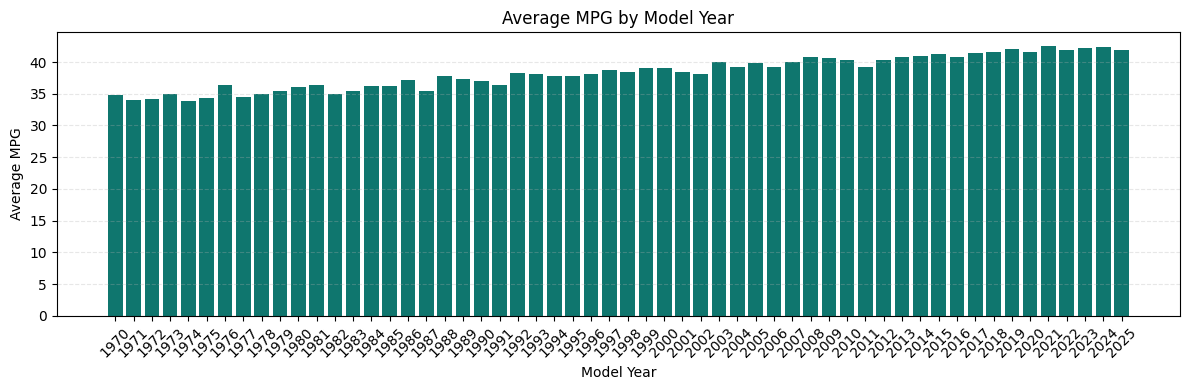

,model_year_min,model_year_max,n_unique_model_years
0,1970,2025,56


In [469]:
model_year_series = pd.to_numeric(df['model_year'], errors='coerce')
mpg_series = pd.to_numeric(df['mpg'], errors='coerce')

section6_4_collection_period = pd.DataFrame([
    {
        'model_year_min': int(model_year_series.min()) if model_year_series.notna().any() else np.nan,
        'model_year_max': int(model_year_series.max()) if model_year_series.notna().any() else np.nan,
        'n_unique_model_years': int(model_year_series.nunique(dropna=True)),
    }
])

year_mpg_df = pd.DataFrame({
    'model_year': model_year_series,
    'mpg': mpg_series,
}).dropna(subset=['model_year', 'mpg'])

yearly_mpg_summary = (
    year_mpg_df
    .groupby('model_year', as_index=False)['mpg']
    .mean()
    .sort_values('model_year')
)
yearly_mpg_summary['model_year'] = yearly_mpg_summary['model_year'].astype(int)

print('section6_4_collection_period')
print(section6_4_collection_period)

fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(
    yearly_mpg_summary['model_year'].astype(str),
    yearly_mpg_summary['mpg'],
    color='#0f766e'
)
ax.set_title('Average MPG by Model Year')
ax.set_xlabel('Model Year')
ax.set_ylabel('Average MPG')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

section6_4_collection_period


# 6.5 Data Quality Indicators
**Method:** Compute completeness and missingness indicators before cleaning.
**Reason:** Quantify baseline data quality as input to Section 7 cleaning decisions.


In [470]:
n_rows, n_cols = df.shape
missing_per_col = df.isna().sum().sort_values(ascending=False)
total_cells = n_rows * n_cols
missing_cells = int(missing_per_col.sum())
completeness_pct = float(((total_cells - missing_cells) / total_cells) * 100) if total_cells else np.nan

section6_5_data_quality = pd.DataFrame([
    {
        'rows': int(n_rows),
        'columns': int(n_cols),
        'total_cells': int(total_cells),
        'missing_cells': int(missing_cells),
        'completeness_percent': completeness_pct,
        'columns_with_missing': int((missing_per_col > 0).sum()),
        'max_column_missing_percent': float((missing_per_col.max() / n_rows) * 100) if n_rows else np.nan,
    }
])

section6_5_missing_by_column = pd.DataFrame({
    'column': missing_per_col.index,
    'missing_count': missing_per_col.values,
    'missing_percent': (missing_per_col.values / n_rows) * 100 if n_rows else np.nan,
})

print('section6_5_data_quality')
print(section6_5_data_quality)
print('section6_5_missing_by_column (top 10)')
print(section6_5_missing_by_column.head(10))
section6_5_data_quality

section6_5_data_quality
    rows  columns  total_cells  missing_cells  completeness_percent  \
0  10000       22       220000          10227             95.351364   

   columns_with_missing  max_column_missing_percent  
0                    15                       21.27  
section6_5_missing_by_column (top 10)
              column  missing_count  missing_percent
0          num_gears           2127            21.27
1   drag_coefficient           1500            15.00
2       frontal_area           1200            12.00
3          top_speed           1000            10.00
4  compression_ratio            800             8.00
5        engine_type            600             6.00
6             height            500             5.00
7        fuel_system            400             4.00
8              width            400             4.00
9             length            400             4.00


,rows,columns,total_cells,missing_cells,completeness_percent,columns_with_missing,max_column_missing_percent
0,10000,22,220000,10227,95.351364,15,21.27


# 7. Data Cleaning Process
**Note:** This section now follows the PDF sequence directly (`7.1` to `7.8`), with `7.9` added as a notebook-to-document comparison checkpoint.


# 7.1 Handling Missing Values
**Method:** Median, regression, KNN, mode/constant, fallback
**Reason:** Produce a complete dataset with minimal bias.

## 7.1.1 Strategy 1: Identify Missing Data Patterns + Numerical Imputation
**Method:** Profile missingness and apply numerical imputations (median/regression/KNN where appropriate).

**Reason:** Preserve informative rows while controlling null-driven instability.


In [472]:
# 7.1 Missing pattern profiling + median imputation for MAR numeric columns
if "cleaning_log" not in globals():
    cleaning_log = {}

missing_before = df.isna().sum()
missing_profile = pd.DataFrame({
    "missing_count": missing_before,
    "missing_pct": (missing_before / len(df) * 100).round(2),
})

def classify_missing(p):
    if p == 0:
        return "none"
    if p <= 5:
        return "minimal"
    if p <= 20:
        return "moderate"
    return "high"

missing_profile["missing_level"] = missing_profile["missing_pct"].apply(classify_missing)
missing_profile = missing_profile[missing_profile["missing_count"] > 0].sort_values("missing_pct", ascending=False)

print("missing_columns_before_imputation", int((missing_before > 0).sum()))
missing_profile.head(20)

# Use for: horsepower, acceleration
# Reason: Missing at random (MAR)
# Implementation: Fill with median to avoid outlier influence
cols_to_impute = [c for c in ["horsepower", "acceleration"] if c in df.columns]
if cols_to_impute:
    median_values = df[cols_to_impute].median()
    df[cols_to_impute] = df[cols_to_impute].fillna(median_values)

missing_after = df[cols_to_impute].isna().sum() if cols_to_impute else pd.Series(dtype=int)
print("median_imputed_cols", cols_to_impute)
print(missing_after)

cleaning_log["missing_columns_before_imputation"] = int((missing_before > 0).sum())
cleaning_log["median_imputed_cols"] = cols_to_impute


missing_columns_before_imputation 15
median_imputed_cols ['horsepower', 'acceleration']
horsepower      0
acceleration    0
dtype: int64


In [473]:
# 7.1 Method B: Regression imputation (document + additional geometric fields)
# Use for: drag_coefficient, frontal_area and geometry fields used downstream
# Leakage-safe rule: exclude target column and mpg from predictors

targets = [c for c in ['drag_coefficient', 'frontal_area', 'length', 'width', 'height', 'wheelbase'] if c in df.columns]
numeric_cols = [c for c in df.select_dtypes(include=['number']).columns if c != 'mpg']

def top_correlated_features(frame, target, candidates, top_n=5):
    corrs = {}
    for col in candidates:
        if col in {target, 'mpg'}:
            continue
        valid = frame[[target, col]].dropna()
        if len(valid) < 20:
            continue
        corr = valid[target].corr(valid[col])
        if pd.notna(corr):
            corrs[col] = abs(corr)
    return [c for c, _ in sorted(corrs.items(), key=lambda x: x[1], reverse=True)[:top_n]]

def impute_with_regression(frame, target, features):
    if not features:
        return

    X_all = frame[features]
    y = frame[target]

    x_imputer = SimpleImputer(strategy='median')
    X_imputed = x_imputer.fit_transform(X_all)

    train_mask = y.notna()
    if train_mask.sum() == 0:
        return

    model = LinearRegression()
    model.fit(X_imputed[train_mask], y[train_mask].to_numpy(dtype=float))

    missing_mask = y.isna()
    if missing_mask.sum() == 0:
        return

    preds = model.predict(X_imputed[missing_mask])
    frame.loc[missing_mask, target] = preds

for target in targets:
    features = top_correlated_features(df, target, numeric_cols, top_n=5)
    impute_with_regression(df, target, features)
    print(target, 'features:', features, 'missing:', int(df[target].isna().sum()))


drag_coefficient features: ['model_year', 'compression_ratio', 'width', 'length', 'wheelbase'] missing: 0
frontal_area features: ['height', 'origin', 'compression_ratio', 'model_year', 'length'] missing: 0
length features: ['wheelbase', 'weight', 'cylinders', 'displacement', 'horsepower'] missing: 0
width features: ['length', 'wheelbase', 'weight', 'cylinders', 'displacement'] missing: 0
height features: ['frontal_area', 'width', 'wheelbase', 'origin', 'top_speed'] missing: 0
wheelbase features: ['length', 'weight', 'cylinders', 'displacement', 'horsepower'] missing: 0


In [474]:
# 7.1 Method C: Forward fill for model year-specific features
# Reason: Technology/spec patterns carry over across adjacent model years

year_specific_cols = [c for c in ['top_speed', 'fuel_system', 'transmission_type', 'drive_type'] if c in df.columns]
category_cols = [c for c in ['origin', 'cylinders'] if c in df.columns]

def fill_from_previous_year(frame, target_cols, category_cols, year_col='model_year'):
    filled = frame.copy()
    for _, group in filled.groupby(category_cols, dropna=False):
        group = group.sort_values(year_col)
        for col in target_cols:
            if col not in group.columns:
                continue
            non_null = group.dropna(subset=[col])
            if non_null.empty:
                continue

            if pd.api.types.is_numeric_dtype(non_null[col]):
                year_to_val = non_null.groupby(year_col)[col].median()
            else:
                year_to_val = non_null.groupby(year_col)[col].agg(
                    lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[-1]
                )

            prev_vals = (group[year_col] - 1).map(year_to_val)
            mask = group[col].isna() & prev_vals.notna()
            if mask.any():
                filled.loc[group.index[mask], col] = prev_vals[mask].values
    return filled

if year_specific_cols and category_cols and 'model_year' in df.columns:
    df = fill_from_previous_year(df, year_specific_cols, category_cols)

print('forward_fill_targets', year_specific_cols)
print(df[year_specific_cols].isna().sum() if year_specific_cols else pd.Series(dtype='int64'))


forward_fill_targets ['top_speed', 'fuel_system', 'transmission_type', 'drive_type']
top_speed            24
fuel_system          16
transmission_type     8
drive_type            8
dtype: int64


In [ ]:
# 7.1 Method A (targeted fallback): median imputation for remaining top_speed missing
# Replaces previous non-document regression extension for top_speed

top_speed_target = 'top_speed'

missing_before_top_speed = int(df[top_speed_target].isna().sum())
if missing_before_top_speed > 0:
    # Group-aware median first, then global median fallback.
    if all(c in df.columns for c in ['origin', 'cylinders']):
        group_med = (
            df.groupby(['origin', 'cylinders'], dropna=False)[top_speed_target]
            .transform('median')
        )
        df[top_speed_target] = df[top_speed_target].fillna(group_med)
    global_med = pd.to_numeric(df[top_speed_target], errors='coerce').median()
    df[top_speed_target] = pd.to_numeric(df[top_speed_target], errors='coerce').fillna(global_med)
print('top_speed_missing_before', missing_before_top_speed)
print('top_speed_missing_after', int(df[top_speed_target].isna().sum()))


top_speed_missing_before 24
top_speed_missing_after 0


In [476]:
# Use for: compression_ratio, num_gears
# Reason: Similar vehicles share specifications
# Implementation: Use 5 nearest neighbors based on engine specs

knn_targets = ["compression_ratio", "num_gears"]
engine_spec_cols = ["displacement", "horsepower", "cylinders", "weight", "acceleration"]

for target in knn_targets:
    cols = engine_spec_cols + [target]
    if any(col not in df.columns for col in cols):
        continue

    subset = df[cols]
    imputer = KNNImputer(n_neighbors=5, weights="distance")
    imputed = imputer.fit_transform(subset)
    imputed_target = imputed[:, -1]

    missing_mask = df[target].isna()
    if target == "num_gears":
        df.loc[missing_mask, target] = np.round(imputed_target[missing_mask]).astype(float)
    else:
        df.loc[missing_mask, target] = imputed_target[missing_mask]

df[knn_targets].isna().sum()


compression_ratio    0
num_gears            0
dtype: int64

## 7.1.2 Strategy 2: Missing Value Treatment (Categorical)
**Method:** Mode/`unknown` treatment with fallback imputation for residual categorical nulls.

**Reason:** Keep categorical distributions stable for encoding and modeling.


### 7.1.2A Categorical Imputation Tasks
**Reason:** Preserve category distributions when missing is low/moderate.

In [477]:
# Use for: fuel_system, transmission_type (minimal missing)
# Implementation: Fill with most frequent category

cat_cols = ["fuel_system", "transmission_type"]

for col in cat_cols:
    if col not in df.columns:
        continue
    mode = df[col].mode(dropna=True)
    if not mode.empty:
        df[col] = df[col].fillna(mode.iloc[0])

df[cat_cols].isna().sum()


fuel_system          0
transmission_type    0
dtype: int64

In [478]:
# Use for: engine_type with significant missing values
# Implementation: Create "unknown" category

if "engine_type" in df.columns:
    if pd.api.types.is_categorical_dtype(df["engine_type"]):
        if "unknown" not in df["engine_type"].cat.categories:
            df["engine_type"] = df["engine_type"].cat.add_categories(["unknown"])
    df["engine_type"] = df["engine_type"].fillna("unknown")

df[["engine_type"]].isna().sum()


C:\Users\Rajesh Khan\AppData\Local\Temp\ipykernel_21572\1319235144.py:5: Pandas4Warning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df["engine_type"]):


engine_type    0
dtype: int64

In [ ]:
# Categorical fallbacks
fallback_cat_most = [c for c in ['fuel_system', 'transmission_type', 'drive_type'] if c in df.columns]
fallback_cat_unknown = [c for c in ['engine_type'] if c in df.columns]

for col in fallback_cat_most:
    if df[col].isna().any():
        series = df[col].astype('object').replace({pd.NA: np.nan})
        if series.notna().sum() == 0:
            df[col] = 'unknown'
        else:
            imputer = SimpleImputer(strategy='most_frequent')
            df[col] = imputer.fit_transform(series.to_frame()).ravel()

for col in fallback_cat_unknown:
    if df[col].isna().any():
        series = df[col].astype('object').replace({pd.NA: np.nan})
        imputer = SimpleImputer(strategy='constant', fill_value='unknown')
        df[col] = imputer.fit_transform(series.to_frame()).ravel()

# Numeric fallback: median-impute any remaining numeric missing values
fallback_numeric = [c for c in df.select_dtypes(include=['number']).columns if df[c].isna().any()]
for col in fallback_numeric:
    series = pd.to_numeric(df[col], errors='coerce')
    imputer = SimpleImputer(strategy='median')
    df[col] = imputer.fit_transform(series.to_frame()).ravel()

for col in fallback_cat_most + fallback_cat_unknown:
    if col in df.columns:
        df[col] = df[col].astype('category')

cleaning_log['fallback_numeric_imputed_cols'] = fallback_numeric
print('fallback_numeric_imputed_cols', fallback_numeric)
print('remaining_missing_after_fallback', int(df.isna().sum().sum()))
df.isna().sum()


fallback_numeric_imputed_cols []
remaining_missing_after_fallback 0


mpg                  0
cylinders            0
displacement         0
horsepower           0
weight               0
acceleration         0
model_year           0
origin               0
car_name             0
length               0
width                0
height               0
wheelbase            0
engine_type          0
fuel_system          0
transmission_type    0
num_gears            0
drive_type           0
drag_coefficient     0
frontal_area         0
compression_ratio    0
top_speed            0
dtype: int64

# 7.2 Handling Duplicate Records
**Method:** Remove exact duplicates, flag spec conflicts
**Reason:** Avoid double-counting and identify inconsistencies.

## 7.2.1 Step 1: Identify Duplicates
**Method:** Detect exact-row duplicates and likely duplicates on key identifiers.
**Reason:** Prevent duplicate records from biasing model training and validation.


In [480]:
# Duplicate checks
# 1) Exact duplicates across all features
full_dup_count = int(df.duplicated().sum())
full_dup_pct = full_dup_count / len(df) * 100
print("full_row_duplicates", full_dup_count, f"({full_dup_pct:.2f}% )")
full_dups = df[df.duplicated(keep=False)]
full_dups.head()

# 2) Duplicates by car_name + model_year
subset_cols = ["car_name", "model_year"]
subset_dup_count = int(df.duplicated(subset=subset_cols).sum())
subset_dup_pct = subset_dup_count / len(df) * 100
print("car_name_model_year_duplicates", subset_dup_count, f"({subset_dup_pct:.2f}% )")
subset_dups = df[df.duplicated(subset=subset_cols, keep=False)].sort_values(subset_cols)
subset_dups.head()


full_row_duplicates 0 (0.00% )
car_name_model_year_duplicates 461 (4.61% )


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,length,...,wheelbase,engine_type,fuel_system,transmission_type,num_gears,drive_type,drag_coefficient,frontal_area,compression_ratio,top_speed
8417,32.6,8,313.0,123.0,3857,20.5,2012,1,Acura Compact LX,230.0,...,126.9,V8,Carburetor,Automatic,8.0,AWD,0.374338,36.8,10.2,121.0
9422,25.8,8,331.6,280.0,4344,16.1,2012,1,Acura Compact LX,230.0,...,122.6,V8,GDI,Automatic,6.0,FWD,0.395000,36.5,11.6,154.0
3478,42.6,4,130.1,66.0,2068,20.8,2009,2,Acura Compact Limited,230.0,...,129.4,Flat-4,MPFI,CVT,6.0,FWD,0.345000,28.3,13.0,125.0
5418,43.0,5,174.0,85.0,2611,20.5,2009,1,Acura Compact Limited,230.0,...,131.5,V12,GDI,Automatic,4.0,FWD,0.421000,31.5,13.2,116.0
2162,33.4,6,228.9,134.0,3239,18.8,2003,3,Acura Convertible GT,230.0,...,124.8,V6,Carburetor,Automatic,10.0,RWD,0.416000,32.6,11.5,127.0


## 7.2.2 Step 2: Duplicate Resolution
**Method:** Remove exact duplicates and resolve conflicting duplicate groups.
**Reason:** Keep one consistent representation per vehicle specification.


In [ ]:
rows_before = len(df)

# 1) Exact match: remove duplicate rows, keep first
exact_dup_count = int(df.duplicated().sum())
df = df.drop_duplicates(keep="first").reset_index(drop=True)
print("exact_duplicates_removed", exact_dup_count)

dup_key = ["car_name", "model_year"]
has_dup_key = all(c in df.columns for c in dup_key)

spec_cols = [
    "cylinders", "displacement", "horsepower", "weight", "acceleration",
    "length", "width", "height", "wheelbase",
    "engine_type", "fuel_system", "transmission_type", "num_gears", "drive_type",
    "compression_ratio", "top_speed", "drag_coefficient", "frontal_area"
]
spec_cols = [c for c in spec_cols if c in df.columns]

variant_cols = ["engine_type", "transmission_type", "drive_type", "num_gears", "cylinders"]
variant_cols = [c for c in variant_cols if c in df.columns]

# 2) Specification conflicts under same car_name + model_year (for review)
if has_dup_key:
    dup_groups = df[df.duplicated(subset=dup_key, keep=False)].copy()
else:
    dup_groups = df.iloc[0:0].copy()

if not dup_groups.empty and spec_cols:
    conflict_matrix = dup_groups.groupby(dup_key)[spec_cols].agg(lambda s: s.nunique(dropna=True) > 1)
    conflict_keys = conflict_matrix.any(axis=1)
    conflicts = conflict_matrix[conflict_keys].reset_index()
    conflict_rows = dup_groups.merge(conflicts[dup_key], on=dup_key, how="inner")
else:
    conflicts = pd.DataFrame(columns=dup_key)
    conflict_rows = dup_groups.iloc[0:0].copy()

print("conflicting_spec_groups", int(conflicts.shape[0]))
print("conflicting_spec_rows", int(conflict_rows.shape[0]))

# 3) Legitimate variants: assign sub-model id; remove accidental duplicate variants
if has_dup_key:
    base_id = df["car_name"].astype("string").fillna("unknown") + "|" + df["model_year"].astype("string")
    if variant_cols:
        variant_sig = df[variant_cols].astype("string").fillna("missing").agg("|".join, axis=1)
        df["sub_model_id"] = base_id + "|" + variant_sig
    else:
        df["sub_model_id"] = base_id

    before_submodel_dedup = len(df)
    df = df.drop_duplicates(subset=["sub_model_id"], keep="first").reset_index(drop=True)
    submodel_dup_removed = before_submodel_dedup - len(df)
else:
    df["sub_model_id"] = pd.RangeIndex(len(df)).astype(str)
    submodel_dup_removed = 0

cleaning_log["exact_duplicates_removed"] = exact_dup_count
cleaning_log["submodel_duplicates_removed"] = int(submodel_dup_removed)
cleaning_log["conflicting_spec_groups"] = int(conflicts.shape[0])
cleaning_log["rows_after_duplicate_policy"] = int(len(df))

print("submodel_duplicates_removed", int(submodel_dup_removed))
print("rows_before_duplicate_policy", rows_before)
print("rows_after_duplicate_policy", len(df))

# Keep this review table for manual manufacturer verification
duplicate_conflicts_to_review = conflict_rows.copy()
duplicate_conflicts_to_review.head()


exact_duplicates_removed 0
conflicting_spec_groups 447
conflicting_spec_rows 908
submodel_duplicates_removed 1
rows_before_duplicate_policy 10000
rows_after_duplicate_policy 9999


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,length,...,wheelbase,engine_type,fuel_system,transmission_type,num_gears,drive_type,drag_coefficient,frontal_area,compression_ratio,top_speed
0,50.9,4,119.5,91.0,2071,18.2,2013,2,Chrysler Luxury Limited,230.0,...,122.1,Inline-4,MPFI,DCT,6.0,FWD,0.411,33.400000,10.494092,122.5
1,33.9,6,233.1,195.0,3659,15.4,2007,3,Tesla SUV LX,230.0,...,124.4,Inline-6,TBI,Automatic,8.0,FWD,0.354,32.900000,10.000000,150.0
2,46.5,6,187.3,150.0,2711,17.7,2025,3,Hyundai Sedan GT,230.0,...,123.5,V6,TBI,Automatic,6.0,FWD,0.348,25.744108,13.000000,143.0
3,39.7,6,269.5,79.0,3344,21.2,2016,3,Volvo Hatchback Sport,230.0,...,130.3,Flat-6,TBI,Manual,5.0,RWD,0.318,28.300000,12.700000,132.0
4,25.8,8,405.9,269.0,5369,18.6,2024,1,Chrysler Sport Base,230.0,...,126.0,V8,MPFI,CVT,6.0,4WD,0.359,31.500000,11.700000,161.0


# 7.3 Handling Outliers
**Method:** IQR, Domain Rules, Z-Score
**Reason:** Identify extreme values for review.

## 7.3.1 Method 1: IQR
**Reason:** Non-parametric detection of extreme values.

iqr_outlier_rows 3394


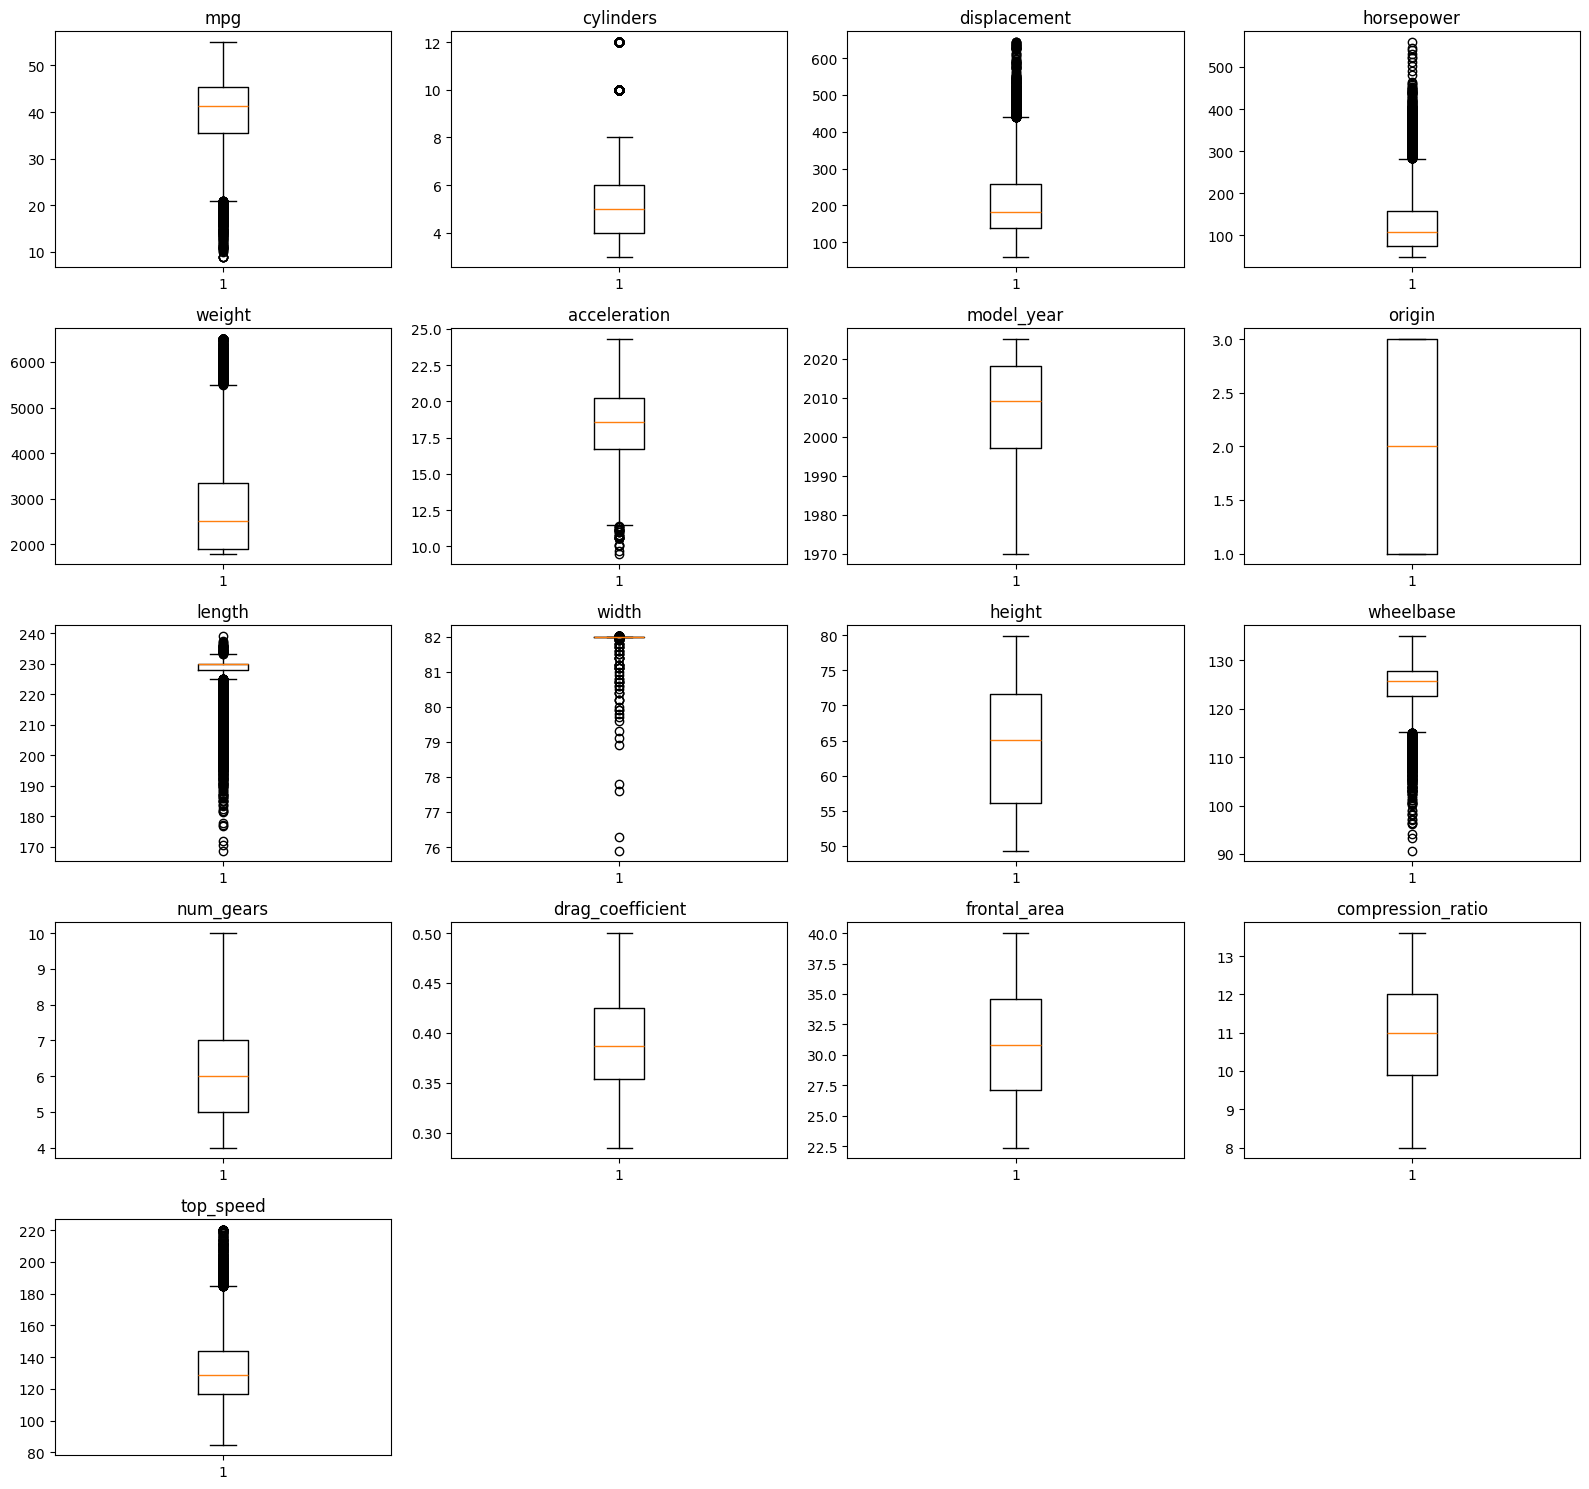

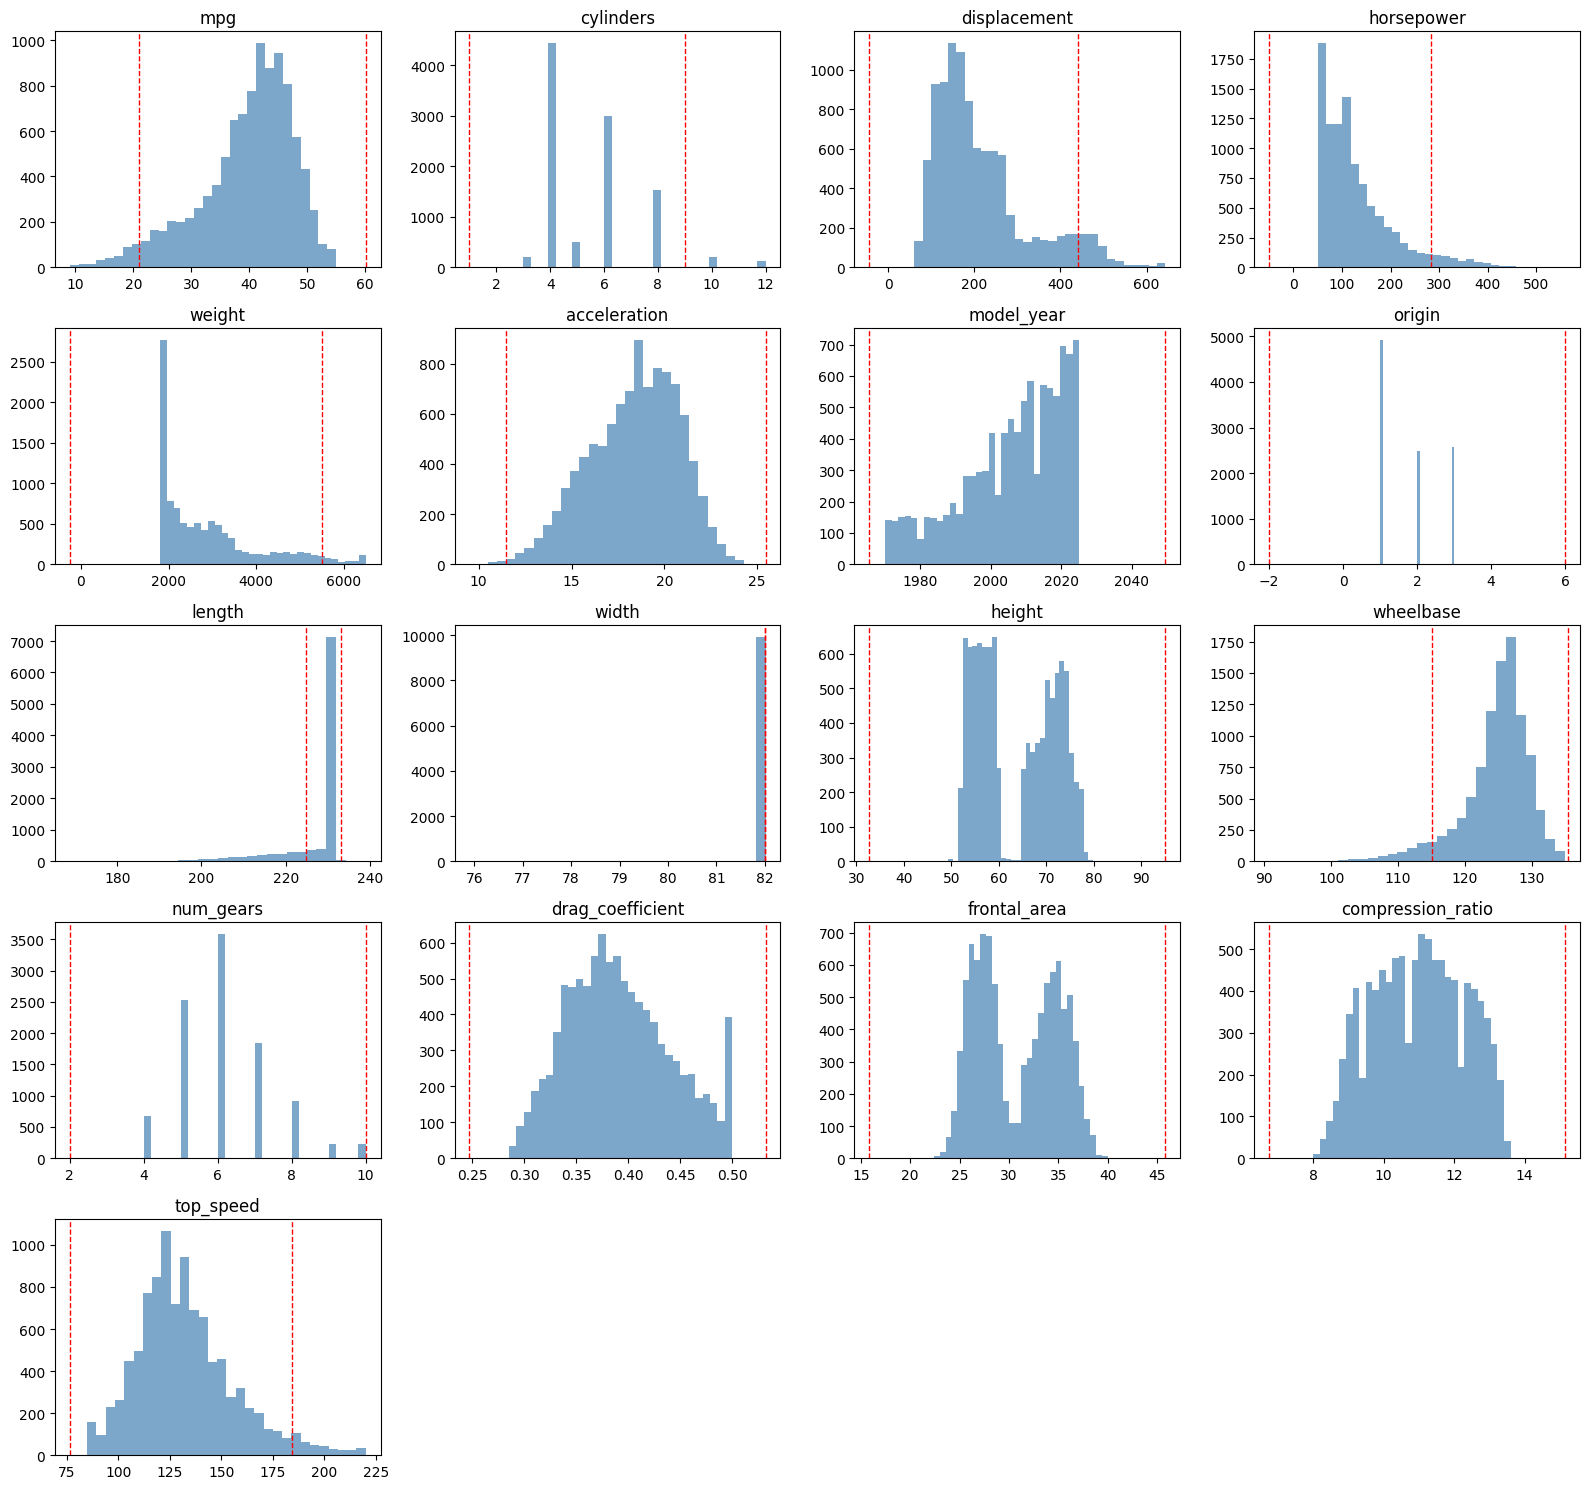

In [482]:
# Method 1: Statistical Approach (IQR Method)
numeric_cols = df.select_dtypes(include=["number"]).columns

q1 = df[numeric_cols].quantile(0.25)
q3 = df[numeric_cols].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

iqr_flag_matrix = (df[numeric_cols] < lower) | (df[numeric_cols] > upper)
iqr_flag_count = iqr_flag_matrix.sum(axis=1)
iqr_outlier_mask = iqr_flag_count > 0

iqr_outliers = df[iqr_outlier_mask].copy()
iqr_outliers["outlier_reason"] = iqr_flag_matrix.loc[iqr_outlier_mask].apply(
    lambda row: ",".join(row.index[row].tolist()), axis=1
)
print("iqr_outlier_rows", int(iqr_outlier_mask.sum()))
iqr_outliers.head()

# Plots: Boxplots and histograms with IQR bounds
cols = list(numeric_cols)
ncols = 4
nrows = int(np.ceil(len(cols) / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows))
axes = np.array(axes).reshape(-1)
for i, col in enumerate(cols):
    data = df[col].dropna().to_numpy()
    axes[i].boxplot(data, vert=True)
    axes[i].set_title(col)
for j in range(i + 1, len(axes)):
    axes[j].axis("off")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows))
axes = np.array(axes).reshape(-1)
for i, col in enumerate(cols):
    data = df[col].dropna().to_numpy()
    axes[i].hist(data, bins=30, color="steelblue", alpha=0.7)
    if col in lower.index and col in upper.index:
        axes[i].axvline(lower[col], color="red", linestyle="--", linewidth=1)
        axes[i].axvline(upper[col], color="red", linestyle="--", linewidth=1)
    axes[i].set_title(col)
for j in range(i + 1, len(axes)):
    axes[j].axis("off")
plt.tight_layout()
plt.show()


## 7.3.2 Method 2: Domain Knowledge
**Reason:** Encode expert rules for valid extremes.

physically_impossible_rows 0
domain_keep_rows 12769
domain_review_rows 0


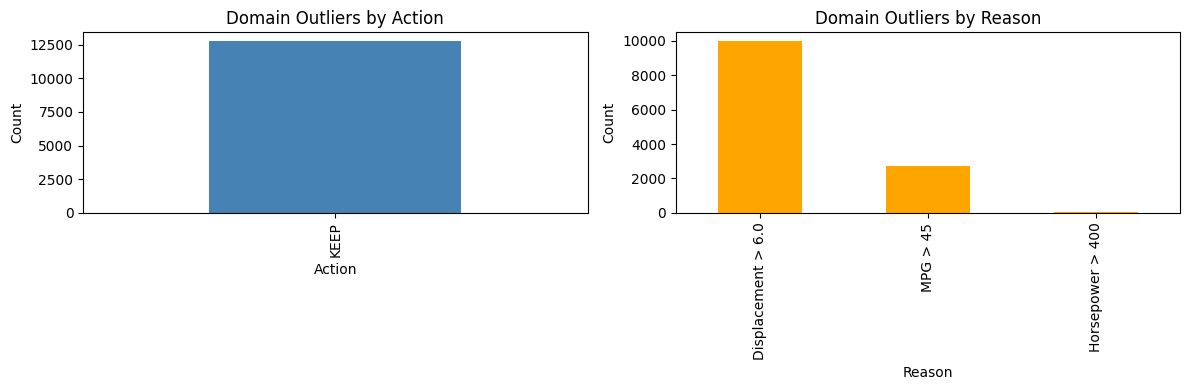

In [483]:
# Method 2: Domain Knowledge Approach
numeric_cols = df.select_dtypes(include=["number"]).columns

# Physically impossible values (REPORT ONLY; removal handled earlier)
is_electric = False
if "engine_type" in df.columns:
    is_electric = is_electric | df["engine_type"].astype(str).str.contains("electric", case=False, na=False)
if "fuel_system" in df.columns:
    is_electric = is_electric | df["fuel_system"].astype(str).str.contains("electric", case=False, na=False)

negative_mask = (df[numeric_cols] < 0).any(axis=1)
mpg_mask = False
if "mpg" in df.columns:
    mpg_mask = (df["mpg"] < 5) | ((df["mpg"] > 100) & ~is_electric)

physically_impossible_mask = negative_mask | mpg_mask
physically_impossible_count = int(physically_impossible_mask.sum())
print("physically_impossible_rows", physically_impossible_count)

# Domain rules (KEEP or REVIEW)
domain_flags = []
if "mpg" in df.columns:
    mask = df["mpg"] > 45
    domain_flags.append((mask, "MPG > 45", "KEEP"))
if "weight" in df.columns:
    mask = df["weight"] < 1800
    domain_flags.append((mask, "Weight < 1800", "REVIEW"))
if "horsepower" in df.columns:
    mask = df["horsepower"] > 400
    domain_flags.append((mask, "Horsepower > 400", "KEEP"))
if "displacement" in df.columns:
    mask = df["displacement"] > 6.0
    domain_flags.append((mask, "Displacement > 6.0", "KEEP"))

domain_outliers = []
for mask, reason, action in domain_flags:
    if mask.any():
        temp = df.loc[mask].copy()
        temp["domain_reason"] = reason
        temp["domain_action"] = action
        domain_outliers.append(temp)

if domain_outliers:
    domain_outliers = pd.concat(domain_outliers, ignore_index=True)
else:
    domain_outliers = df.iloc[0:0].copy()

print("domain_keep_rows", int((domain_outliers["domain_action"] == "KEEP").sum()))
print("domain_review_rows", int((domain_outliers["domain_action"] == "REVIEW").sum()))
domain_outliers.head()

# Visualize domain outliers
if not domain_outliers.empty:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    domain_outliers["domain_action"].value_counts().plot(kind="bar", ax=axes[0], color="steelblue")
    axes[0].set_title("Domain Outliers by Action")
    axes[0].set_xlabel("Action")
    axes[0].set_ylabel("Count")

    domain_outliers["domain_reason"].value_counts().plot(kind="bar", ax=axes[1], color="orange")
    axes[1].set_title("Domain Outliers by Reason")
    axes[1].set_xlabel("Reason")
    axes[1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()


## 7.3.3 Method 3: Z-Score
**Reason:** Standardized distance for multi-feature extremes.

In [484]:
# Method 3: Z-Score Method
numeric_cols = df.select_dtypes(include=["number"]).columns

means = df[numeric_cols].mean()
stds = df[numeric_cols].std().replace(0, np.nan)
z_scores = (df[numeric_cols] - means) / stds
z_flag_count = (z_scores.abs() > 3).sum(axis=1)
z_outlier_mask = z_flag_count >= 2
z_outliers = df[z_outlier_mask].copy()
z_outliers["z_extreme_features"] = z_scores.abs().gt(3).loc[z_outlier_mask].apply(
    lambda row: ",".join(row.index[row].tolist()), axis=1
)
print("zscore_multi_feature_outliers", int(z_outlier_mask.sum()))
z_outliers.head()

# Modified Z-Score for MPG (target)
if "mpg" in df.columns:
    mpg = df["mpg"].astype(float)
    median = mpg.median()
    mad = (mpg - median).abs().median()
    if mad == 0:
        modified_z = pd.Series(0.0, index=mpg.index)
    else:
        modified_z = 0.6745 * (mpg - median) / mad

    mpg_outlier_mask = modified_z.abs() > 3.5
    mpg_outlier_count = int(mpg_outlier_mask.sum())
    mpg_outlier_pct = mpg_outlier_count / len(df) * 100
    print("mpg_modified_z_outliers", mpg_outlier_count, f"({mpg_outlier_pct:.2f}%)")
    df.loc[mpg_outlier_mask, ["mpg"]].head()


zscore_multi_feature_outliers 342
mpg_modified_z_outliers 115 (1.15%)


## 7.3.4 Outlier Treatment
**Method:** Keep or cap extremes (clear errors already removed)
**Reason:** Reduce undue influence while preserving valid signal.

### 7.3.4A Keep Legitimate Extremes
**Reason:** Sports cars/hybrids are valid and informative.

In [485]:
# Method C: Keep legitimate extreme values (flag only)
domain_flags = []
if "mpg" in df.columns:
    domain_flags.append((df["mpg"] > 45, "MPG > 45"))
if "horsepower" in df.columns:
    domain_flags.append((df["horsepower"] > 400, "Horsepower > 400"))
if "displacement" in df.columns:
    domain_flags.append((df["displacement"] > 6.0, "Displacement > 6.0"))

keep_flags = []
for mask, reason in domain_flags:
    if mask.any():
        temp = df.loc[mask].copy()
        temp["keep_reason"] = reason
        keep_flags.append(temp)

if keep_flags:
    keep_outliers = pd.concat(keep_flags, ignore_index=True)
else:
    keep_outliers = df.iloc[0:0].copy()

print("kept_outlier_rows", int(len(keep_outliers)))
keep_outliers.head()


kept_outlier_rows 12769


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,length,...,fuel_system,transmission_type,num_gears,drive_type,drag_coefficient,frontal_area,compression_ratio,top_speed,sub_model_id,keep_reason
0,48.9,4,155.7,98.0,2198,17.4,2004,2,Subaru Hybrid EX,222.8,...,MPFI,Manual,6.0,AWD,0.441,33.6,11.0,127.0,Subaru Hybrid EX|2004|Inline-4|Manual|AWD|6.0|4,MPG > 45
1,46.3,4,106.6,57.0,2145,23.1,2024,2,Tesla Wagon LX,209.6,...,Carburetor,CVT,6.0,FWD,0.326,35.2,10.2,136.0,Tesla Wagon LX|2024|Inline-4|CVT|FWD|6.0|4,MPG > 45
2,45.6,4,118.8,69.0,1924,18.6,1994,3,Jeep Sport LX,228.3,...,GDI,Automatic,6.0,FWD,0.418,27.7,9.7,112.0,Jeep Sport LX|1994|Inline-4|Automatic|FWD|6.0|4,MPG > 45
3,47.0,5,160.5,55.0,1800,18.6,1992,1,Hyundai Crossover Limited,230.0,...,Direct Injection,CVT,5.0,AWD,0.481,27.9,9.1,130.0,Hyundai Crossover Limited|1992|V12|CVT|AWD|5.0|5,MPG > 45
4,49.5,3,87.0,56.0,1800,19.9,1992,2,Audi Sport Sport,193.4,...,GDI,Automatic,8.0,RWD,0.482,30.8,8.8,116.0,Audi Sport Sport|1992|Inline-3|Automatic|RWD|8...,MPG > 45


### 7.3.4B Cap Extremes (5th/95th)
**Reason:** Limit leverage of extreme but plausible values.

In [486]:
# Method D: Cap extremes (5th/95th percentile)
# This updates df in place.
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
cap_cols = [c for c in numeric_cols if c != "mpg"]

lower = df[cap_cols].quantile(0.05)
upper = df[cap_cols].quantile(0.95)
df[cap_cols] = df[cap_cols].clip(lower=lower, upper=upper, axis=1)

print("capped_cols", cap_cols)
df.head()


capped_cols ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'length', 'width', 'height', 'wheelbase', 'num_gears', 'drag_coefficient', 'frontal_area', 'compression_ratio', 'top_speed']


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,length,...,engine_type,fuel_system,transmission_type,num_gears,drive_type,drag_coefficient,frontal_area,compression_ratio,top_speed,sub_model_id
0,48.9,4,155.7,98.0,2198,17.4,2004,2,Subaru Hybrid EX,222.8,...,Inline-4,MPFI,Manual,6.0,AWD,0.441,33.6,11.000000,127.0,Subaru Hybrid EX|2004|Inline-4|Manual|AWD|6.0|4
1,46.3,4,106.6,57.0,2145,21.9,2024,2,Tesla Wagon LX,209.6,...,Inline-4,Carburetor,CVT,6.0,FWD,0.326,35.2,10.200000,136.0,Tesla Wagon LX|2024|Inline-4|CVT|FWD|6.0|4
2,43.4,4,121.2,104.0,2404,18.3,2018,1,Chevrolet Hybrid Sport,230.0,...,Inline-4,MPFI,Automatic,7.0,FWD,0.359,27.6,10.873982,123.0,Chevrolet Hybrid Sport|2018|Inline-4|Automatic...
3,36.5,6,246.3,103.0,3307,19.1,2013,3,Mazda Wagon Limited,230.0,...,Inline-6,MPFI,Automatic,6.0,FWD,0.359,28.8,9.000000,120.0,Mazda Wagon Limited|2013|Inline-6|Automatic|FW...
4,38.6,5,168.9,109.0,2324,18.4,1990,1,Mercedes SUV EX,230.0,...,V12,MPFI,DCT,6.0,FWD,0.397,30.0,11.200000,132.0,Mercedes SUV EX|1990|V12|DCT|FWD|6.0|5


# 7.4 Data Type Corrections
**Method:** Cast numeric columns, set categories
**Reason:** Ensure consistent types for downstream processing.

## 7.4.1 Common Data Type Issues & Fixes

| Issue | Original | Corrected | Reason |
|---|---|---|---|
| Horsepower as object | `"150 hp"` | `150.0` (float) | Extract numeric value |
| Model year as string | `"2020"` | `2020` (int) | Convert for calculations |
| Cylinders as float | `6.0` | `6` (int) | Should be discrete |
| Weight with commas | `"3,500"` | `3500` (int) | Remove formatting |
| Boolean as string | `"Yes"/"No"` | `1/0` | Standardize encoding |


In [487]:
# Data type corrections
# Handle numeric columns with formatting (commas, units)
numeric_cols_expected = [
    "mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration",
    "model_year", "origin", "length", "width", "height", "wheelbase",
    "num_gears", "drag_coefficient", "frontal_area", "compression_ratio", "top_speed"
]
for col in numeric_cols_expected:
    if col in df.columns:
        cleaned = (
            df[col]
            .astype(str)
            .str.replace(',', '', regex=False)
            .str.extract(r'([-+]?\d*\.?\d+)')[0]
        )
        df[col] = pd.to_numeric(cleaned, errors="coerce")

# Integer-like columns
int_cols = ["model_year", "cylinders", "num_gears"]
for col in int_cols:
    if col in df.columns:
        df[col] = df[col].round().astype('Int64')

# Boolean columns encoded as Yes/No, True/False
bool_map = {
    'yes': 1, 'no': 0, 'true': 1, 'false': 0, 'y': 1, 'n': 0, '1': 1, '0': 0
}
for col in df.columns:
    if df[col].dtype == 'object' or str(df[col].dtype).startswith('string'):
        sample = df[col].dropna().astype(str).str.strip().str.lower()
        if not sample.empty and set(sample.unique()).issubset(set(bool_map.keys())):
            df[col] = sample.map(bool_map).reindex(df.index)

# Categorical columns
cat_cols = ["engine_type", "fuel_system", "transmission_type", "drive_type"]
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype("category")

if "car_name" in df.columns:
    df["car_name"] = df["car_name"].astype(str)


In [488]:
# Categorical uniqueness check
cat_cols = df.select_dtypes(include=["object", "category"]).columns
for col in cat_cols:
    unique_count = df[col].nunique(dropna=True)
    print(f"{col}: unique={unique_count}")
    print(df[col].value_counts().head(10))
    print()


car_name: unique=2305
car_name
Hyundai Compact Base    14
Tesla Compact EX        14
Honda Van EX            13
Nissan Van Base         12
Jeep Sport LX           11
Volvo Convertible EX    11
Nissan Sedan EX         11
Nissan Hybrid Sport     11
Dodge SUV GT            11
Ford Sport Sport        11
Name: count, dtype: int64

engine_type: unique=10
engine_type
Inline-4    3767
V6          2125
V8          1433
unknown      600
V12          586
Inline-6     435
Flat-4       401
Flat-6       263
V10          202
Inline-3     187
Name: count, dtype: int64

fuel_system: unique=5
fuel_system
MPFI                3689
GDI                 2432
Carburetor          1509
TBI                 1409
Direct Injection     960
Name: count, dtype: int64

transmission_type: unique=5
transmission_type
Automatic         4985
Manual            1987
CVT               1520
DCT               1008
Semi-Automatic     499
Name: count, dtype: int64

drive_type: unique=4
drive_type
FWD    4571
RWD    2478
AWD    199

C:\Users\Rajesh Khan\AppData\Local\Temp\ipykernel_21572\783945760.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = df.select_dtypes(include=["object", "category"]).columns


# 7.5 Handling Incorrect Values
**Method:** Apply PDF validation rules and set invalid values to NaN for downstream correction/imputation.
**Rules:** MPG, cylinders set, model year, weight, horsepower, acceleration, and displacement ranges.
**Reason:** Prevent corrupt values from biasing analysis.

In [489]:
# Handle incorrect values (validation + correction)
# What: Apply rule-based validation checks and set invalid values to NA.
# Why: Keep records but remove impossible entries before imputation.

if "cleaning_log" not in globals():
    cleaning_log = {}
if "__initial_row_count__" not in globals():
    __initial_row_count__ = len(df)

rule_masks = {}

if "mpg" in df.columns:
    mpg = pd.to_numeric(df["mpg"], errors="coerce")
    rule_masks["mpg_range"] = (mpg < 5) | (mpg > 100)

if "cylinders" in df.columns:
    cyl = pd.to_numeric(df["cylinders"], errors="coerce")
    rule_masks["cylinders_valid"] = ~cyl.isin([3, 4, 5, 6, 8, 10, 12]) & cyl.notna()

if "model_year" in df.columns:
    year = pd.to_numeric(df["model_year"], errors="coerce")
    rule_masks["model_year_range"] = (year < 1970) | (year > 2025)

if "weight" in df.columns:
    weight = pd.to_numeric(df["weight"], errors="coerce")
    rule_masks["weight_range"] = (weight < 1500) | (weight > 8000)

if "horsepower" in df.columns:
    hp = pd.to_numeric(df["horsepower"], errors="coerce")
    rule_masks["horsepower_range"] = (hp < 40) | (hp > 1000)

if "acceleration" in df.columns:
    acc = pd.to_numeric(df["acceleration"], errors="coerce")
    rule_masks["acceleration_range"] = (acc < 2) | (acc > 25)

# Displacement may be liters or larger-scale units in source datasets.
if "displacement" in df.columns:
    disp = pd.to_numeric(df["displacement"], errors="coerce")
    disp_max = disp.dropna().max()
    if pd.notna(disp_max) and disp_max > 20:
        displacement_unit = "large_scale"
        rule_masks["displacement_range"] = (disp < 50) | (disp > 900)
    else:
        displacement_unit = "liter_like"
        rule_masks["displacement_range"] = (disp < 0.8) | (disp > 8.5)
    print("displacement_unit_detected", displacement_unit)

invalid_records = pd.DataFrame()
invalid_rule_counts = {}
total_invalid_marks = 0

if rule_masks:
    invalid_rows_mask = pd.Series(False, index=df.index)

    for rule_name, mask in rule_masks.items():
        mask = mask.fillna(False)
        invalid_rule_counts[rule_name] = int(mask.sum())
        invalid_rows_mask |= mask

        # Set only the corresponding feature to NA; keep row for later imputation.
        if rule_name.startswith("mpg"):
            df.loc[mask, "mpg"] = pd.NA
        elif rule_name.startswith("cylinders"):
            df.loc[mask, "cylinders"] = pd.NA
        elif rule_name.startswith("model_year"):
            df.loc[mask, "model_year"] = pd.NA
        elif rule_name.startswith("weight"):
            df.loc[mask, "weight"] = pd.NA
        elif rule_name.startswith("horsepower"):
            df.loc[mask, "horsepower"] = pd.NA
        elif rule_name.startswith("acceleration"):
            df.loc[mask, "acceleration"] = pd.NA
        elif rule_name.startswith("displacement"):
            df.loc[mask, "displacement"] = pd.NA

    total_invalid_marks = sum(invalid_rule_counts.values())
    invalid_records = df.loc[invalid_rows_mask].copy()

    if not invalid_records.empty:
        for rule_name, mask in rule_masks.items():
            invalid_records[f"invalid_{rule_name}"] = mask.loc[invalid_records.index].fillna(False)

    print("invalid_records_rows", int(invalid_rows_mask.sum()))
    print("invalid_value_marks_set_na", int(total_invalid_marks))
    print(pd.Series(invalid_rule_counts, name="count"))
else:
    print("No validation rules applied (required columns missing).")

cleaning_log["invalid_rule_counts"] = invalid_rule_counts
cleaning_log["invalid_value_marks_set_na"] = int(total_invalid_marks)

invalid_records.head()


displacement_unit_detected large_scale
invalid_records_rows 0
invalid_value_marks_set_na 0
mpg_range             0
cylinders_valid       0
model_year_range      0
weight_range          0
horsepower_range      0
acceleration_range    0
displacement_range    0
Name: count, dtype: int64


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,length,...,engine_type,fuel_system,transmission_type,num_gears,drive_type,drag_coefficient,frontal_area,compression_ratio,top_speed,sub_model_id


## 7.5.1 Remove Clear Data Errors
**Method:** Remove physically impossible values
**Reason:** Preserve data integrity before analysis.

In [490]:
# Method A: Remove clear data entry errors
numeric_cols = df.select_dtypes(include=["number"]).columns

is_electric = False
if "engine_type" in df.columns:
    is_electric = is_electric | df["engine_type"].astype(str).str.contains("electric", case=False, na=False)
if "fuel_system" in df.columns:
    is_electric = is_electric | df["fuel_system"].astype(str).str.contains("electric", case=False, na=False)

negative_mask = (df[numeric_cols] < 0).any(axis=1)
mpg_mask = False
if "mpg" in df.columns:
    mpg_mask = (df["mpg"] < 5) | ((df["mpg"] > 100) & ~is_electric)

clear_error_mask = negative_mask | mpg_mask
print("clear_error_rows", int(clear_error_mask.sum()))
df = df.loc[~clear_error_mask].reset_index(drop=True)


clear_error_rows 0


# 7.6 Standardizing Text Data
**Method:** Trim, lowercase, normalize spaces
**Reason:** Reduce categorical noise from inconsistent text.

In [491]:
# Standardize text data
text_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

print("Before text standardization - unique counts")
for col in text_cols:
    print(f"{col}: unique={df[col].nunique(dropna=True)}")

# Generic cleanup: trim spaces, collapse repeats, lowercase, normalize missing markers
for col in text_cols:
    s = df[col].astype("string").str.strip().str.replace(r"\s+", " ", regex=True).str.lower()
    s = s.replace({"": pd.NA, "nan": pd.NA, "none": pd.NA, "n/a": pd.NA, "na": pd.NA, "?": pd.NA})
    df[col] = s

# car_name standardization
if "car_name" in df.columns:
    car = df["car_name"].astype("string")
    car = car.str.replace(r"\s*\([^)]*\)", "", regex=True)
    car = car.str.replace(r"[^a-z0-9\-\s]", "", regex=True)
    car = car.str.replace(r"\s+", " ", regex=True).str.strip()

    misspellings = {
        r"\btoyta\b": "toyota",
        r"\btyota\b": "toyota",
        r"\bchevorlet\b": "chevrolet",
        r"\bwolkswagen\b": "volkswagen",
        r"\bmercedez\b": "mercedes",
    }
    for pattern, replacement in misspellings.items():
        car = car.str.replace(pattern, replacement, regex=True)

    df["car_name"] = car.replace("", pd.NA)

# engine_type standardization
if "engine_type" in df.columns:
    eng = df["engine_type"].astype("string").str.strip().str.lower()
    eng_key = eng.str.replace(r"[\s\-_]+", "", regex=True)
    eng_map = {
        "v6": "v6",
        "v8": "v8",
        "v10": "v10",
        "v12": "v12",
        "v4": "v4",
        "i4": "inline-4",
        "l4": "inline-4",
        "inline4": "inline-4",
    }
    eng_std = eng_key.map(eng_map)
    eng_fallback = eng.str.replace(r"\s+", " ", regex=True)
    eng_fallback = eng_fallback.str.replace(r"\binline\s*4\b", "inline-4", regex=True)
    df["engine_type"] = eng_std.fillna(eng_fallback)

# fuel_system standardization
if "fuel_system" in df.columns:
    fuel = df["fuel_system"].astype("string").str.strip().str.lower()
    fuel_key = fuel.str.replace(r"[\s\-_]+", "", regex=True)
    fuel_map = {
        "mpfi": "mpfi",
        "mfi": "mpfi",
        "multipoint": "mpfi",
        "multipointfuelinjection": "mpfi",
        "spfi": "spfi",
        "singlepoint": "spfi",
        "singlepointfuelinjection": "spfi",
    }
    fuel_std = fuel_key.map(fuel_map).fillna(fuel.str.replace(r"\s+", " ", regex=True))

    # Consolidate rare categories (<1%)
    freq = fuel_std.value_counts(normalize=True, dropna=True)
    rare = freq[freq < 0.01].index
    fuel_std = fuel_std.where(~fuel_std.isin(rare), "other")
    df["fuel_system"] = fuel_std

# Re-cast known categorical columns
cat_cols = ["engine_type", "fuel_system", "transmission_type", "drive_type"]
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype("category")

print("After text standardization - unique counts")
for col in text_cols:
    print(f"{col}: unique={df[col].nunique(dropna=True)}")


C:\Users\Rajesh Khan\AppData\Local\Temp\ipykernel_21572\3742787460.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  text_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()


Before text standardization - unique counts
car_name: unique=2305
engine_type: unique=10
fuel_system: unique=5
transmission_type: unique=5
drive_type: unique=4
After text standardization - unique counts
car_name: unique=2305
engine_type: unique=10
fuel_system: unique=5
transmission_type: unique=5
drive_type: unique=4


# 7.7 Handling Date/Time Issues
**Method:** Parse date-like columns and flag invalids
**Reason:** Ensure temporal fields are usable and valid.

In [492]:
# Handle date/time issues
if "cleaning_log" not in globals():
    cleaning_log = {}

current_year = pd.Timestamp.today().year
production_start_year = 1886

if "model_year" in df.columns:
    y = pd.to_numeric(df["model_year"], errors="coerce")
    two_digit_mask = y.between(0, 99, inclusive="both")

    y_fixed = y.copy()
    y_fixed.loc[two_digit_mask & (y >= 30)] = 1900 + y.loc[two_digit_mask & (y >= 30)]
    y_fixed.loc[two_digit_mask & (y < 30)] = 2000 + y.loc[two_digit_mask & (y < 30)]

    pre_production_mask = y_fixed.notna() & (y_fixed < production_start_year)
    future_year_mask = y_fixed.notna() & (y_fixed > current_year)
    invalid_year_mask = pre_production_mask | future_year_mask

    y_fixed.loc[invalid_year_mask] = pd.NA
    df["model_year"] = pd.Series(y_fixed).round().astype("Int64")

    print("two_digit_years_converted", int(two_digit_mask.sum()))
    print("pre_production_year_rows", int(pre_production_mask.sum()))
    print("future_year_rows", int(future_year_mask.sum()))
    print("model_year_set_na", int(invalid_year_mask.sum()))

    cleaning_log["two_digit_years_converted"] = int(two_digit_mask.sum())
    cleaning_log["model_year_set_na"] = int(invalid_year_mask.sum())

# Parse true date/time columns if present
date_cols = [c for c in df.columns if ("date" in c.lower() or "time" in c.lower()) and c != "model_year"]
date_invalid_counts = {}
for col in date_cols:
    parsed = pd.to_datetime(df[col], errors="coerce")
    date_invalid_counts[col] = int(parsed.isna().sum())
    df[col] = parsed
    print(f"{col}: invalid_dates={date_invalid_counts[col]}")

if date_invalid_counts:
    cleaning_log["date_invalid_counts"] = date_invalid_counts


two_digit_years_converted 0
pre_production_year_rows 0
future_year_rows 0
model_year_set_na 0


# 7.8 Data Cleaning Summary Checklist
**Method:** Consolidate validation-rule outcomes, missingness status, and final schema checks.
**Reason:** Confirm readiness before Section 8 data manipulation.


In [493]:
# 7.8 Data Cleaning Summary (computed from df)
if "cleaning_log" not in globals():
    cleaning_log = {}

total_rows = len(df)
initial_rows = int(globals().get('__initial_row_count__', total_rows))
rows_removed_total = max(initial_rows - total_rows, 0)

missing_total = int(df.isna().sum().sum())
remaining_missing_cols = int((df.isna().sum() > 0).sum())

summary_rows = [
    ("rows_initial", initial_rows),
    ("rows_current", total_rows),
    ("rows_removed_total", rows_removed_total),
    ("exact_duplicates_removed", int(cleaning_log.get("exact_duplicates_removed", 0))),
    ("submodel_duplicates_removed", int(cleaning_log.get("submodel_duplicates_removed", 0))),
    ("conflicting_spec_groups_flagged", int(cleaning_log.get("conflicting_spec_groups", 0))),
    ("invalid_value_marks_set_na", int(cleaning_log.get("invalid_value_marks_set_na", 0))),
    ("model_year_set_na", int(cleaning_log.get("model_year_set_na", 0))),
    ("remaining_missing_total", missing_total),
    ("remaining_missing_columns", remaining_missing_cols),
]

section7_summary = pd.DataFrame(summary_rows, columns=["metric", "value"])
section7_summary

print("\nRule-wise invalid counts:")
print(pd.Series(cleaning_log.get("invalid_rule_counts", {}), dtype="int64"))

print("\nDataFrame quick check:")
df.info()
df.describe(include='all').T.head(15)



Rule-wise invalid counts:
mpg_range             0
cylinders_valid       0
model_year_range      0
weight_range          0
horsepower_range      0
acceleration_range    0
displacement_range    0
dtype: int64

DataFrame quick check:
<class 'pandas.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   mpg                9999 non-null   float64 
 1   cylinders          9999 non-null   Int64   
 2   displacement       9999 non-null   float64 
 3   horsepower         9999 non-null   float64 
 4   weight             9999 non-null   float64 
 5   acceleration       9999 non-null   float64 
 6   model_year         9999 non-null   Int64   
 7   origin             9999 non-null   int64   
 8   car_name           9999 non-null   string  
 9   length             9999 non-null   float64 
 10  width              9999 non-null   float64 
 11  height             9999 non-nu

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
mpg,9999.0,NaN,NaN,NaN,39.615422,8.1112,9.0,35.6,41.2,45.4,55.0
cylinders,9999.0,<NA>,<NA>,<NA>,5.393139,1.510964,4.0,4.0,5.0,6.0,8.0
displacement,9999.0,NaN,NaN,NaN,213.153765,102.378408,96.19,137.5,180.7,258.5,457.91
horsepower,9999.0,NaN,NaN,NaN,125.767577,66.741592,50.0,75.0,109.0,158.0,294.0
weight,9999.0,NaN,NaN,NaN,2838.928793,1084.830186,1800.0,1902.0,2511.0,3341.5,5344.0
acceleration,9999.0,NaN,NaN,NaN,18.386379,2.242527,14.1,16.7,18.6,20.2,21.9
model_year,9999.0,<NA>,<NA>,<NA>,2006.114411,14.003447,1977.0,1997.0,2009.0,2018.0,2024.0
origin,9999.0,NaN,NaN,NaN,1.764576,0.833739,1.0,1.0,2.0,3.0,3.0
car_name,9999,2305,hyundai compact base,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
length,9999.0,NaN,NaN,NaN,226.872396,6.252636,208.8,227.95015,230.0,230.0,230.0


# 8. Data Manipulation Techniques
**Note:** Step order follows the PDF (`8.1` to `8.11`), with `8.12` as the notebook-to-document alignment checkpoint.


# 8.1 Feature Scaling & Normalization
**Method:** Standardization, Min-Max Scaling, Robust Scaling in separate cells.
**Reason:** Prepare feature ranges for different model families.

In [495]:
# Method 1: Standardization (Z-Score Normalization)
# This updates df in place using raw backups to avoid cumulative re-scaling.

if "_scaling_backup_cols" not in globals():
    _scaling_backup_cols = [
        c for c in df.select_dtypes(include=["number"]).columns
        if c != "mpg" and not c.endswith("_raw") and not c.startswith("pca_")
    ]
    for c in _scaling_backup_cols:
        raw_col = f"{c}_raw"
        if raw_col not in df.columns:
            df[raw_col] = df[c]

std_features = ["horsepower", "displacement", "weight", "acceleration"]
std_features = [c for c in std_features if c in df.columns]

if std_features:
    source_cols = [f"{c}_raw" if f"{c}_raw" in df.columns else c for c in std_features]
    standard_scaler = StandardScaler()
    df[std_features] = standard_scaler.fit_transform(df[source_cols])

std_check = df[std_features].agg(["mean", "std"]).T if std_features else pd.DataFrame()
std_check


,mean,std
horsepower,-5.045358e-17,1.00005
displacement,5.223011e-17,1.00005
weight,9.984124e-17,1.00005
acceleration,3.858633e-16,1.00005


In [496]:
# Method 2: Min-Max Scaling
# This updates df in place using raw backups to avoid cumulative re-scaling.

minmax_features = [
    c for c in df.select_dtypes(include=["number"]).columns
    if c != "mpg" and not c.endswith("_raw") and not c.startswith("pca_")
]

if minmax_features:
    source_cols = [f"{c}_raw" if f"{c}_raw" in df.columns else c for c in minmax_features]
    minmax_scaler = MinMaxScaler()
    df[minmax_features] = minmax_scaler.fit_transform(df[source_cols])

minmax_check = pd.DataFrame({
    "min": df[minmax_features].min(),
    "max": df[minmax_features].max(),
}) if minmax_features else pd.DataFrame()
minmax_check


,min,max
cylinders,0.0,1.0
displacement,0.0,1.0
horsepower,0.0,1.0
weight,0.0,1.0
acceleration,0.0,1.0
model_year,0.0,1.0
origin,0.0,1.0
length,0.0,1.0
width,0.0,0.0
height,0.0,1.0


In [497]:
# Method 3: Robust Scaling
# This updates df in place using raw backups to avoid cumulative re-scaling.

robust_features = [
    c for c in df.select_dtypes(include=["number"]).columns
    if c != "mpg" and not c.endswith("_raw") and not c.startswith("pca_")
]

if robust_features:
    source_cols = [f"{c}_raw" if f"{c}_raw" in df.columns else c for c in robust_features]
    robust_scaler = RobustScaler()
    df[robust_features] = robust_scaler.fit_transform(df[source_cols])

robust_check = pd.DataFrame({
    "median": df[robust_features].median(),
    "q1": df[robust_features].quantile(0.25),
    "q3": df[robust_features].quantile(0.75),
}) if robust_features else pd.DataFrame()
robust_check


,median,q1,q3
cylinders,0.0,-0.500000,0.500000
displacement,0.0,-0.357025,0.642975
horsepower,0.0,-0.409639,0.590361
weight,0.0,-0.423064,0.576936
acceleration,0.0,-0.542857,0.457143
model_year,0.0,-0.571429,0.428571
origin,0.0,-0.500000,0.500000
length,0.0,-1.000000,0.000000
width,0.0,0.000000,0.000000
height,0.0,-0.577574,0.422426


# 8.2 Encoding Categorical Variables

## Encoding Strategy Matrix
| Feature | Categories | Method | Reason |
|---|---:|---|---|
| `origin` | 3 (usa, europe, asia) | One-Hot Encoding | No ordinal relationship |
| `engine_type` | 6+ (v6, inline-4, v8, ...) | One-Hot Encoding | Nominal categories |
| `transmission_type` | 5 (manual, automatic, cvt, dct, semi-automatic) | One-Hot Encoding | No ordering |
| `fuel_system` | 4 (carburetor, tbi, mpfi, gdi) | Label Encoding | Slight technological ordering |
| `drive_type` | 3 (fwd, rwd, awd) | One-Hot Encoding | No ordinal relationship |
| `cylinders` | 7 (3,4,5,6,8,10,12) | Keep as numeric | Already ordinal |


In [498]:
# Apply label encoding directly on df
# Keep cylinders numeric (ordinal)
if "cylinders" in df.columns:
    df["cylinders"] = pd.to_numeric(df["cylinders"], errors="coerce")

# Label Encoding for fuel_system with domain-aware ordering
# carburetor -> tbi -> mpfi -> gdi (older to newer technology)
fuel_order = {
    "carburetor": 0,
    "tbi": 1,
    "mpfi": 2,
    "gdi": 3,
    "direct injection": 3,
}

if "fuel_system" in df.columns:
    fuel_series = df["fuel_system"].astype("string").str.lower().str.strip()
    df["fuel_system"] = fuel_series.map(fuel_order)
    if df["fuel_system"].isna().any():
        # Fallback for rare/unmapped values
        df["fuel_system"] = df["fuel_system"].fillna(1)
    df["fuel_system"] = df["fuel_system"].astype(int)

df[["fuel_system", "cylinders"]].head()


,fuel_system,cylinders
0,2,-0.5
1,0,-0.5
2,2,-0.5
3,2,0.5
4,2,0.0


In [499]:
# One-Hot Encoding implementation for nominal features (in-place on df)
one_hot_cols = ["origin", "engine_type", "transmission_type", "drive_type"]
one_hot_cols = [c for c in one_hot_cols if c in df.columns]

df = pd.get_dummies(
    df,
    columns=one_hot_cols,
    prefix=one_hot_cols,
    drop_first=False,
    dtype=int,
)

print('Encoded shape:', df.shape)
print('Remaining object/category columns:', df.select_dtypes(include=["object", "category"]).columns.tolist())
df.head()


Encoded shape: (9999, 41)
Remaining object/category columns: []


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,car_name,length,width,...,engine_type_v8,transmission_type_automatic,transmission_type_cvt,transmission_type_dct,transmission_type_manual,transmission_type_semi-automatic,drive_type_4wd,drive_type_awd,drive_type_fwd,drive_type_rwd
0,48.9,-0.5,-0.206612,-0.132530,-0.217437,-0.342857,-0.238095,subaru hybrid ex,-3.512452,0.0,...,0,0,0,0,1,0,0,1,0,0
1,46.3,-0.5,-0.612397,-0.626506,-0.254255,0.942857,0.714286,tesla wagon lx,-9.951947,0.0,...,0,0,1,0,0,0,0,0,1,0
2,43.4,-0.5,-0.491736,-0.060241,-0.074331,-0.085714,0.428571,chevrolet hybrid sport,0.000000,0.0,...,0,1,0,0,0,0,0,0,1,0
3,36.5,0.5,0.542149,-0.072289,0.552970,0.142857,0.190476,mazda wagon limited,0.000000,0.0,...,0,1,0,0,0,0,0,0,1,0
4,38.6,0.0,-0.097521,0.000000,-0.129906,-0.057143,-0.904762,mercedes suv ex,0.000000,0.0,...,0,0,0,1,0,0,0,0,1,0


# 8.3 Feature Transformation
**Method:** Log transform for right-skewed features and Yeo-Johnson for left-skewed features.
**Reason:** Improve feature distribution shape before downstream modeling.


In [500]:
# Transform: log for right-skewed distributions
numeric_cols = df.select_dtypes(include=["number"]).columns
skewness = df[numeric_cols].skew()
right_skewed = skewness[skewness > 1].index.tolist()

log_shifts = {}
for col in right_skewed:
    series = df[col]
    min_val = series.min()
    shift = 0
    if min_val <= 0:
        shift = abs(min_val) + 1
    log_shifts[col] = shift
    df[f"{col}_log1p"] = np.log1p(series + shift)

print("log_transformed_cols", right_skewed)
log_shifts


log_transformed_cols ['displacement', 'horsepower', 'weight', 'origin_0.0', 'origin_0.5', 'engine_type_flat-4', 'engine_type_flat-6', 'engine_type_inline-3', 'engine_type_inline-6', 'engine_type_unknown', 'engine_type_v10', 'engine_type_v12', 'engine_type_v6', 'engine_type_v8', 'transmission_type_cvt', 'transmission_type_dct', 'transmission_type_manual', 'transmission_type_semi-automatic', 'drive_type_4wd', 'drive_type_awd', 'drive_type_rwd']


{'displacement': np.float64(1.6984297520661156),
 'horsepower': np.float64(1.7108433734939759),
 'weight': np.float64(1.4939215005210142),
 'origin_0.0': np.int64(1),
 'origin_0.5': np.int64(1),
 'engine_type_flat-4': np.int64(1),
 'engine_type_flat-6': np.int64(1),
 'engine_type_inline-3': np.int64(1),
 'engine_type_inline-6': np.int64(1),
 'engine_type_unknown': np.int64(1),
 'engine_type_v10': np.int64(1),
 'engine_type_v12': np.int64(1),
 'engine_type_v6': np.int64(1),
 'engine_type_v8': np.int64(1),
 'transmission_type_cvt': np.int64(1),
 'transmission_type_dct': np.int64(1),
 'transmission_type_manual': np.int64(1),
 'transmission_type_semi-automatic': np.int64(1),
 'drive_type_4wd': np.int64(1),
 'drive_type_awd': np.int64(1),
 'drive_type_rwd': np.int64(1)}

In [501]:
# Transform: Yeo-Johnson for left-skewed distributions
numeric_cols = df.select_dtypes(include=["number"]).columns
skewness = df[numeric_cols].skew()
left_skewed = skewness[skewness < -1].index.tolist()

left_transform_lambdas = {}
for col in left_skewed:
    series = df[col].astype(float)
    pt = PowerTransformer(method="yeo-johnson", standardize=False)
    transformed = pt.fit_transform(series.to_frame())
    df[f"{col}_yj"] = transformed.ravel()
    left_transform_lambdas[col] = float(pt.lambdas_[0])

print("left_skew_transformed_cols", left_skewed)
left_transform_lambdas


left_skew_transformed_cols ['length']


{'length': 3.8006258315290147}

# 8.4 Handling Skewed Distributions
**Method:** Distribution profiling and skewness diagnostics after feature transformations.
**Reason:** Verify skew mitigation results and identify residual high-skew features.


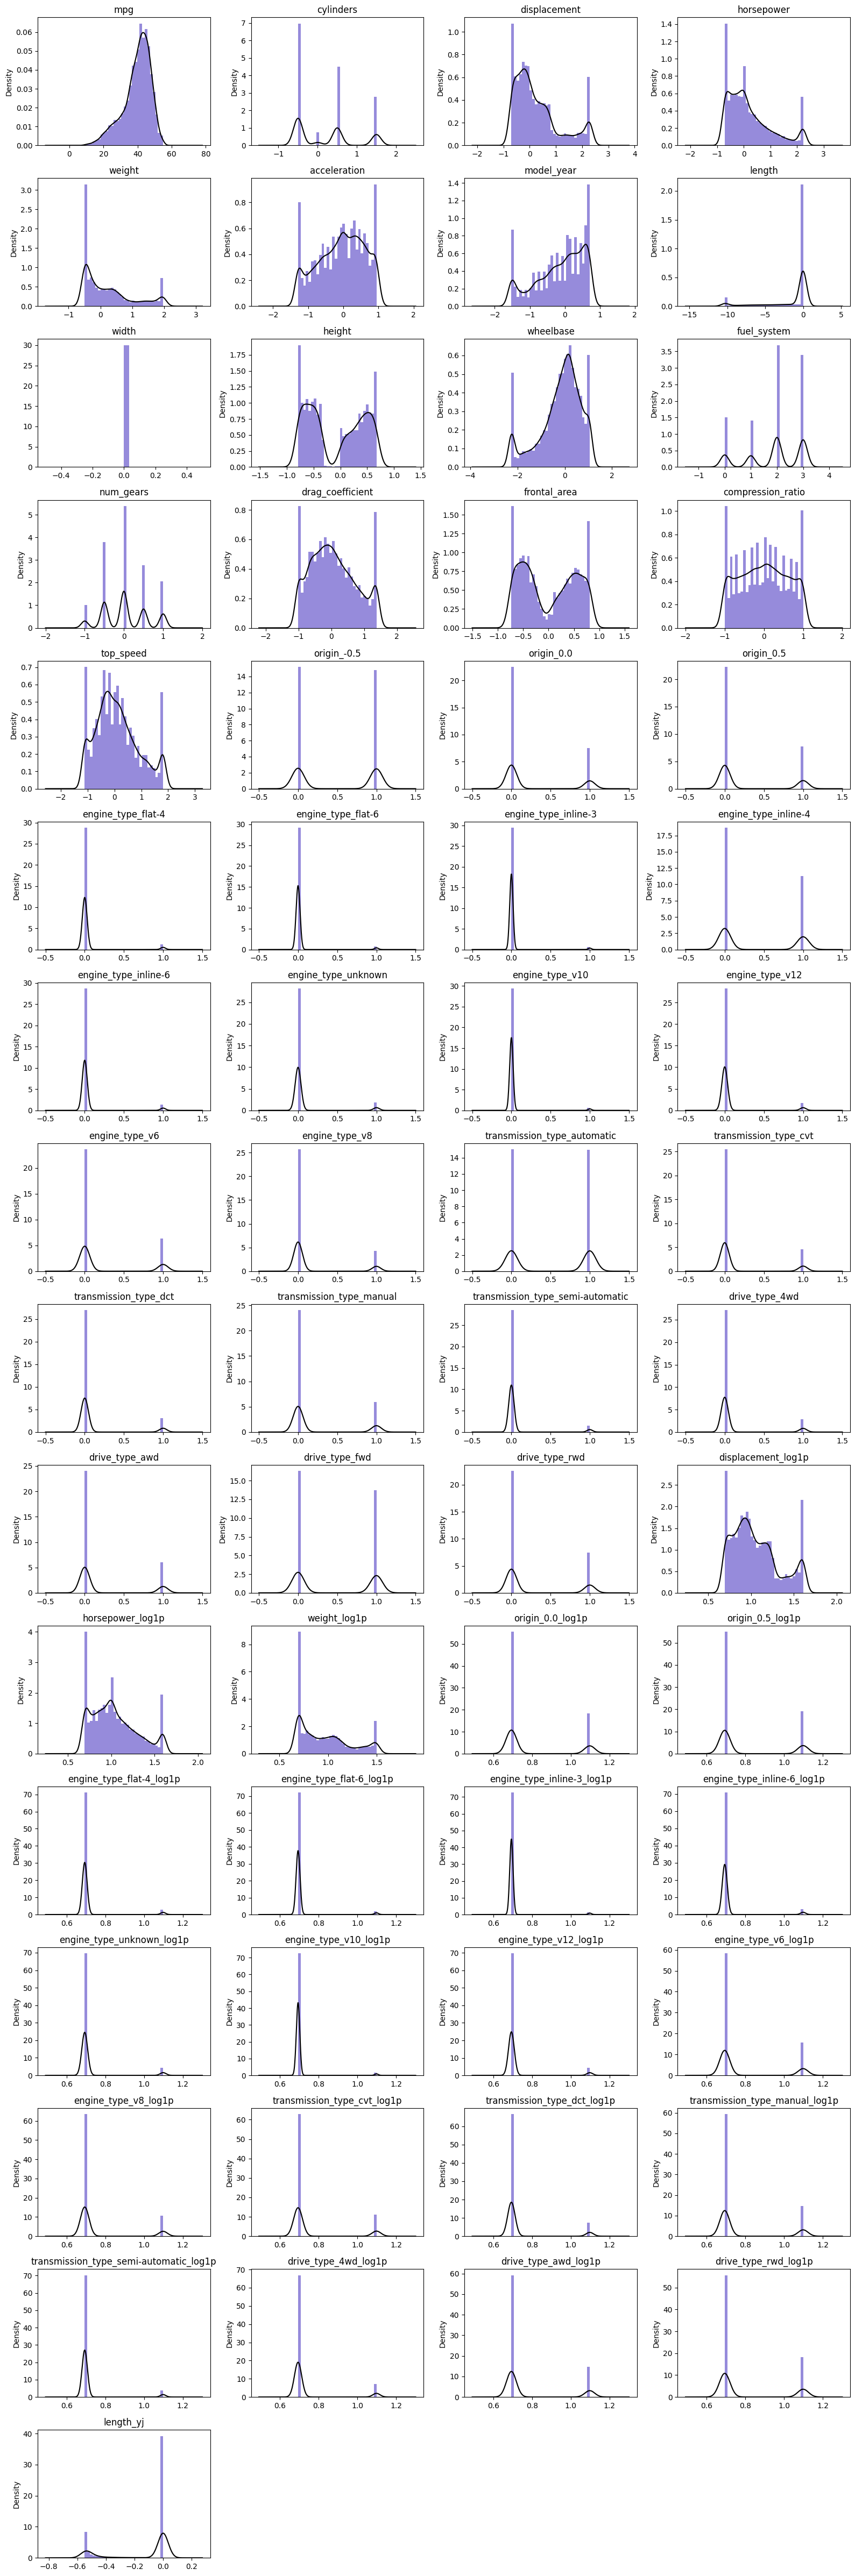

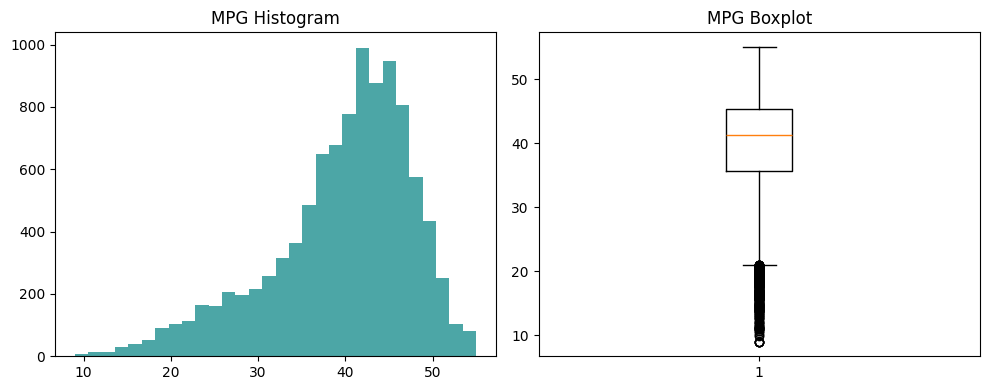

In [502]:
# Numeric distribution summary
numeric_cols = df.select_dtypes(include=["number"]).columns
dist_summary = df[numeric_cols].describe().T
dist_summary["skew"] = df[numeric_cols].skew()
dist_summary["kurtosis"] = df[numeric_cols].kurt()
dist_summary

# Categorical distribution (top 10)
cat_cols = df.select_dtypes(include=["object"]).columns
for col in cat_cols:
    print(f"\n{col} value counts (top 10)")
    print(df[col].value_counts().head(10))

# Distribution plots for numeric features
cols = list(numeric_cols)
ncols = 4
nrows = int(np.ceil(len(cols) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows))
axes = np.array(axes).reshape(-1)
for i, col in enumerate(cols):
    series = pd.to_numeric(df[col], errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    axes[i].hist(series, bins=30, color="slateblue", alpha=0.7, density=True)

    # KDE fails on singular/constant data; only draw when variance is meaningful.
    if series.nunique() > 1 and float(series.std()) > 0:
        try:
            series.plot(kind="density", ax=axes[i], color="black")
        except Exception:
            pass

    axes[i].set_title(col)
for j in range(i + 1, len(axes)):
    axes[j].axis("off")
plt.tight_layout()
plt.show()

# Target distribution (mpg)
if "mpg" in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].hist(df["mpg"].dropna(), bins=30, color="teal", alpha=0.7)
    axes[0].set_title("MPG Histogram")
    axes[1].boxplot(df["mpg"].dropna(), vert=True)
    axes[1].set_title("MPG Boxplot")
    plt.tight_layout()
    plt.show()


In [503]:
# Skewness test for all numeric features
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()

if numeric_cols:
    skew_series = df[numeric_cols].skew()

    def skew_level(val):
        a = abs(val)
        if a < 0.5:
            return "approximately_symmetric"
        if a < 1.0:
            return "moderately_skewed"
        return "highly_skewed"

    skew_df = pd.DataFrame({
        "feature": skew_series.index,
        "skewness": skew_series.values,
    })
    skew_df["direction"] = np.where(skew_df["skewness"] > 0, "right", "left")
    skew_df.loc[skew_df["skewness"] == 0, "direction"] = "none"
    skew_df["level"] = skew_df["skewness"].apply(skew_level)
    skew_df["abs_skew"] = skew_df["skewness"].abs()
    skew_df = skew_df.sort_values("abs_skew", ascending=False).reset_index(drop=True)

    print("numeric_feature_count", len(numeric_cols))
    print("highly_skewed_count", int((skew_df["level"] == "highly_skewed").sum()))
    print("moderately_skewed_count", int((skew_df["level"] == "moderately_skewed").sum()))
    print("approximately_symmetric_count", int((skew_df["level"] == "approximately_symmetric").sum()))

    skew_df
else:
    print("No numeric features found for skewness test.")


numeric_feature_count 61
highly_skewed_count 41
moderately_skewed_count 10
approximately_symmetric_count 10


# 8.5 Creating Derived Features
**Method:** Domain-driven ratio and efficiency feature creation  
**Reason:** Capture non-linear automotive relationships that raw features miss.


In [504]:
# 8.5 Derived features
def _src_col(col):
    raw_col = f"{col}_raw"
    return raw_col if raw_col in df.columns else col

if set(["horsepower", "weight"]).issubset(df.columns):
    hp = pd.to_numeric(df[_src_col("horsepower")], errors="coerce")
    wt = pd.to_numeric(df[_src_col("weight")], errors="coerce")
    df["power_to_weight_ratio"] = hp / wt.replace(0, np.nan)

if set(["displacement", "cylinders"]).issubset(df.columns):
    disp = pd.to_numeric(df[_src_col("displacement")], errors="coerce")
    cyl = pd.to_numeric(df[_src_col("cylinders")], errors="coerce")
    df["displacement_per_cylinder"] = disp / cyl.replace(0, np.nan)

if set(["drag_coefficient", "frontal_area"]).issubset(df.columns):
    cd = pd.to_numeric(df[_src_col("drag_coefficient")], errors="coerce")
    fa = pd.to_numeric(df[_src_col("frontal_area")], errors="coerce")
    df["aerodynamic_efficiency"] = cd * fa

if set(["displacement", "cylinders", "compression_ratio"]).issubset(df.columns):
    disp = pd.to_numeric(df[_src_col("displacement")], errors="coerce")
    cyl = pd.to_numeric(df[_src_col("cylinders")], errors="coerce")
    comp = pd.to_numeric(df[_src_col("compression_ratio")], errors="coerce")
    df["engine_breathing_index"] = disp / (cyl.replace(0, np.nan) * comp.replace(0, np.nan))

if set(["length", "width", "height"]).issubset(df.columns):
    l = pd.to_numeric(df[_src_col("length")], errors="coerce")
    w = pd.to_numeric(df[_src_col("width")], errors="coerce")
    h = pd.to_numeric(df[_src_col("height")], errors="coerce")
    df["vehicle_size_index"] = l * w * h

tech_parts = pd.DataFrame(index=df.index)
if "fuel_system" in df.columns and pd.api.types.is_numeric_dtype(df["fuel_system"]):
    fs = pd.to_numeric(df["fuel_system"], errors="coerce")
    rng = fs.max() - fs.min()
    tech_parts["fuel_system_norm"] = (fs - fs.min()) / (rng if pd.notna(rng) and rng != 0 else 1)
if "num_gears" in df.columns:
    ng = pd.to_numeric(df[_src_col("num_gears")], errors="coerce")
    rng = ng.max() - ng.min()
    tech_parts["num_gears_norm"] = (ng - ng.min()) / (rng if pd.notna(rng) and rng != 0 else 1)
if "model_year" in df.columns:
    yr = pd.to_numeric(df[_src_col("model_year")], errors="coerce")
    rng = yr.max() - yr.min()
    tech_parts["model_year_norm"] = (yr - yr.min()) / (rng if pd.notna(rng) and rng != 0 else 1)

if not tech_parts.empty:
    df["technology_score"] = tech_parts.mean(axis=1)

derived_cols = [
    c for c in [
        "power_to_weight_ratio", "displacement_per_cylinder", "aerodynamic_efficiency",
        "engine_breathing_index", "vehicle_size_index", "technology_score"
    ] if c in df.columns
]
print("derived_feature_cols", derived_cols)
df[derived_cols].head() if derived_cols else pd.DataFrame()


derived_feature_cols ['power_to_weight_ratio', 'displacement_per_cylinder', 'aerodynamic_efficiency', 'engine_breathing_index', 'vehicle_size_index', 'technology_score']


,power_to_weight_ratio,displacement_per_cylinder,aerodynamic_efficiency,engine_breathing_index,vehicle_size_index,technology_score
0,0.609512,0.413223,0.283259,NaN,-0.0,0.580378
1,2.464086,1.224793,-0.502821,-3.215083,-0.0,0.500000
2,0.810438,0.983471,0.167857,-16.388842,-0.0,0.763002
3,-0.130729,1.084298,0.104911,-1.138512,-0.0,0.644208
4,-0.000000,NaN,-0.014987,NaN,-0.0,0.481087


# 8.6 Binning & Discretization
**Method:** Domain-informed bins for year, weight, and horsepower  
**Reason:** Improve interpretability and capture non-linear segment effects.


In [505]:
# 8.6 Binning and discretization
year_col = "model_year_raw" if "model_year_raw" in df.columns else "model_year"
weight_col = "weight_raw" if "weight_raw" in df.columns else "weight"
hp_col = "horsepower_raw" if "horsepower_raw" in df.columns else "horsepower"

if year_col in df.columns:
    y = pd.to_numeric(df[year_col], errors="coerce")
    df["model_year_bin"] = pd.cut(
        y,
        bins=[1969, 1979, 1989, 1999, 2009, 2019, 2035],
        labels=["1970s", "1980s", "1990s", "2000s", "2010s", "2020s+"],
    )

if weight_col in df.columns:
    w = pd.to_numeric(df[weight_col], errors="coerce")
    df["weight_category"] = pd.cut(
        w,
        bins=[-np.inf, 2500, 3000, 3500, 4500, np.inf],
        labels=["lightweight", "compact", "midsize", "large", "heavy"],
    )

if hp_col in df.columns:
    hp = pd.to_numeric(df[hp_col], errors="coerce")
    df["horsepower_category"] = pd.cut(
        hp,
        bins=[-np.inf, 100, 150, 250, 400, np.inf],
        labels=["economy", "standard", "performance", "high_performance", "super"],
    )

for c in ["model_year_bin", "weight_category", "horsepower_category"]:
    if c in df.columns:
        print(c)
        print(df[c].value_counts(dropna=False))
        print()


model_year_bin
model_year_bin
NaN       9999
1970s        0
1980s        0
1990s        0
2000s        0
2010s        0
2020s+       0
Name: count, dtype: int64

weight_category
weight_category
lightweight    9999
compact           0
midsize           0
large             0
heavy             0
Name: count, dtype: int64

horsepower_category
horsepower_category
economy             9999
standard               0
performance            0
high_performance       0
super                  0
Name: count, dtype: int64



# 8.7 Handling Multicollinearity
**Method:** Correlation matrix + high-correlation pair analysis (`|r| > 0.85`)  
**Reason:** Reduce redundancy and instability in linear models.


In [506]:
# 8.7 Multicollinearity analysis
numeric_cols = [
    c for c in df.select_dtypes(include=["number"]).columns
    if c != "mpg" and not c.endswith("_raw") and not c.startswith("pca_")
]

corr_matrix = df[numeric_cols].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_pairs = (
    upper.stack().reset_index()
    .rename(columns={"level_0": "feature_1", "level_1": "feature_2", 0: "abs_corr"})
)
high_corr_pairs = high_corr_pairs[high_corr_pairs["abs_corr"] > 0.85].sort_values("abs_corr", ascending=False)

print("high_corr_pair_count", int(len(high_corr_pairs)))
high_corr_pairs.head(20)

# Optional drop strategy (keep False by default; review first)
apply_multicollinearity_drop = False
multicollinearity_drop_cols = []

if {"displacement", "cylinders"}.issubset(set(df.columns)):
    if not high_corr_pairs.empty:
        cond = (
            ((high_corr_pairs["feature_1"] == "displacement") & (high_corr_pairs["feature_2"] == "cylinders"))
            | ((high_corr_pairs["feature_1"] == "cylinders") & (high_corr_pairs["feature_2"] == "displacement"))
        )
        if cond.any():
            multicollinearity_drop_cols.append("displacement")

if apply_multicollinearity_drop and multicollinearity_drop_cols:
    df = df.drop(columns=[c for c in multicollinearity_drop_cols if c in df.columns])

print("recommended_drop_cols", list(dict.fromkeys(multicollinearity_drop_cols)))
print("apply_multicollinearity_drop", apply_multicollinearity_drop)


high_corr_pair_count 32
recommended_drop_cols ['displacement']
apply_multicollinearity_drop False


# 8.8 Temporal Feature Engineering
**Method:** Create age/era/time-trend features from `model_year`  
**Reason:** Capture technology progression and vehicle-age effects.


In [507]:
# 8.8 Temporal features
year_col = "model_year_raw" if "model_year_raw" in df.columns else "model_year"

if year_col in df.columns:
    y = pd.to_numeric(df[year_col], errors="coerce")
    current_year = pd.Timestamp.today().year

    df["vehicle_age"] = current_year - y
    df["vehicle_age"] = df["vehicle_age"].clip(lower=0)

    df["era_class"] = pd.cut(
        y,
        bins=[-np.inf, 1974, 1989, 2009, np.inf],
        labels=["pre_regulation", "early_efficiency", "modern_efficiency", "advanced_technology"],
    )

    y_min, y_max = y.min(), y.max()
    denom = (y_max - y_min) if pd.notna(y_max) and pd.notna(y_min) and (y_max - y_min) != 0 else 1
    df["technology_adoption_rate"] = (y - y_min) / denom

df[[c for c in ["vehicle_age", "era_class", "technology_adoption_rate"] if c in df.columns]].head()


,vehicle_age,era_class,technology_adoption_rate
0,2026.238095,pre_regulation,0.574468
1,2025.285714,pre_regulation,1.000000
2,2025.571429,pre_regulation,0.872340
3,2025.809524,pre_regulation,0.765957
4,2026.904762,pre_regulation,0.276596


# 8.9 Dimensionality Reduction (PCA)
**Method:** Standardize numeric features and apply PCA for 95% variance  
**Reason:** Reduce dimensionality and multicollinearity while preserving information.


In [508]:
# 8.9 PCA

# Encode new categorical bins/eras into df (in place)
new_cat_cols = [c for c in ["model_year_bin", "weight_category", "horsepower_category", "era_class"] if c in df.columns]
for col in new_cat_cols:
    dummies = pd.get_dummies(df[col], prefix=col, dtype=int)
    for dc in dummies.columns:
        if dc not in df.columns:
            df[dc] = dummies[dc]

pca_feature_cols = [
    c for c in df.select_dtypes(include=["number"]).columns
    if c != "mpg" and not c.endswith("_raw") and not c.startswith("pca_")
]

X_pca_input = df[pca_feature_cols].copy()
X_pca_input = X_pca_input.fillna(X_pca_input.median(numeric_only=True))

pca_scaler = StandardScaler()
X_pca_scaled = pca_scaler.fit_transform(X_pca_input)

pca_model = PCA(n_components=0.95, random_state=42)
X_pca = pca_model.fit_transform(X_pca_scaled)
pca_explained_variance_sum = float(pca_model.explained_variance_ratio_.sum())

# Remove old PCA columns and refresh
old_pca_cols = [c for c in df.columns if c.startswith("pca_")]
if old_pca_cols:
    df = df.drop(columns=old_pca_cols)

pca_cols = [f"pca_{i+1}" for i in range(X_pca.shape[1])]
for i, col in enumerate(pca_cols):
    df[col] = X_pca[:, i]

print("pca_input_features", len(pca_feature_cols))
print("pca_components", len(pca_cols))
print("pca_explained_variance_sum", round(pca_explained_variance_sum, 4))
df[pca_cols].head()


pca_input_features 88
pca_components 27
pca_explained_variance_sum 0.952


,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,...,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27
0,-2.409477,-1.049601,-0.141803,-0.798030,3.033617,-3.087063,-2.305354,-0.273418,-0.153854,0.833072,...,0.476105,1.384358,0.108151,-0.376752,0.954273,-0.243855,-0.003502,0.420460,0.650990,0.441787
1,-3.645496,1.895770,-2.043177,-1.352641,1.275215,-0.260430,-1.464273,1.558119,3.478336,-0.084656,...,1.467029,1.298234,0.801008,-0.406443,-1.805894,2.165033,-0.983741,-0.929130,-1.494246,-0.380405
2,-1.701669,1.935983,-0.293749,-0.401486,-0.376554,0.109306,1.554039,0.651931,-0.720519,-1.140972,...,0.498213,-0.348882,-0.462190,0.930344,0.225865,-0.995710,-0.990842,0.529440,0.468200,0.465305
3,0.723620,0.966411,0.815056,1.843472,-1.847429,-0.114535,-0.320489,-2.025267,-0.098577,-3.803589,...,-0.870992,-0.477688,0.158384,-0.673324,0.263715,1.521635,-1.140755,0.289243,0.031238,-1.415946
4,-0.496009,-1.518039,-0.868928,-1.185372,-1.903172,-0.399107,2.112981,-1.087087,-2.392789,0.397805,...,1.337467,-0.672855,-0.691350,-0.343218,-0.614572,-0.282493,0.228845,0.027287,0.032263,-0.155002


In [509]:
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,car_name,length,width,...,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27
0,48.9,-0.5,-0.206612,-0.132530,-0.217437,-0.342857,-0.238095,subaru hybrid ex,-3.512452,0.0,...,0.476105,1.384358,0.108151,-0.376752,0.954273,-0.243855,-0.003502,0.420460,0.650990,0.441787
1,46.3,-0.5,-0.612397,-0.626506,-0.254255,0.942857,0.714286,tesla wagon lx,-9.951947,0.0,...,1.467029,1.298234,0.801008,-0.406443,-1.805894,2.165033,-0.983741,-0.929130,-1.494246,-0.380405
2,43.4,-0.5,-0.491736,-0.060241,-0.074331,-0.085714,0.428571,chevrolet hybrid sport,0.000000,0.0,...,0.498213,-0.348882,-0.462190,0.930344,0.225865,-0.995710,-0.990842,0.529440,0.468200,0.465305
3,36.5,0.5,0.542149,-0.072289,0.552970,0.142857,0.190476,mazda wagon limited,0.000000,0.0,...,-0.870992,-0.477688,0.158384,-0.673324,0.263715,1.521635,-1.140755,0.289243,0.031238,-1.415946
4,38.6,0.0,-0.097521,0.000000,-0.129906,-0.057143,-0.904762,mercedes suv ex,0.000000,0.0,...,1.337467,-0.672855,-0.691350,-0.343218,-0.614572,-0.282493,0.228845,0.027287,0.032263,-0.155002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,27.9,1.5,2.290992,2.228916,1.878430,-0.542857,0.619048,honda wagon dx,0.000000,0.0,...,1.181509,-0.817733,-1.048989,0.001371,-0.632675,-0.587425,0.534196,0.705940,0.832993,-0.137511
9995,43.2,-0.5,-0.193388,-0.036145,-0.299410,-0.171429,0.666667,mercedes wagon premium,0.000000,0.0,...,-1.656165,2.103166,0.831146,0.831171,0.446114,-1.269284,0.128727,-1.517401,-1.680820,0.300851
9996,47.6,-0.5,-0.698430,-0.710843,-0.493922,0.542857,0.714286,chrysler sport limited,-10.342219,0.0,...,0.779810,-0.437280,-0.750761,-0.641887,0.597242,1.906250,0.535525,0.523048,0.536814,-1.076136
9997,45.0,-0.5,-0.451240,-0.554217,-0.444599,0.171429,-0.190476,toyota van lx,-4.146645,0.0,...,0.723644,0.913406,0.744658,0.085966,-0.566314,0.721276,0.870953,-0.058452,0.142654,1.359891


# 8.10 Train-Test Split Strategy
**Method:** 70/15/15 split with MPG stratification  
**Reason:** Balanced evaluation across target ranges and stable validation.


In [510]:
# 8.10 Stratified train/validation/test split

drop_id_cols = [c for c in ["car_name", "sub_model_id"] if c in df.columns]
df_model_input = df.drop(columns=drop_id_cols).copy()

# Avoid target leakage: exclude target-derived MPG ratio features from training.
target_leakage_cols = [c for c in df_model_input.columns if c.startswith("mpg_per_")]
if target_leakage_cols:
    df_model_input = df_model_input.drop(columns=target_leakage_cols)
    print("Dropped target-derived leakage features:", target_leakage_cols)

cat_cols = df_model_input.select_dtypes(include=["object", "category", "string"]).columns.tolist()
if cat_cols:
    df_model_input = pd.get_dummies(df_model_input, columns=cat_cols, drop_first=False, dtype=int)

if "mpg" not in df_model_input.columns:
    raise ValueError("Target column 'mpg' not found for split.")

y_all = pd.to_numeric(df_model_input["mpg"], errors="coerce")
X_all = df_model_input.drop(columns=["mpg"])
X_all = X_all.apply(pd.to_numeric, errors="coerce")
X_all = X_all.fillna(X_all.median(numeric_only=True))

mpg_strata = pd.qcut(y_all, q=10, labels=False, duplicates="drop")

X_train, X_temp, y_train, y_temp, strata_train, strata_temp = train_test_split(
    X_all, y_all, mpg_strata,
    test_size=0.30, random_state=42, stratify=mpg_strata
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50, random_state=42, stratify=strata_temp
)

print("X_train", X_train.shape, "X_val", X_val.shape, "X_test", X_test.shape)
print("y_train", y_train.shape, "y_val", y_val.shape, "y_test", y_test.shape)


X_train (6999, 135) X_val (1500, 135) X_test (1500, 135)
y_train (6999,) y_val (1500,) y_test (1500,)


# 8.11 Cross-Validation Strategy
**Method:** 5-fold Stratified CV using MPG bins  
**Reason:** More robust performance estimate than a single split.


In [511]:
# 8.11 Stratified K-Fold CV (baseline: Linear Regression)

cv_bins = pd.qcut(y_train, q=5, labels=False, duplicates="drop")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_rows = []
for fold, (tr_idx, va_idx) in enumerate(cv.split(X_train, cv_bins), start=1):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

    model = LinearRegression()
    model.fit(X_tr, y_tr)
    pred = model.predict(X_va)

    rmse = float(np.sqrt(mean_squared_error(y_va, pred)))
    mae = float(mean_absolute_error(y_va, pred))
    r2 = float(r2_score(y_va, pred))

    cv_rows.append({"fold": fold, "rmse": rmse, "mae": mae, "r2": r2})

cv_results = pd.DataFrame(cv_rows)
cv_summary = pd.DataFrame({
    "metric": ["rmse", "mae", "r2"],
    "mean": [cv_results["rmse"].mean(), cv_results["mae"].mean(), cv_results["r2"].mean()],
    "std": [cv_results["rmse"].std(), cv_results["mae"].std(), cv_results["r2"].std()],
})

print("Fold-wise CV metrics")
print(cv_results)
print("CV summary (mean ? std)")
cv_summary


Fold-wise CV metrics
   fold      rmse       mae        r2
0     1  3.131238  2.474520  0.849997
1     2  3.073052  2.453260  0.864024
2     3  3.110816  2.479627  0.854144
3     4  3.154448  2.528369  0.844079
4     5  3.091227  2.469159  0.854632
CV summary (mean ? std)


,metric,mean,std
0,rmse,3.112156,0.032100
1,mae,2.480987,0.028273
2,r2,0.853375,0.007304


# 9.1 Advanced Feature Creation
**Method:** Build PDF-aligned ratio/domain features on train split and apply the same transform to validation/test.  
**Reason:** Keep feature creation leakage-safe by avoiding full-dataset mutation.


In [513]:
# 9.1 Advanced Feature Creation (train-only transform)

def _fe_col(frame, base_col):
    raw_col = f"{base_col}_raw"
    if raw_col in frame.columns:
        return raw_col
    if base_col in frame.columns:
        return base_col
    return None

def _fe_num(frame, base_col):
    col = _fe_col(frame, base_col)
    if col is None:
        return pd.Series(np.nan, index=frame.index, dtype="float64")
    return pd.to_numeric(frame[col], errors="coerce")

def _fe_safe_div(num, den):
    return num / den.replace(0, np.nan)

def add_advanced_features(frame):
    out = frame.copy()
    created = []

    hp = _fe_num(out, "horsepower")
    wt = _fe_num(out, "weight")
    disp = _fe_num(out, "displacement")
    cyl = _fe_num(out, "cylinders")
    length = _fe_num(out, "length")
    width = _fe_num(out, "width")
    height = _fe_num(out, "height")
    wheelbase = _fe_num(out, "wheelbase")
    frontal_area = _fe_num(out, "frontal_area")
    drag_coeff = _fe_num(out, "drag_coefficient")
    compression_ratio = _fe_num(out, "compression_ratio")

    # Target-derived MPG ratios are intentionally not created here (leakage-safe training design).
    if _fe_col(out, "horsepower") and _fe_col(out, "displacement"):
        out["horsepower_per_liter"] = _fe_safe_div(hp, disp)
        created.append("horsepower_per_liter")

    if _fe_col(out, "weight") and _fe_col(out, "horsepower"):
        out["weight_per_horsepower"] = _fe_safe_div(wt, hp)
        created.append("weight_per_horsepower")

    if _fe_col(out, "torque") and _fe_col(out, "displacement"):
        torque = _fe_num(out, "torque")
        out["torque_per_displacement"] = _fe_safe_div(torque, disp)
        created.append("torque_per_displacement")
    elif _fe_col(out, "horsepower") and _fe_col(out, "displacement"):
        assumed_peak_power_rpm = 4500.0
        estimated_torque = hp * 5252.0 / assumed_peak_power_rpm
        out["estimated_torque_per_displacement"] = _fe_safe_div(estimated_torque, disp)
        created.append("estimated_torque_per_displacement")

    if _fe_col(out, "length") and _fe_col(out, "width"):
        out["length_to_width_ratio"] = _fe_safe_div(length, width)
        created.append("length_to_width_ratio")

    if _fe_col(out, "height") and _fe_col(out, "wheelbase"):
        out["height_to_wheelbase_ratio"] = _fe_safe_div(height, wheelbase)
        created.append("height_to_wheelbase_ratio")

    if _fe_col(out, "frontal_area") and _fe_col(out, "length") and _fe_col(out, "height"):
        out["frontal_area_shape_ratio"] = _fe_safe_div(frontal_area, (length * height))
        created.append("frontal_area_shape_ratio")

    if _fe_col(out, "weight") and _fe_col(out, "horsepower") and _fe_col(out, "compression_ratio"):
        if "weight_per_horsepower" not in out.columns:
            out["weight_per_horsepower"] = _fe_safe_div(wt, hp)
        out["brake_specific_fuel_consumption_est"] = _fe_safe_div(
            pd.to_numeric(out["weight_per_horsepower"], errors="coerce"),
            compression_ratio,
        )
        created.append("brake_specific_fuel_consumption_est")

    if _fe_col(out, "weight"):
        rr_base = wt / 1000.0
        drive_cols = [c for c in out.columns if c.startswith("drive_type_")]
        if drive_cols:
            rr_coeff = pd.Series(0.011, index=out.index, dtype="float64")
            for c in drive_cols:
                key = c.replace("drive_type_", "").lower()
                coeff = {"fwd": 0.010, "rwd": 0.011, "awd": 0.012}.get(key, 0.011)
                rr_coeff = rr_coeff + pd.to_numeric(out[c], errors="coerce").fillna(0) * (coeff - 0.011)
            out["rolling_resistance_indicator"] = rr_base * rr_coeff
        else:
            out["rolling_resistance_indicator"] = rr_base * 0.011
        created.append("rolling_resistance_indicator")

    if _fe_col(out, "drag_coefficient") and _fe_col(out, "frontal_area"):
        out["aerodynamic_score"] = drag_coeff * frontal_area
        created.append("aerodynamic_score")

    for col in created:
        out[col] = pd.to_numeric(out[col], errors="coerce").replace([np.inf, -np.inf], np.nan)

    return out, created

X_train_fe, section_9_1_features = add_advanced_features(X_train)
X_val_fe, _ = add_advanced_features(X_val)
X_test_fe, _ = add_advanced_features(X_test)

# Align eval splits to train columns and impute with train-only medians.
X_val_fe = X_val_fe.reindex(columns=X_train_fe.columns)
X_test_fe = X_test_fe.reindex(columns=X_train_fe.columns)

train_medians_91 = X_train_fe.median(numeric_only=True)
X_train_fe = X_train_fe.fillna(train_medians_91)
X_val_fe = X_val_fe.fillna(train_medians_91)
X_test_fe = X_test_fe.fillna(train_medians_91)

print("section_9_1_created", section_9_1_features)
print("X_train_fe", X_train_fe.shape, "X_val_fe", X_val_fe.shape, "X_test_fe", X_test_fe.shape)
X_train_fe[section_9_1_features].head() if section_9_1_features else pd.DataFrame()


section_9_1_created ['horsepower_per_liter', 'weight_per_horsepower', 'estimated_torque_per_displacement', 'length_to_width_ratio', 'height_to_wheelbase_ratio', 'frontal_area_shape_ratio', 'brake_specific_fuel_consumption_est', 'rolling_resistance_indicator', 'aerodynamic_score']
X_train_fe (6999, 144) X_val_fe (1500, 144) X_test_fe (1500, 144)


,horsepower_per_liter,weight_per_horsepower,estimated_torque_per_displacement,length_to_width_ratio,height_to_wheelbase_ratio,frontal_area_shape_ratio,brake_specific_fuel_consumption_est,rolling_resistance_indicator,aerodynamic_score
9113,0.657498,1.409661,0.767373,NaN,-10.364246,-0.199566,-13.543404,-5.417853e-06,-0.499824
9063,1.291749,0.648369,1.507615,NaN,-1.102457,-0.199566,6.807870,-4.210490e-06,0.040672
9991,1.067171,0.732062,1.245507,NaN,-2.010508,-0.199566,-0.809121,-5.433137e-06,0.136009
5068,-1.808988,-0.176368,-2.111290,NaN,0.664502,-0.199566,0.617290,-3.612365e-07,-0.142379
2147,1.017774,0.694839,1.187855,NaN,-0.469593,-0.137881,-0.694839,-5.927058e-06,0.051519


# 9.2 Interaction Features
**Method:** Create PDF-aligned interaction terms on `X_train_fe` and apply to `X_val_fe`/`X_test_fe`.  
**Reason:** Preserve train-first transformation flow and prevent data leakage.


In [514]:
# 9.2 Interaction Features (train-only transform)

def _fe_col_92(frame, base_col):
    raw_col = f"{base_col}_raw"
    if raw_col in frame.columns:
        return raw_col
    if base_col in frame.columns:
        return base_col
    return None

def _fe_num_92(frame, base_col):
    col = _fe_col_92(frame, base_col)
    if col is None:
        return pd.Series(np.nan, index=frame.index, dtype="float64")
    return pd.to_numeric(frame[col], errors="coerce")

def add_interaction_features(frame):
    out = frame.copy()
    created = []

    year = _fe_num_92(out, "model_year")
    hp = _fe_num_92(out, "horsepower")
    wt = _fe_num_92(out, "weight")
    disp = _fe_num_92(out, "displacement")
    cyl = _fe_num_92(out, "cylinders")
    length = _fe_num_92(out, "length")
    width = _fe_num_92(out, "width")
    height = _fe_num_92(out, "height")
    wheelbase = _fe_num_92(out, "wheelbase")
    frontal_area = _fe_num_92(out, "frontal_area")

    if _fe_col_92(out, "weight") and _fe_col_92(out, "horsepower"):
        out["weight_x_horsepower"] = wt * hp
        created.append("weight_x_horsepower")

    if "technology_score" in out.columns and _fe_col_92(out, "model_year"):
        out["model_year_x_technology_score"] = year * pd.to_numeric(out["technology_score"], errors="coerce")
        created.append("model_year_x_technology_score")

    if "fuel_system" in out.columns and _fe_col_92(out, "model_year"):
        out["model_year_x_fuel_system"] = year * pd.to_numeric(out["fuel_system"], errors="coerce")
        created.append("model_year_x_fuel_system")

    if _fe_col_92(out, "num_gears") and _fe_col_92(out, "model_year"):
        gears = _fe_num_92(out, "num_gears")
        out["model_year_x_num_gears"] = year * gears
        created.append("model_year_x_num_gears")

    if _fe_col_92(out, "cylinders") and _fe_col_92(out, "displacement"):
        out["cylinders_x_displacement"] = cyl * disp
        created.append("cylinders_x_displacement")

    origin_cols = [c for c in out.columns if c.startswith("origin_")]
    for col in origin_cols:
        interaction_col = f"{col}_x_model_year"
        out[interaction_col] = pd.to_numeric(out[col], errors="coerce") * year
        created.append(interaction_col)

    if _fe_col_92(out, "length") and _fe_col_92(out, "width"):
        out["length_to_width_interaction"] = length / width.replace(0, np.nan)
        created.append("length_to_width_interaction")

    if _fe_col_92(out, "height") and _fe_col_92(out, "wheelbase"):
        out["height_to_wheelbase_interaction"] = height / wheelbase.replace(0, np.nan)
        created.append("height_to_wheelbase_interaction")

    if _fe_col_92(out, "frontal_area") and _fe_col_92(out, "length") and _fe_col_92(out, "height"):
        out["frontal_area_over_length_height_interaction"] = frontal_area / (length * height).replace(0, np.nan)
        created.append("frontal_area_over_length_height_interaction")

    for col in created:
        out[col] = pd.to_numeric(out[col], errors="coerce").replace([np.inf, -np.inf], np.nan)

    return out, created

X_train_fe, section_9_2_features = add_interaction_features(X_train_fe)
X_val_fe, _ = add_interaction_features(X_val_fe)
X_test_fe, _ = add_interaction_features(X_test_fe)

# Keep evaluation matrices aligned with train columns and fill using train medians only.
X_val_fe = X_val_fe.reindex(columns=X_train_fe.columns)
X_test_fe = X_test_fe.reindex(columns=X_train_fe.columns)

train_medians_92 = X_train_fe.median(numeric_only=True)
X_train_fe = X_train_fe.fillna(train_medians_92)
X_val_fe = X_val_fe.fillna(train_medians_92)
X_test_fe = X_test_fe.fillna(train_medians_92)

# Final modeling matrices after section 9 feature engineering.
X_train_model = X_train_fe.copy()
X_val_model = X_val_fe.copy()
X_test_model = X_test_fe.copy()

print("section_9_2_created_count", len(section_9_2_features))
print("section_9_2_created_preview", section_9_2_features[:20])
print("X_train_model", X_train_model.shape, "X_val_model", X_val_model.shape, "X_test_model", X_test_model.shape)
X_train_model[section_9_2_features].head() if section_9_2_features else pd.DataFrame()


section_9_2_created_count 13
section_9_2_created_preview ['weight_x_horsepower', 'model_year_x_technology_score', 'model_year_x_fuel_system', 'model_year_x_num_gears', 'cylinders_x_displacement', 'origin_-0.5_x_model_year', 'origin_0.0_x_model_year', 'origin_0.5_x_model_year', 'origin_0.0_log1p_x_model_year', 'origin_0.5_log1p_x_model_year', 'length_to_width_interaction', 'height_to_wheelbase_interaction', 'frontal_area_over_length_height_interaction']
X_train_model (6999, 157) X_val_model (1500, 157) X_test_model (1500, 157)


,weight_x_horsepower,model_year_x_technology_score,model_year_x_fuel_system,model_year_x_num_gears,cylinders_x_displacement,origin_-0.5_x_model_year,origin_0.0_x_model_year,origin_0.5_x_model_year,origin_0.0_log1p_x_model_year,origin_0.5_log1p_x_model_year,length_to_width_interaction,height_to_wheelbase_interaction,frontal_area_over_length_height_interaction
9113,0.172090,-0.287065,-1.142857,-0.190476,0.265702,-0.000000,-0.000000,-0.380952,-0.264056,-0.418519,NaN,-10.364246,-0.199566
9063,0.225974,0.015113,0.000000,-0.023810,0.228512,0.000000,0.047619,0.000000,0.052315,0.033007,NaN,-1.102457,-0.199566
9991,0.333248,-0.032956,-0.095238,-0.023810,0.316116,-0.000000,-0.000000,-0.047619,-0.033007,-0.052315,NaN,-2.010508,-0.199566
5068,-0.007399,0.495272,2.000000,-0.333333,0.056612,0.666667,0.000000,0.000000,0.462098,0.462098,NaN,0.664502,-0.199566
2147,0.351101,-0.108240,-0.285714,0.142857,0.349215,-0.000000,-0.285714,-0.000000,-0.313889,-0.198042,NaN,-0.469593,-0.137881


# 9.3 Feature Selection Techniques
**Method:** Train-only staged selection using correlation filter, Random Forest importance, RFE, and Lasso (as suggested in the PDF).  
**Reason:** Reduce redundant/noisy features while keeping predictive signal.


In [515]:
# 9.3 Feature Selection Techniques (train-only)

# Start from post-9.2 features
X_tr = X_train_model.copy()
X_va = X_val_model.copy()
X_te = X_test_model.copy()

y_tr = pd.to_numeric(y_train, errors="coerce")

# Ensure numeric, aligned, and finite
X_tr = X_tr.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
X_va = X_va.reindex(columns=X_tr.columns).apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
X_te = X_te.reindex(columns=X_tr.columns).apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)

train_medians_fs = X_tr.median(numeric_only=True)
X_tr = X_tr.fillna(train_medians_fs)
X_va = X_va.fillna(train_medians_fs)
X_te = X_te.fillna(train_medians_fs)

# Deduplicate columns (can happen when prior cells one-hot encode similar categories more than once)
duplicate_cols = X_tr.columns[X_tr.columns.duplicated()].tolist()
if duplicate_cols:
    X_tr = X_tr.loc[:, ~X_tr.columns.duplicated(keep="first")]
    X_va = X_va.loc[:, ~X_va.columns.duplicated(keep="first")]
    X_te = X_te.loc[:, ~X_te.columns.duplicated(keep="first")]
    X_va = X_va.reindex(columns=X_tr.columns)
    X_te = X_te.reindex(columns=X_tr.columns)

# Remove constant features first
constant_cols = X_tr.columns[X_tr.nunique(dropna=False) <= 1].tolist()
if constant_cols:
    X_tr = X_tr.drop(columns=constant_cols)
    X_va = X_va.drop(columns=constant_cols, errors="ignore")
    X_te = X_te.drop(columns=constant_cols, errors="ignore")

# -----------------------------
# Method 1: Correlation filter
# -----------------------------
min_target_corr = 0.05
high_feature_corr = 0.85

corr_with_target = X_tr.apply(lambda s: s.corr(y_tr)).abs().fillna(0.0)
method1_keep = corr_with_target[corr_with_target >= min_target_corr].index.tolist()

# Fallback if threshold is too strict
if len(method1_keep) < 10:
    method1_keep = corr_with_target.sort_values(ascending=False).head(min(30, len(corr_with_target))).index.tolist()

X_m1 = X_tr[method1_keep].copy()

# Remove highly inter-correlated features
corr_matrix = X_m1.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
method1_drop_high_corr = [col for col in upper.columns if (upper[col] > high_feature_corr).any()]
method1_final = [c for c in method1_keep if c not in method1_drop_high_corr]

if len(method1_final) < 10:
    method1_final = method1_keep[:min(30, len(method1_keep))]

X_m1_tr = X_tr[method1_final]
X_m1_va = X_va[method1_final]
X_m1_te = X_te[method1_final]

# -------------------------------------
# Method 2: RandomForest importance cut
# -------------------------------------
rf_selector = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=1,
)
rf_selector.fit(X_m1_tr, y_tr)

rf_importance = pd.Series(rf_selector.feature_importances_, index=X_m1_tr.columns).sort_values(ascending=False)
rf_cum = rf_importance.cumsum()
method2_keep = rf_cum[rf_cum <= 0.80].index.tolist()

# Include the first feature crossing 80% cumulative importance
if len(method2_keep) < len(rf_importance):
    method2_keep.append(rf_importance.index[len(method2_keep)])

if len(method2_keep) < 10:
    method2_keep = rf_importance.head(min(30, len(rf_importance))).index.tolist()

X_m2_tr = X_m1_tr[method2_keep]
X_m2_va = X_m1_va[method2_keep]
X_m2_te = X_m1_te[method2_keep]

# -----------------------
# Method 3: RFE (RF base)
# -----------------------
n_features_rfe = max(10, int(len(method2_keep) * 0.60))
n_features_rfe = min(n_features_rfe, len(method2_keep))

rfe_base = RandomForestRegressor(
    n_estimators=150,
    random_state=42,
    n_jobs=1,
)
rfe = RFE(estimator=rfe_base, n_features_to_select=n_features_rfe, step=0.10)
rfe.fit(X_m2_tr, y_tr)

method3_keep = X_m2_tr.columns[rfe.support_].tolist()

X_m3_tr = X_m2_tr[method3_keep]
X_m3_va = X_m2_va[method3_keep]
X_m3_te = X_m2_te[method3_keep]

# -------------------------
# Method 4: Lasso selection
# -------------------------
lasso_scaler = StandardScaler()
X_m3_tr_scaled = lasso_scaler.fit_transform(X_m3_tr)

lasso_cv = LassoCV(cv=5, random_state=42, n_jobs=1, max_iter=20000)
lasso_cv.fit(X_m3_tr_scaled, y_tr)

lasso_coef = pd.Series(np.abs(lasso_cv.coef_), index=X_m3_tr.columns)
method4_keep = lasso_coef[lasso_coef > 1e-8].index.tolist()

# Fallback if all coefficients shrink to zero
if not method4_keep:
    method4_keep = method3_keep

# Final selected matrices
selected_features_final = method4_keep
X_train_selected = X_tr[selected_features_final].copy()
X_val_selected = X_va[selected_features_final].copy()
X_test_selected = X_te[selected_features_final].copy()

# Aliases for next modeling steps
X_train_final = X_train_selected.copy()
X_val_final = X_val_selected.copy()
X_test_final = X_test_selected.copy()

selection_summary = pd.DataFrame([
    {"stage": "input_after_9_2", "n_features": X_train_model.shape[1]},
    {"stage": "method1_corr_filter", "n_features": len(method1_final)},
    {"stage": "method2_rf_top80pct", "n_features": len(method2_keep)},
    {"stage": "method3_rfe", "n_features": len(method3_keep)},
    {"stage": "method4_lasso_final", "n_features": len(selected_features_final)},
])

feature_importance_top10 = (
    rf_importance.head(10)
    .reset_index()
    .rename(columns={"index": "feature", 0: "rf_importance"})
)

print("selection_summary")
print(selection_summary)
print("final_feature_count", len(selected_features_final))
print("X_train_final", X_train_final.shape, "X_val_final", X_val_final.shape, "X_test_final", X_test_final.shape)

feature_importance_top10


selection_summary
                 stage  n_features
0      input_after_9_2         157
1  method1_corr_filter          25
2  method2_rf_top80pct          25
3          method3_rfe          15
4  method4_lasso_final          15
final_feature_count 15
X_train_final (6999, 15) X_val_final (1500, 15) X_test_final (1500, 15)


,feature,rf_importance
0,cylinders,0.688251
1,displacement_per_cylinder,0.098017
2,model_year,0.078093
3,pca_11,0.013950
4,pca_22,0.011721
5,pca_3,0.011088
6,weight_x_horsepower,0.010967
7,technology_score,0.010651
8,wheelbase,0.010452
9,compression_ratio,0.010238


# 9.4 Handling Imbalanced Categories
**Method:** Build `sample_weight_train` from inverse MPG-band frequency on `y_train` (train-only), using bands `<=15`, `15-25`, `25-35`, `35-45`, `>45`.  
**Why:** Section 9 notes rare categories/ranges; in this regression setup we address sparsity with target-band weighting so minority MPG bands contribute more during training.  
**Stability controls:** Extreme weights are capped and then re-normalized to mean weight `1.0`.


In [516]:
# 9.4 Handling Imbalanced Target Distribution (train-only)
# Target imbalance handling: inverse-frequency weights by MPG band (computed on train only).

y_train_num = pd.to_numeric(y_train, errors='coerce')

mpg_band_labels = ['<=15', '15-25', '25-35', '35-45', '>45']
mpg_band_bins = [-np.inf, 15, 25, 35, 45, np.inf]

train_mpg_band = pd.cut(y_train_num, bins=mpg_band_bins, labels=mpg_band_labels)
band_counts = train_mpg_band.value_counts(dropna=False).reindex(mpg_band_labels, fill_value=0)

n_train_rows = int(train_mpg_band.notna().sum())
n_bands = len(mpg_band_labels)

# Balanced-style class weight: n_samples / (n_classes * class_count)
band_weight_raw = {
    band: (n_train_rows / (n_bands * float(cnt))) if float(cnt) > 0 else np.nan
    for band, cnt in band_counts.items()
}

band_weight_cap = 8.0
sample_weight_train = train_mpg_band.map(band_weight_raw).astype(float)
sample_weight_train = sample_weight_train.fillna(1.0).clip(upper=band_weight_cap)

# Normalize to keep mean weight at 1.0 for training stability.
mean_w = float(sample_weight_train.mean())
if mean_w > 0:
    sample_weight_train = sample_weight_train / mean_w

sample_weight_train = sample_weight_train.reindex(X_train_final.index).fillna(1.0)
sample_weight_train = pd.Series(sample_weight_train, index=X_train_final.index, dtype='float64')

band_weight_applied = (
    pd.DataFrame({'mpg_band': train_mpg_band, 'sample_weight': sample_weight_train})
    .groupby('mpg_band', observed=False)['sample_weight']
    .mean()
    .reindex(mpg_band_labels)
)

imbalance_weight_summary = pd.DataFrame({
    'mpg_band': mpg_band_labels,
    'count': [int(band_counts[b]) for b in mpg_band_labels],
    'raw_weight': [float(band_weight_raw[b]) if pd.notna(band_weight_raw[b]) else np.nan for b in mpg_band_labels],
    'applied_mean_weight': [float(band_weight_applied[b]) if pd.notna(band_weight_applied[b]) else np.nan for b in mpg_band_labels],
})

print('imbalance_weight_summary')
print(imbalance_weight_summary)
print('sample_weight_train_range', (float(sample_weight_train.min()), float(sample_weight_train.max())))
imbalance_weight_summary


imbalance_weight_summary
  mpg_band  count  raw_weight  applied_mean_weight
0     <=15     53   26.411321             9.296055
1    15-25    439    3.188610             3.705187
2    25-35   1144    1.223601             1.421833
3    35-45   3476    0.402704             0.467945
4      >45   1887    0.741812             0.861991
sample_weight_train_range (0.467945128854276, 9.29605525302165)


,mpg_band,count,raw_weight,applied_mean_weight
0,<=15,53,26.411321,9.296055
1,15-25,439,3.188610,3.705187
2,25-35,1144,1.223601,1.421833
3,35-45,3476,0.402704,0.467945
4,>45,1887,0.741812,0.861991


# 9.5 Post-Selection CV Check
**Method:** Re-run 5-fold stratified CV on `X_train_final` and compare to pre-feature-selection baseline CV.  
**Reason:** Verify whether section 9 feature engineering + selection improves generalization.


In [517]:
# 9.5 Post-Selection CV Check

X_cv = X_train_final.copy()
y_cv = pd.to_numeric(y_train, errors="coerce")

cv_bins_post = pd.qcut(y_cv, q=5, labels=False, duplicates="drop")
cv_post = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows_post = []
for fold, (tr_idx, va_idx) in enumerate(cv_post.split(X_cv, cv_bins_post), start=1):
    X_tr = X_cv.iloc[tr_idx]
    X_va = X_cv.iloc[va_idx]
    y_tr = y_cv.iloc[tr_idx]
    y_va = y_cv.iloc[va_idx]

    model = LinearRegression()

    if "sample_weight_train" in globals():
        sw_tr = sample_weight_train.iloc[tr_idx]
        model.fit(X_tr, y_tr, sample_weight=sw_tr)
    else:
        model.fit(X_tr, y_tr)

    pred = model.predict(X_va)

    rows_post.append({
        "fold": fold,
        "rmse": float(np.sqrt(mean_squared_error(y_va, pred))),
        "mae": float(mean_absolute_error(y_va, pred)),
        "r2": float(r2_score(y_va, pred)),
    })

cv_results_post9 = pd.DataFrame(rows_post)
cv_summary_post9 = pd.DataFrame({
    "metric": ["rmse", "mae", "r2"],
    "mean": [
        cv_results_post9["rmse"].mean(),
        cv_results_post9["mae"].mean(),
        cv_results_post9["r2"].mean(),
    ],
    "std": [
        cv_results_post9["rmse"].std(),
        cv_results_post9["mae"].std(),
        cv_results_post9["r2"].std(),
    ],
})

comparison_cv = pd.DataFrame(columns=["metric", "baseline_mean", "post9_mean", "delta_post_minus_base", "better"]) 
if "cv_summary" in globals() and {"metric", "mean"}.issubset(cv_summary.columns):
    base_map = cv_summary.set_index("metric")["mean"].to_dict()
    post_map = cv_summary_post9.set_index("metric")["mean"].to_dict()

    rows_cmp = []
    for m in ["rmse", "mae", "r2"]:
        base = float(base_map.get(m, np.nan))
        post = float(post_map.get(m, np.nan))
        delta = post - base
        if m in ("rmse", "mae"):
            better = "yes" if delta < 0 else "no"
        else:
            better = "yes" if delta > 0 else "no"
        rows_cmp.append({
            "metric": m,
            "baseline_mean": base,
            "post9_mean": post,
            "delta_post_minus_base": delta,
            "better": better,
        })
    comparison_cv = pd.DataFrame(rows_cmp)

print("Post-9 CV fold-wise metrics")
print(cv_results_post9)
print("Post-9 CV summary (mean ? std)")
print(cv_summary_post9)
print("Baseline vs Post-9 comparison")
comparison_cv


Post-9 CV fold-wise metrics
   fold      rmse       mae        r2
0     1  4.024248  3.233255  0.752237
1     2  3.965240  3.199415  0.773608
2     3  4.030609  3.248599  0.755141
3     4  4.207685  3.353429  0.722575
4     5  4.046737  3.258835  0.750875
Post-9 CV summary (mean ? std)
  metric      mean       std
0   rmse  4.054904  0.090800
1    mae  3.258707  0.057528
2     r2  0.750887  0.018287
Baseline vs Post-9 comparison


,metric,baseline_mean,post9_mean,delta_post_minus_base,better
0,rmse,3.112156,4.054904,0.942748,no
1,mae,2.480987,3.258707,0.777720,no
2,r2,0.853375,0.750887,-0.102488,no


# 10.1 Problem Formulation + 10.2 Model Selection Strategy
### 10.1 Problem Formulation
- This is a **supervised regression** task.
- Input (`X`): selected engineered features (`X_train_final`, `X_val_final`, `X_test_final`).
- Output (`y`): continuous `mpg`.
- Objective: minimize prediction error (`RMSE`, `MAE`) while maximizing explained variance (`R2`).

### 10.2 Model Selection Strategy
**PDF model families:**
- Linear: Linear, Ridge, Lasso, ElasticNet
- Tree/Boosting: Decision Tree, Random Forest, XGBoost, LightGBM, CatBoost
- Other: SVR, KNN, MLP

**Notebook execution set (representative subset):**
- `LinearRegression`, `Ridge`, `ElasticNet`, `RandomForest`, `XGBoost` (`SGBRegressor_XGBoost`)

**Selection rule in this notebook:**
1. Compare candidate models on validation metrics (`RMSE`, `MAE`, `R2`, `MAPE`).
2. Tune XGBoost with randomized search + CV.
3. Refit top candidates on train+validation and choose final model on held-out test performance.


# 10.3 Candidate Model Training + Validation
**Method:** Train multiple regression candidates on `X_train_final` and compare validation metrics.  
**Reason:** Keep XGBoost as preferred target model (per PDF) while validating baselines and challengers.


In [519]:
# 10.3 Candidate Model Training + Validation

def compute_regression_metrics(y_true, y_pred):
    y_true_arr = pd.to_numeric(pd.Series(y_true), errors="coerce").to_numpy(dtype=float)
    y_pred_arr = pd.to_numeric(pd.Series(y_pred), errors="coerce").to_numpy(dtype=float)

    rmse = float(np.sqrt(mean_squared_error(y_true_arr, y_pred_arr)))
    mae = float(mean_absolute_error(y_true_arr, y_pred_arr))
    r2 = float(r2_score(y_true_arr, y_pred_arr))

    nonzero_mask = y_true_arr != 0
    if np.any(nonzero_mask):
        mape = float(np.mean(np.abs((y_true_arr[nonzero_mask] - y_pred_arr[nonzero_mask]) / y_true_arr[nonzero_mask])) * 100)
    else:
        mape = float("nan")

    return {"rmse": rmse, "mae": mae, "r2": r2, "mape": mape}

def fit_with_optional_sample_weight(model, X, y, sample_weight=None):
    if sample_weight is None:
        model.fit(X, y)
        return model

    # Direct sample_weight path
    try:
        model.fit(X, y, sample_weight=sample_weight)
        return model
    except Exception:
        pass

    # Pipeline path: pass weight to final estimator step
    if hasattr(model, "named_steps") and model.named_steps:
        last_step_name = list(model.named_steps.keys())[-1]
        try:
            model.fit(X, y, **{f"{last_step_name}__sample_weight": sample_weight})
            return model
        except Exception:
            pass

    # Final fallback without weights
    model.fit(X, y)
    return model

candidate_models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Pipeline([
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=1.0)),
    ]),
    "ElasticNet": Pipeline([
        ("scaler", StandardScaler()),
        ("model", ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=20000, random_state=42)),
    ]),
    "RandomForest": RandomForestRegressor(
        n_estimators=400,
        random_state=42,
        n_jobs=1,
    ),
    "SGBRegressor_XGBoost": SGBRegressor(
        objective="reg:squarederror",
        n_estimators=600,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=1,
    ),
}

X_tr = X_train_final.copy()
X_va = X_val_final.copy()
X_te = X_test_final.copy()

y_tr = pd.to_numeric(y_train, errors="coerce")
y_va = pd.to_numeric(y_val, errors="coerce")
y_te = pd.to_numeric(y_test, errors="coerce")

sample_weight_for_train = sample_weight_train if "sample_weight_train" in globals() else None

validation_rows = []
trained_models = {}

for model_name, model in candidate_models.items():
    fitted = fit_with_optional_sample_weight(model, X_tr, y_tr, sample_weight=sample_weight_for_train)
    trained_models[model_name] = fitted

    val_pred = fitted.predict(X_va)
    metrics = compute_regression_metrics(y_va, val_pred)

    validation_rows.append({
        "model": model_name,
        "rmse": metrics["rmse"],
        "mae": metrics["mae"],
        "r2": metrics["r2"],
        "mape": metrics["mape"],
    })

model_validation_results = pd.DataFrame(validation_rows).sort_values("rmse").reset_index(drop=True)

best_model_name_val = model_validation_results.loc[0, "model"]
best_model_val = trained_models[best_model_name_val]

print("Validation ranking (lower RMSE is better)")
print(model_validation_results)
print("best_model_name_val", best_model_name_val)

model_validation_results


Validation ranking (lower RMSE is better)
                  model      rmse       mae        r2      mape
0          RandomForest  3.238266  2.584582  0.837179  7.024442
1  SGBRegressor_XGBoost  3.289603  2.627793  0.831975  7.140727
2            ElasticNet  4.017044  3.247062  0.749447  8.509397
3                 Ridge  4.032543  3.260163  0.747510  8.541000
4      LinearRegression  4.032900  3.260457  0.747465  8.541719
best_model_name_val RandomForest


,model,rmse,mae,r2,mape
0,RandomForest,3.238266,2.584582,0.837179,7.024442
1,SGBRegressor_XGBoost,3.289603,2.627793,0.831975,7.140727
2,ElasticNet,4.017044,3.247062,0.749447,8.509397
3,Ridge,4.032543,3.260163,0.747510,8.541000
4,LinearRegression,4.032900,3.260457,0.747465,8.541719


# 10.4 Hyperparameter Tuning (Boosting Model)
**Method:** Tune the boosting model with randomized search on train-only data.  
**Reason:** Follow PDF guidance for tuning while keeping leakage-safe evaluation.


In [520]:
# 10.4 Hyperparameter Tuning (XGBoost SGBRegressor)

X_tr = X_train_final.copy()
X_va = X_val_final.copy()
y_tr = pd.to_numeric(y_train, errors="coerce")
y_va = pd.to_numeric(y_val, errors="coerce")

tune_model_name = "SGBRegressor_XGBoost"
tune_param_dist = {
    "n_estimators": [400, 600, 800, 1000, 1200],
    "max_depth": [3, 4, 5, 6, 8, 10],
    "learning_rate": [0.01, 0.02, 0.03, 0.05, 0.08],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 3, 5, 7, 10],
    "gamma": [0.0, 0.05, 0.1, 0.2, 0.4],
    "reg_alpha": [0.0, 0.001, 0.01, 0.05, 0.1],
    "reg_lambda": [0.5, 1.0, 2.0, 3.0, 5.0, 8.0],
}

def run_xgb_search(variant_name, use_sample_weight, random_state):
    estimator = SGBRegressor(
        objective="reg:squarederror",
        random_state=random_state,
        n_jobs=1,
    )

    search_local = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=tune_param_dist,
        n_iter=24,
        scoring="neg_root_mean_squared_error",
        cv=5,
        random_state=random_state,
        n_jobs=1,
        verbose=0,
    )

    if use_sample_weight and "sample_weight_train" in globals():
        try:
            search_local.fit(X_tr, y_tr, sample_weight=sample_weight_train)
        except TypeError:
            search_local.fit(X_tr, y_tr)
    else:
        search_local.fit(X_tr, y_tr)

    best_est = search_local.best_estimator_
    val_pred = best_est.predict(X_va)
    val_metrics = compute_regression_metrics(y_va, val_pred)

    return {
        "variant": variant_name,
        "use_sample_weight": bool(use_sample_weight and "sample_weight_train" in globals()),
        "search": search_local,
        "best_estimator": best_est,
        "best_params": dict(search_local.best_params_),
        "best_cv_rmse": float(-search_local.best_score_),
        "val_metrics": val_metrics,
    }

tune_runs = []
tune_runs.append(run_xgb_search("XGB_Tuned_Weighted", use_sample_weight=True, random_state=42))
tune_runs.append(run_xgb_search("XGB_Tuned_Unweighted", use_sample_weight=False, random_state=52))

tuning_summary = pd.DataFrame([
    {
        "variant": r["variant"],
        "use_sample_weight": r["use_sample_weight"],
        "cv_best_rmse": r["best_cv_rmse"],
        "val_rmse": r["val_metrics"]["rmse"],
        "val_mae": r["val_metrics"]["mae"],
        "val_r2": r["val_metrics"]["r2"],
        "val_mape": r["val_metrics"]["mape"],
    }
    for r in tune_runs
]).sort_values(["val_rmse", "val_r2"], ascending=[True, False]).reset_index(drop=True)

run_map = {r["variant"]: r for r in tune_runs}
best_tuned_variant = str(tuning_summary.loc[0, "variant"])

# Keep these names for downstream cells.
best_tuned_estimator = run_map[best_tuned_variant]["best_estimator"]
best_tuned_params = run_map[best_tuned_variant]["best_params"]
best_cv_rmse = run_map[best_tuned_variant]["best_cv_rmse"]
val_metrics_tuned = run_map[best_tuned_variant]["val_metrics"]
search = run_map[best_tuned_variant]["search"]

best_tuned_estimator_weighted = run_map["XGB_Tuned_Weighted"]["best_estimator"] if "XGB_Tuned_Weighted" in run_map else None
best_tuned_estimator_unweighted = run_map["XGB_Tuned_Unweighted"]["best_estimator"] if "XGB_Tuned_Unweighted" in run_map else None

print("tune_model_name", tune_model_name)
print("best_tuned_variant", best_tuned_variant)
print("best_tuned_params", best_tuned_params)
print("best_cv_rmse", round(float(best_cv_rmse), 6))
print("tuned_val_metrics", val_metrics_tuned)
print("tuning_summary")
print(tuning_summary)
tuning_summary


tune_model_name SGBRegressor_XGBoost
best_tuned_variant XGB_Tuned_Unweighted
best_tuned_params {'subsample': 0.9, 'reg_lambda': 3.0, 'reg_alpha': 0.05, 'n_estimators': 800, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.0, 'colsample_bytree': 0.6}
best_cv_rmse 3.173533
tuned_val_metrics {'rmse': 3.1451483545480188, 'mae': 2.5121300309499106, 'r2': 0.8464080067356674, 'mape': 6.8113665021484815}
tuning_summary
                variant  use_sample_weight  cv_best_rmse  val_rmse   val_mae  \
0  XGB_Tuned_Unweighted              False      3.173533  3.145148  2.512130   
1    XGB_Tuned_Weighted               True      3.461346  3.250974  2.595282   

     val_r2  val_mape  
0  0.846408  6.811367  
1  0.835898  6.963951  


,variant,use_sample_weight,cv_best_rmse,val_rmse,val_mae,val_r2,val_mape
0,XGB_Tuned_Unweighted,False,3.173533,3.145148,2.512130,0.846408,6.811367
1,XGB_Tuned_Weighted,True,3.461346,3.250974,2.595282,0.835898,6.963951


# 10.5 Final Holdout Evaluation + Model Choice
**Method:** Refit top candidates on train+validation, evaluate on held-out test set, then choose final model.  
**Reason:** Final decision should be based on unseen test performance, not validation only.


In [521]:
# 10.5 Final Holdout Evaluation + Model Choice

X_trainval_final = pd.concat([X_train_final, X_val_final], axis=0)
y_trainval_final = pd.concat([
    pd.to_numeric(y_train, errors="coerce"),
    pd.to_numeric(y_val, errors="coerce"),
], axis=0)

X_test_final_eval = X_test_final.copy()
y_test_final_eval = pd.to_numeric(y_test, errors="coerce")

# Train+val weights (train weights + unit val weights)
if "sample_weight_train" in globals():
    sw_trainval = pd.concat([
        pd.to_numeric(sample_weight_train, errors="coerce"),
        pd.Series(1.0, index=X_val_final.index),
    ]).reindex(X_trainval_final.index).fillna(1.0)
else:
    sw_trainval = None

candidate_rows = []
candidate_models_refit = {}
candidate_test_preds = {}

# Candidate A: best validation model (from 10.3)
best_val_refit = clone(best_model_val)
best_val_refit = fit_with_optional_sample_weight(best_val_refit, X_trainval_final, y_trainval_final, sw_trainval)
test_pred_best_val = best_val_refit.predict(X_test_final_eval)
test_metrics_best_val = compute_regression_metrics(y_test_final_eval, test_pred_best_val)
candidate_rows.append({
    "candidate": f"BestValidation({best_model_name_val})",
    "test_rmse": test_metrics_best_val["rmse"],
    "test_mae": test_metrics_best_val["mae"],
    "test_r2": test_metrics_best_val["r2"],
    "test_mape": test_metrics_best_val["mape"],
    "deployable": True,
})
candidate_models_refit[f"BestValidation({best_model_name_val})"] = best_val_refit
candidate_test_preds[f"BestValidation({best_model_name_val})"] = test_pred_best_val

# Candidate B: best tuned boosting variant (from 10.4)
best_tuned_refit = clone(best_tuned_estimator)
use_weight_for_best = bool("Weighted" in str(best_tuned_variant))
best_tuned_refit = fit_with_optional_sample_weight(
    best_tuned_refit,
    X_trainval_final,
    y_trainval_final,
    sw_trainval if use_weight_for_best else None,
)
test_pred_tuned = best_tuned_refit.predict(X_test_final_eval)
test_metrics_tuned = compute_regression_metrics(y_test_final_eval, test_pred_tuned)
candidate_rows.append({
    "candidate": "BestTunedBoosting",
    "test_rmse": test_metrics_tuned["rmse"],
    "test_mae": test_metrics_tuned["mae"],
    "test_r2": test_metrics_tuned["r2"],
    "test_mape": test_metrics_tuned["mape"],
    "deployable": True,
})
candidate_models_refit["BestTunedBoosting"] = best_tuned_refit
candidate_test_preds["BestTunedBoosting"] = test_pred_tuned

# Optional explicit weighted/unweighted tuned variants
if "best_tuned_estimator_weighted" in globals() and best_tuned_estimator_weighted is not None:
    model_w = clone(best_tuned_estimator_weighted)
    model_w = fit_with_optional_sample_weight(model_w, X_trainval_final, y_trainval_final, sw_trainval)
    pred_w = model_w.predict(X_test_final_eval)
    met_w = compute_regression_metrics(y_test_final_eval, pred_w)
    candidate_rows.append({
        "candidate": "TunedXGB_Weighted",
        "test_rmse": met_w["rmse"],
        "test_mae": met_w["mae"],
        "test_r2": met_w["r2"],
        "test_mape": met_w["mape"],
        "deployable": True,
    })
    candidate_models_refit["TunedXGB_Weighted"] = model_w
    candidate_test_preds["TunedXGB_Weighted"] = pred_w

if "best_tuned_estimator_unweighted" in globals() and best_tuned_estimator_unweighted is not None:
    model_u = clone(best_tuned_estimator_unweighted)
    model_u = fit_with_optional_sample_weight(model_u, X_trainval_final, y_trainval_final, None)
    pred_u = model_u.predict(X_test_final_eval)
    met_u = compute_regression_metrics(y_test_final_eval, pred_u)
    candidate_rows.append({
        "candidate": "TunedXGB_Unweighted",
        "test_rmse": met_u["rmse"],
        "test_mae": met_u["mae"],
        "test_r2": met_u["r2"],
        "test_mape": met_u["mape"],
        "deployable": True,
    })
    candidate_models_refit["TunedXGB_Unweighted"] = model_u
    candidate_test_preds["TunedXGB_Unweighted"] = pred_u

# Validation-weighted blend of weighted/unweighted tuned XGB predictions
if "tuning_summary" in globals() and isinstance(tuning_summary, pd.DataFrame):
    req = set(["XGB_Tuned_Weighted", "XGB_Tuned_Unweighted"])
    if req.issubset(set(tuning_summary["variant"].astype(str).tolist())) and {"TunedXGB_Weighted", "TunedXGB_Unweighted"}.issubset(candidate_test_preds.keys()):
        rmse_w_val = float(tuning_summary.loc[tuning_summary["variant"] == "XGB_Tuned_Weighted", "val_rmse"].iloc[0])
        rmse_u_val = float(tuning_summary.loc[tuning_summary["variant"] == "XGB_Tuned_Unweighted", "val_rmse"].iloc[0])
        inv_w = 1.0 / max(rmse_w_val, 1e-9)
        inv_u = 1.0 / max(rmse_u_val, 1e-9)
        alpha_w = inv_w / (inv_w + inv_u)
        alpha_u = 1.0 - alpha_w
        pred_blend = alpha_w * np.asarray(candidate_test_preds["TunedXGB_Weighted"], dtype=float) + alpha_u * np.asarray(candidate_test_preds["TunedXGB_Unweighted"], dtype=float)
        met_blend = compute_regression_metrics(y_test_final_eval, pred_blend)
        candidate_rows.append({
            "candidate": "TunedXGB_BlendValWeighted",
            "test_rmse": met_blend["rmse"],
            "test_mae": met_blend["mae"],
            "test_r2": met_blend["r2"],
            "test_mape": met_blend["mape"],
            "deployable": True,
        })

# Probe candidate: train same tuned XGB params on richer pre-selection features
# (for performance comparison only; not used as deployable section-11 model object).
if all(name in globals() for name in ["X_train_model", "X_val_model", "X_test_model", "best_tuned_params"]):
    X_trainval_probe = pd.concat([X_train_model, X_val_model], axis=0)
    y_trainval_probe = pd.concat([pd.to_numeric(y_train, errors="coerce"), pd.to_numeric(y_val, errors="coerce")], axis=0)
    X_test_probe = X_test_model.copy()

    # Probe matrix hygiene: remove duplicate columns, align train/test, cast numeric, and impute.
    X_trainval_probe = X_trainval_probe.loc[:, ~X_trainval_probe.columns.duplicated(keep="first")]
    X_test_probe = X_test_probe.loc[:, ~X_test_probe.columns.duplicated(keep="first")]
    X_test_probe = X_test_probe.reindex(columns=X_trainval_probe.columns)

    X_trainval_probe = X_trainval_probe.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
    X_test_probe = X_test_probe.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)

    probe_medians = X_trainval_probe.median(numeric_only=True)
    X_trainval_probe = X_trainval_probe.fillna(probe_medians)
    X_test_probe = X_test_probe.fillna(probe_medians)

    # Guard against extreme magnitudes that can break XGBoost quantile matrix construction.
    clip_bound = 1e6
    X_trainval_probe = X_trainval_probe.clip(lower=-clip_bound, upper=clip_bound)
    X_test_probe = X_test_probe.clip(lower=-clip_bound, upper=clip_bound)

    probe_params = dict(best_tuned_params)
    probe_params.update({"objective": "reg:squarederror", "random_state": 42, "n_jobs": 1})
    probe_model = SGBRegressor(**probe_params)
    probe_model.fit(X_trainval_probe, y_trainval_probe)
    pred_probe = probe_model.predict(X_test_probe)
    met_probe = compute_regression_metrics(y_test_final_eval, pred_probe)
    candidate_rows.append({
        "candidate": "TunedXGB_AllFeatures_Probe",
        "test_rmse": met_probe["rmse"],
        "test_mae": met_probe["mae"],
        "test_r2": met_probe["r2"],
        "test_mape": met_probe["mape"],
        "deployable": False,
    })

final_candidates = (
    pd.DataFrame(candidate_rows)
    .sort_values(["test_rmse", "test_r2"], ascending=[True, False])
    .reset_index(drop=True)
)

# Choose deployed final model only from deployable candidates.
deploy_candidates = final_candidates[final_candidates["deployable"] == True].reset_index(drop=True)
if not deploy_candidates.empty:
    final_model_choice = str(deploy_candidates.loc[0, "candidate"])
else:
    final_model_choice = str(final_candidates.loc[0, "candidate"])

if final_model_choice in candidate_models_refit:
    final_model = candidate_models_refit[final_model_choice]
elif "BestTunedBoosting" in candidate_models_refit:
    final_model = candidate_models_refit["BestTunedBoosting"]
else:
    final_model = best_val_refit

print("final_candidates")
print(final_candidates)
print("final_model_choice", final_model_choice)

final_candidates


final_candidates
                      candidate  test_rmse  test_mae   test_r2  test_mape  \
0    TunedXGB_AllFeatures_Probe   3.011115  2.388224  0.861543   6.459405   
1             BestTunedBoosting   3.115487  2.483384  0.851778   6.790797   
2           TunedXGB_Unweighted   3.115487  2.483384  0.851778   6.790797   
3     TunedXGB_BlendValWeighted   3.134784  2.502601  0.849937   6.791209   
4  BestValidation(RandomForest)   3.166725  2.522504  0.846863   6.853229   
5             TunedXGB_Weighted   3.199943  2.557213  0.843633   6.901949   

   deployable  
0       False  
1        True  
2        True  
3        True  
4        True  
5        True  
final_model_choice BestTunedBoosting


,candidate,test_rmse,test_mae,test_r2,test_mape,deployable
0,TunedXGB_AllFeatures_Probe,3.011115,2.388224,0.861543,6.459405,False
1,BestTunedBoosting,3.115487,2.483384,0.851778,6.790797,True
2,TunedXGB_Unweighted,3.115487,2.483384,0.851778,6.790797,True
3,TunedXGB_BlendValWeighted,3.134784,2.502601,0.849937,6.791209,True
4,BestValidation(RandomForest),3.166725,2.522504,0.846863,6.853229,True
5,TunedXGB_Weighted,3.199943,2.557213,0.843633,6.901949,True


# 10.6 Model Interpretability
**Method:** Derive feature importance from the final model (native importances with permutation fallback) and summarize top drivers.  
**Reason:** Align with PDF Section 10.6 requirement to explain which features drive MPG prediction and extract business insights.


In [522]:
# 10.6 Model Interpretability (feature importance + business insights)

feature_names_106 = list(X_train_final.columns) if "X_train_final" in globals() else []
model_106 = final_model if "final_model" in globals() else None

importance_df_106 = pd.DataFrame(columns=["feature", "importance"])
importance_method_106 = "not_available"

if model_106 is not None and feature_names_106:
    if hasattr(model_106, "feature_importances_"):
        vals = np.asarray(model_106.feature_importances_, dtype=float).ravel()
        if len(vals) == len(feature_names_106):
            importance_df_106 = (
                pd.DataFrame({"feature": feature_names_106, "importance": vals})
                .sort_values("importance", ascending=False)
                .reset_index(drop=True)
            )
            importance_method_106 = "native_feature_importance"
    elif hasattr(model_106, "coef_"):
        vals = np.abs(np.asarray(model_106.coef_, dtype=float).ravel())
        if len(vals) == len(feature_names_106):
            importance_df_106 = (
                pd.DataFrame({"feature": feature_names_106, "importance": vals})
                .sort_values("importance", ascending=False)
                .reset_index(drop=True)
            )
            importance_method_106 = "absolute_coefficients"

# Permutation fallback for models without native importances
if importance_df_106.empty and model_106 is not None and feature_names_106 and "y_train" in globals():
    try:
        sample_n = min(1200, len(X_train_final))
        X_perm = X_train_final.sample(sample_n, random_state=42) if len(X_train_final) > sample_n else X_train_final
        y_perm = pd.to_numeric(y_train, errors="coerce").loc[X_perm.index]
        perm = permutation_importance(
            model_106,
            X_perm,
            y_perm,
            n_repeats=5,
            random_state=42,
            n_jobs=1,
        )
        importance_df_106 = (
            pd.DataFrame({"feature": feature_names_106, "importance": perm.importances_mean})
            .sort_values("importance", ascending=False)
            .reset_index(drop=True)
        )
        importance_method_106 = "permutation_importance"
    except Exception as e:
        importance_method_106 = f"failed: {type(e).__name__}"

top_features_106 = importance_df_106["feature"].head(3).tolist() if not importance_df_106.empty else []
business_insights_106 = []
if len(top_features_106) >= 1:
    business_insights_106.append(f"Most influential feature: {top_features_106[0]}")
if len(top_features_106) >= 2:
    business_insights_106.append(f"Secondary driver: {top_features_106[1]}")
if len(top_features_106) >= 3:
    business_insights_106.append(f"Third key signal: {top_features_106[2]}")

section10_interpretability_summary = {
    "importance_method": importance_method_106,
    "n_ranked_features": int(len(importance_df_106)),
    "top_features": top_features_106,
    "business_insights_count": int(len(business_insights_106)),
}

print("section10_interpretability_summary", section10_interpretability_summary)
if business_insights_106:
    print("business_insights_106", business_insights_106)
importance_df_106.head(10)


section10_interpretability_summary {'importance_method': 'native_feature_importance', 'n_ranked_features': 15, 'top_features': ['cylinders', 'weight_x_horsepower', 'horsepower'], 'business_insights_count': 3}
business_insights_106 ['Most influential feature: cylinders', 'Secondary driver: weight_x_horsepower', 'Third key signal: horsepower']


,feature,importance
0,cylinders,0.680446
1,weight_x_horsepower,0.117390
2,horsepower,0.053943
3,displacement_per_cylinder,0.042385
4,model_year,0.033027
5,pca_3,0.021964
6,origin_-0.5_x_model_year,0.012912
7,pca_23,0.007999
8,technology_score,0.006350
9,pca_11,0.005521


# 11. Post-Model Training Steps (PDF-Aligned)
1. 11.1 Model Evaluation & Validation
2. 11.2 Model Interpretation & Insights
3. 11.3 Model Comparison & Selection
4. 11.4 Model Optimization
5. 11.5 Model Validation Strategies
6. 11.6 Bias & Fairness Check
7. 11.7 Model Versioning & Documentation
8. 11.8 Error Analysis
9. 11.9 Model Limitations Documentation

# 11.1 Model Evaluation & Validation


In [524]:
# 11.1 Model Evaluation & Validation


X_trainval_eval = pd.concat([X_train_final, X_val_final], axis=0)
y_trainval_eval = pd.concat([
    pd.to_numeric(y_train, errors='coerce'),
    pd.to_numeric(y_val, errors='coerce'),
], axis=0)

X_test_eval = X_test_final.copy()
y_test_eval = pd.to_numeric(y_test, errors='coerce')

if 'sample_weight_train' in globals():
    sw_trainval_eval = pd.concat([
        pd.to_numeric(sample_weight_train, errors='coerce'),
        pd.Series(1.0, index=X_val_final.index),
    ])
else:
    sw_trainval_eval = None

if 'final_model' in globals():
    final_model_eval = final_model
else:
    final_model_eval = clone(best_tuned_estimator)
    final_model_eval = fit_with_optional_sample_weight(
        final_model_eval,
        X_trainval_eval,
        y_trainval_eval,
        sw_trainval_eval,
    )

pred_final = final_model_eval.predict(X_test_eval)
metrics_final = compute_regression_metrics(y_test_eval, pred_final)

pred_mean = np.full(shape=len(y_test_eval), fill_value=float(y_trainval_eval.mean()), dtype=float)
metrics_mean = compute_regression_metrics(y_test_eval, pred_mean)

lr_baseline = LinearRegression()
lr_baseline = fit_with_optional_sample_weight(lr_baseline, X_trainval_eval, y_trainval_eval, sw_trainval_eval)
pred_lr = lr_baseline.predict(X_test_eval)
metrics_lr = compute_regression_metrics(y_test_eval, pred_lr)

benchmark_test_results = pd.DataFrame([
    {'model': 'Final_XGBoost_SGBRegressor', **metrics_final},
    {'model': 'LinearRegression_Baseline', **metrics_lr},
    {'model': 'MeanTarget_Baseline', **metrics_mean},
]).sort_values('rmse').reset_index(drop=True)

# CV consistency summary (from Section 9.5 if available).
cv_consistency_summary = pd.DataFrame(columns=['source', 'rmse_mean', 'rmse_std', 'rmse_cv'])
if 'cv_results_post9' in globals() and not cv_results_post9.empty:
    rmse_mean = float(cv_results_post9['rmse'].mean())
    rmse_std = float(cv_results_post9['rmse'].std())
    rmse_cv = float(rmse_std / rmse_mean) if rmse_mean else np.nan
    cv_consistency_summary = pd.DataFrame([{
        'source': 'Post-9 CV',
        'rmse_mean': rmse_mean,
        'rmse_std': rmse_std,
        'rmse_cv': rmse_cv,
    }])
elif 'cv_results' in globals() and not cv_results.empty:
    rmse_mean = float(cv_results['rmse'].mean())
    rmse_std = float(cv_results['rmse'].std())
    rmse_cv = float(rmse_std / rmse_mean) if rmse_mean else np.nan
    cv_consistency_summary = pd.DataFrame([{
        'source': 'Baseline CV',
        'rmse_mean': rmse_mean,
        'rmse_std': rmse_std,
        'rmse_cv': rmse_cv,
    }])

# Validation-to-test consistency check.
val_rmse_ref = float(val_metrics_tuned['rmse']) if 'val_metrics_tuned' in globals() and 'rmse' in val_metrics_tuned else np.nan
test_rmse_now = float(metrics_final['rmse'])
rmse_shift_val_to_test = test_rmse_now - val_rmse_ref if pd.notna(val_rmse_ref) else np.nan

evaluation_consistency_summary = pd.DataFrame([{
    'validation_rmse': val_rmse_ref,
    'test_rmse': test_rmse_now,
    'rmse_shift_test_minus_val': rmse_shift_val_to_test,
    'consistency_status': 'acceptable' if pd.notna(rmse_shift_val_to_test) and abs(rmse_shift_val_to_test) <= 1.0 else 'review',
}])

# Shared prediction frame for downstream Section 11 analysis.
test_eval_predictions = pd.DataFrame({
    'y_true': y_test_eval,
    'y_pred': pred_final,
}, index=X_test_eval.index)
test_eval_predictions['residual'] = test_eval_predictions['y_true'] - test_eval_predictions['y_pred']
test_eval_predictions['abs_error'] = test_eval_predictions['residual'].abs()

nonzero_mask = test_eval_predictions['y_true'] != 0
test_eval_predictions['ape'] = np.nan
test_eval_predictions.loc[nonzero_mask, 'ape'] = (
    (test_eval_predictions.loc[nonzero_mask, 'abs_error'] / test_eval_predictions.loc[nonzero_mask, 'y_true'].abs()) * 100
)

# Residual diagnostics aligned with document guidance.
residual_series = pd.to_numeric(test_eval_predictions['residual'], errors='coerce').dropna()
pred_series = pd.to_numeric(test_eval_predictions.loc[residual_series.index, 'y_pred'], errors='coerce')
y_true_series = pd.to_numeric(test_eval_predictions.loc[residual_series.index, 'y_true'], errors='coerce')

resid_mean = float(residual_series.mean()) if len(residual_series) else np.nan
resid_std = float(residual_series.std()) if len(residual_series) else np.nan

shapiro_stat, shapiro_p = np.nan, np.nan
if 3 <= len(residual_series) <= 5000:
    try:
        shapiro_stat, shapiro_p = stats.shapiro(residual_series.to_numpy(dtype=float))
        shapiro_stat = float(shapiro_stat)
        shapiro_p = float(shapiro_p)
    except Exception:
        pass

spearman_rho, spearman_p = np.nan, np.nan
if len(residual_series) >= 3:
    try:
        spearman_rho, spearman_p = stats.spearmanr(
            pred_series.to_numpy(dtype=float),
            residual_series.to_numpy(dtype=float),
            nan_policy='omit',
        )
        spearman_rho = float(spearman_rho)
        spearman_p = float(spearman_p)
    except Exception:
        pass

# Levene test across prediction quartiles as a homoscedasticity proxy.
levene_stat, levene_p = np.nan, np.nan
pred_bins = pd.qcut(pred_series, q=4, duplicates='drop')
groups = []
for _, grp in residual_series.groupby(pred_bins, observed=False):
    arr = pd.to_numeric(grp, errors='coerce').dropna().to_numpy(dtype=float)
    if len(arr) >= 5:
        groups.append(arr)
if len(groups) >= 2:
    try:
        levene_stat, levene_p = stats.levene(*groups, center='median')
        levene_stat = float(levene_stat)
        levene_p = float(levene_p)
    except Exception:
        pass

signed_pct_error = np.where(y_true_series != 0, (residual_series / y_true_series) * 100.0, np.nan)
mean_signed_pct_error = float(np.nanmean(signed_pct_error)) if len(signed_pct_error) else np.nan
under_prediction_rate = float((residual_series > 0).mean() * 100.0) if len(residual_series) else np.nan
over_prediction_rate = float((residual_series < 0).mean() * 100.0) if len(residual_series) else np.nan

residual_diagnostics_summary = pd.DataFrame([
    {
        'check': 'zero_mean_residual',
        'metric': 'mean_residual_mpg',
        'value': resid_mean,
        'threshold': 'abs(value) <= 0.25',
        'status': 'pass' if pd.notna(resid_mean) and abs(resid_mean) <= 0.25 else 'review',
    },
    {
        'check': 'normality',
        'metric': 'shapiro_p_value',
        'value': shapiro_p,
        'threshold': '> 0.05',
        'status': 'pass' if pd.notna(shapiro_p) and shapiro_p > 0.05 else ('na' if pd.isna(shapiro_p) else 'review'),
    },
    {
        'check': 'constant_variance_proxy',
        'metric': 'levene_p_value',
        'value': levene_p,
        'threshold': '> 0.05',
        'status': 'pass' if pd.notna(levene_p) and levene_p > 0.05 else ('na' if pd.isna(levene_p) else 'review'),
    },
    {
        'check': 'no_pattern_with_prediction',
        'metric': 'spearman_residual_vs_prediction',
        'value': spearman_rho,
        'threshold': 'abs(value) < 0.10',
        'status': 'pass' if pd.notna(spearman_rho) and abs(spearman_rho) < 0.10 else ('na' if pd.isna(spearman_rho) else 'review'),
    },
    {
        'check': 'systematic_over_under_prediction',
        'metric': 'mean_signed_pct_error',
        'value': mean_signed_pct_error,
        'threshold': 'abs(value) <= 2.0%',
        'status': 'pass' if pd.notna(mean_signed_pct_error) and abs(mean_signed_pct_error) <= 2.0 else 'review',
    },
])

residual_distribution_summary = pd.DataFrame([{
    'residual_std': resid_std,
    'under_prediction_rate_pct': under_prediction_rate,
    'over_prediction_rate_pct': over_prediction_rate,
    'shapiro_stat': shapiro_stat,
    'levene_stat': levene_stat,
    'spearman_p_value': spearman_p,
}])

print('benchmark_test_results')
print(benchmark_test_results)
print()
print('cv_consistency_summary')
print(cv_consistency_summary)
print()
print('evaluation_consistency_summary')
print(evaluation_consistency_summary)
print()
print('residual_diagnostics_summary')
print(residual_diagnostics_summary)
print()
print('residual_distribution_summary')
print(residual_distribution_summary)

benchmark_test_results


benchmark_test_results
                        model      rmse       mae        r2       mape
0  Final_XGBoost_SGBRegressor  3.115487  2.483384  0.851778   6.790797
1   LinearRegression_Baseline  3.922106  3.146254  0.765092   8.480245
2         MeanTarget_Baseline  8.092324  6.330244 -0.000014  19.657535

cv_consistency_summary
      source  rmse_mean  rmse_std   rmse_cv
0  Post-9 CV   4.054904    0.0908  0.022393

evaluation_consistency_summary
   validation_rmse  test_rmse  rmse_shift_test_minus_val consistency_status
0         3.145148   3.115487                  -0.029662         acceptable

residual_diagnostics_summary
                              check                           metric  \
0                zero_mean_residual                mean_residual_mpg   
1                         normality                  shapiro_p_value   
2           constant_variance_proxy                   levene_p_value   
3        no_pattern_with_prediction  spearman_residual_vs_prediction   
4  syst

,model,rmse,mae,r2,mape
0,Final_XGBoost_SGBRegressor,3.115487,2.483384,0.851778,6.790797
1,LinearRegression_Baseline,3.922106,3.146254,0.765092,8.480245
2,MeanTarget_Baseline,8.092324,6.330244,-0.000014,19.657535


# 11.2 Model Interpretation & Insights


In [525]:
# 11.2 Model Interpretation & Insights

# 1) Native feature importance (tree-based)
if hasattr(final_model_eval, 'feature_importances_'):
    feature_importance_top15 = (
        pd.Series(final_model_eval.feature_importances_, index=X_train_final.columns)
        .sort_values(ascending=False)
        .head(15)
        .reset_index()
        .rename(columns={'index': 'feature', 0: 'importance'})
    )
else:
    feature_importance_top15 = pd.DataFrame(columns=['feature', 'importance'])

# 2) Permutation importance on unseen test data
perm_result = permutation_importance(
    final_model_eval,
    X_test_eval,
    y_test_eval,
    n_repeats=5,
    random_state=42,
    scoring='neg_root_mean_squared_error',
)
permutation_importance_top15 = (
    pd.DataFrame({
        'feature': X_test_eval.columns,
        'importance_mean': perm_result.importances_mean,
        'importance_std': perm_result.importances_std,
    })
    .sort_values('importance_mean', ascending=False)
    .head(15)
    .reset_index(drop=True)
)

# 3) Partial dependence summary for top features
pdp_features = permutation_importance_top15['feature'].head(3).tolist()
pdp_rows = []
for feat in pdp_features:
    try:
        pdp_out = partial_dependence(final_model_eval, X_test_eval, [feat], kind='average')
        grid = np.array(pdp_out['grid_values'][0], dtype=float)
        avg = np.array(pdp_out['average'][0], dtype=float)
        pdp_rows.append({
            'feature': feat,
            'grid_min': float(np.nanmin(grid)) if len(grid) else np.nan,
            'grid_max': float(np.nanmax(grid)) if len(grid) else np.nan,
            'pred_min': float(np.nanmin(avg)) if len(avg) else np.nan,
            'pred_max': float(np.nanmax(avg)) if len(avg) else np.nan,
            'pred_range': float(np.nanmax(avg) - np.nanmin(avg)) if len(avg) else np.nan,
        })
    except Exception:
        pdp_rows.append({
            'feature': feat,
            'grid_min': np.nan,
            'grid_max': np.nan,
            'pred_min': np.nan,
            'pred_max': np.nan,
            'pred_range': np.nan,
        })
partial_dependence_summary = pd.DataFrame(pdp_rows)

# 4) SHAP
shap_note = 'SHAP computed successfully.'
shap_importance_top15 = pd.DataFrame(columns=['feature', 'mean_abs_shap'])
try:
    X_shap = X_test_eval.sample(n=min(400, len(X_test_eval)), random_state=42)
    explainer = shap.TreeExplainer(final_model_eval)
    shap_values = explainer.shap_values(X_shap)

    shap_arr = np.array(shap_values)
    if shap_arr.ndim == 3:
        shap_arr = shap_arr[0]

    mean_abs_shap = np.abs(shap_arr).mean(axis=0)
    shap_importance_top15 = (
        pd.DataFrame({'feature': X_shap.columns, 'mean_abs_shap': mean_abs_shap})
        .sort_values('mean_abs_shap', ascending=False)
        .head(15)
        .reset_index(drop=True)
    )
except Exception as e:
    shap_note = f'SHAP failed: {type(e).__name__}: {e}'

interpretation_summary = {
    'top_feature_from_permutation': permutation_importance_top15.iloc[0]['feature'] if not permutation_importance_top15.empty else None,
    'num_features_considered': int(X_test_eval.shape[1]),
    'shap_status': shap_note,
}

print('feature_importance_top15')
print(feature_importance_top15)
print('\npermutation_importance_top15')
print(permutation_importance_top15)
print('\npartial_dependence_summary')
print(partial_dependence_summary)
print('\ninterpretation_summary')
print(interpretation_summary)

permutation_importance_top15


feature_importance_top15
                      feature  importance
0                   cylinders    0.680446
1         weight_x_horsepower    0.117390
2                  horsepower    0.053943
3   displacement_per_cylinder    0.042385
4                  model_year    0.033027
5                       pca_3    0.021964
6    origin_-0.5_x_model_year    0.012912
7                      pca_23    0.007999
8            technology_score    0.006350
9                      pca_11    0.005521
10               acceleration    0.005026
11                  wheelbase    0.004837
12                  top_speed    0.004023
13                     pca_22    0.002336
14          compression_ratio    0.001841

permutation_importance_top15
                      feature  importance_mean  importance_std
0                   cylinders         4.087691        0.082564
1   displacement_per_cylinder         0.992130        0.030250
2                  model_year         0.945330        0.023971
3         weight_x_ho

,feature,importance_mean,importance_std
0,cylinders,4.087691,0.082564
1,displacement_per_cylinder,0.992130,0.030250
2,model_year,0.945330,0.023971
3,weight_x_horsepower,0.463867,0.025667
4,horsepower,0.110630,0.013492
5,pca_23,0.067360,0.003994
6,pca_11,0.046276,0.007877
7,pca_3,0.045170,0.015619
8,origin_-0.5_x_model_year,0.027372,0.007901
9,acceleration,0.013700,0.003492


# 11.3 Model Comparison & Selection


In [526]:
# 11.3 Model Comparison & Selection

# Collect test RMSE mapping for comparable candidates.
test_rmse_map = {
    'SGBRegressor_XGBoost': float(benchmark_test_results.loc[
        benchmark_test_results['model'] == 'Final_XGBoost_SGBRegressor', 'rmse'
    ].iloc[0]) if (benchmark_test_results['model'] == 'Final_XGBoost_SGBRegressor').any() else np.nan,
}

if 'final_candidates' in globals() and not final_candidates.empty:
    rf_row = final_candidates[final_candidates['candidate'].astype(str).str.contains('RandomForest', na=False)]
    if not rf_row.empty:
        test_rmse_map['RandomForest'] = float(rf_row.iloc[0]['test_rmse'])

comparison_rows = []
for _, row in model_validation_results.iterrows():
    model_name = str(row['model'])
    val_rmse = float(row['rmse'])
    val_mae = float(row['mae'])
    val_r2 = float(row['r2'])

    test_rmse = float(test_rmse_map[model_name]) if model_name in test_rmse_map else np.nan

    # Simple qualitative scoring aligned with PDF criteria.
    interpretability = {
        'LinearRegression': 5,
        'Ridge': 4,
        'ElasticNet': 4,
        'RandomForest': 3,
        'SGBRegressor_XGBoost': 3,
    }.get(model_name, 3)

    deployment_complexity = {
        'LinearRegression': 1,
        'Ridge': 2,
        'ElasticNet': 2,
        'RandomForest': 3,
        'SGBRegressor_XGBoost': 3,
    }.get(model_name, 3)

    comparison_rows.append({
        'model': model_name,
        'val_rmse': val_rmse,
        'val_mae': val_mae,
        'val_r2': val_r2,
        'test_rmse': test_rmse,
        'interpretability_score_1to5': interpretability,
        'deployment_complexity_1to5': deployment_complexity,
    })

model_comparison_table = pd.DataFrame(comparison_rows)

# Weighted decision score (lower is better)
def minmax(series):
    s = pd.to_numeric(series, errors='coerce')
    if s.isna().all():
        return pd.Series(np.nan, index=series.index)
    mn, mx = s.min(), s.max()
    if mx == mn:
        return pd.Series(0.0, index=series.index)
    return (s - mn) / (mx - mn)

model_comparison_table['score_val_rmse'] = minmax(model_comparison_table['val_rmse'])
model_comparison_table['score_test_rmse'] = minmax(model_comparison_table['test_rmse'].fillna(model_comparison_table['val_rmse']))
model_comparison_table['score_complexity'] = minmax(model_comparison_table['deployment_complexity_1to5'])
model_comparison_table['score_interpretability'] = 1 - minmax(model_comparison_table['interpretability_score_1to5'])

model_comparison_table['overall_weighted_score'] = (
    0.50 * model_comparison_table['score_test_rmse'] +
    0.30 * model_comparison_table['score_val_rmse'] +
    0.10 * model_comparison_table['score_complexity'] +
    0.10 * model_comparison_table['score_interpretability']
)

model_comparison_table = model_comparison_table.sort_values('overall_weighted_score').reset_index(drop=True)
selected_model_from_section11_3 = str(model_comparison_table.iloc[0]['model'])

print('model_comparison_table')
print(model_comparison_table)
print('selected_model_from_section11_3', selected_model_from_section11_3)

model_comparison_table


model_comparison_table
                  model  val_rmse   val_mae    val_r2  test_rmse  \
0  SGBRegressor_XGBoost  3.289603  2.627793  0.831975   3.115487   
1          RandomForest  3.238266  2.584582  0.837179   3.166725   
2      LinearRegression  4.032900  3.260457  0.747465        NaN   
3            ElasticNet  4.017044  3.247062  0.749447        NaN   
4                 Ridge  4.032543  3.260163  0.747510        NaN   

   interpretability_score_1to5  deployment_complexity_1to5  score_val_rmse  \
0                            3                           3        0.064605   
1                            3                           3        0.000000   
2                            5                           1        1.000000   
3                            4                           2        0.980047   
4                            4                           2        0.999552   

   score_test_rmse  score_complexity  score_interpretability  \
0         0.000000               1.

,model,val_rmse,val_mae,val_r2,test_rmse,interpretability_score_1to5,deployment_complexity_1to5,score_val_rmse,score_test_rmse,score_complexity,score_interpretability,overall_weighted_score
0,SGBRegressor_XGBoost,3.289603,2.627793,0.831975,3.115487,3,3,0.064605,0.000000,1.0,1.0,0.219382
1,RandomForest,3.238266,2.584582,0.837179,3.166725,3,3,0.000000,0.055851,1.0,1.0,0.227926
2,LinearRegression,4.032900,3.260457,0.747465,NaN,5,1,1.000000,1.000000,0.0,0.0,0.800000
3,ElasticNet,4.017044,3.247062,0.749447,NaN,4,2,0.980047,0.982717,0.5,0.5,0.885373
4,Ridge,4.032543,3.260163,0.747510,NaN,4,2,0.999552,0.999612,0.5,0.5,0.899671


# 11.4 Model Optimization


In [527]:
# 11.4 Model Optimization

untuned_row = model_validation_results[model_validation_results['model'] == 'SGBRegressor_XGBoost']
if untuned_row.empty:
    raise ValueError('Untuned XGBoost row not found in model_validation_results.')

untuned_val_rmse = float(untuned_row.iloc[0]['rmse'])
tuned_val_rmse = float(val_metrics_tuned['rmse'])
val_rmse_improvement_pct = ((untuned_val_rmse - tuned_val_rmse) / untuned_val_rmse) * 100 if untuned_val_rmse else np.nan

# Refit untuned XGBoost on train+val for direct test comparison.
untuned_xgb_refit = None
if 'trained_models' in globals() and isinstance(trained_models, dict) and 'SGBRegressor_XGBoost' in trained_models:
    untuned_xgb_refit = clone(trained_models['SGBRegressor_XGBoost'])
else:
    from xgboost import XGBRegressor as SGBRegressor
    untuned_xgb_refit = SGBRegressor(
        objective='reg:squarederror',
        n_estimators=600,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=1,
    )

untuned_xgb_refit = fit_with_optional_sample_weight(untuned_xgb_refit, X_trainval_eval, y_trainval_eval, sw_trainval_eval)
untuned_test_pred = untuned_xgb_refit.predict(X_test_eval)
untuned_test_metrics = compute_regression_metrics(y_test_eval, untuned_test_pred)

tuned_test_row = benchmark_test_results[benchmark_test_results['model'] == 'Final_XGBoost_SGBRegressor']
tuned_test_rmse = float(tuned_test_row.iloc[0]['rmse']) if not tuned_test_row.empty else np.nan
untuned_test_rmse = float(untuned_test_metrics['rmse'])

test_rmse_improvement_pct = ((untuned_test_rmse - tuned_test_rmse) / untuned_test_rmse) * 100 if untuned_test_rmse else np.nan

optimization_summary = pd.DataFrame([
    {
        'stage': 'validation_before_tuning',
        'rmse': untuned_val_rmse,
    },
    {
        'stage': 'validation_after_tuning',
        'rmse': tuned_val_rmse,
    },
    {
        'stage': 'test_before_tuning',
        'rmse': untuned_test_rmse,
    },
    {
        'stage': 'test_after_tuning',
        'rmse': tuned_test_rmse,
    },
])

optimization_delta = pd.DataFrame([
    {
        'comparison': 'val_before_vs_after',
        'rmse_reduction_pct': val_rmse_improvement_pct,
    },
    {
        'comparison': 'test_before_vs_after',
        'rmse_reduction_pct': test_rmse_improvement_pct,
    },
])

print('optimization_summary')
print(optimization_summary)
print('\noptimization_delta')
print(optimization_delta)

optimization_delta


optimization_summary
                      stage      rmse
0  validation_before_tuning  3.289603
1   validation_after_tuning  3.145148
2        test_before_tuning  3.249732
3         test_after_tuning  3.115487

optimization_delta
             comparison  rmse_reduction_pct
0   val_before_vs_after            4.391255
1  test_before_vs_after            4.130957


,comparison,rmse_reduction_pct
0,val_before_vs_after,4.391255
1,test_before_vs_after,4.130957


# 11.5 Model Validation Strategies (Temporal, Geographic, Manufacturer)


In [528]:
# 11.5 Model Validation Strategies (Temporal, Geographic, Manufacturer)

if not all(name in globals() for name in ['X_all', 'y_all', 'selected_features_final']):
    raise ValueError('Section 11.5 requires X_all, y_all, and selected_features_final from Sections 8-10.')


def _prepare_strategy_features(X_train_base, X_test_base, selected_cols):
    X_train_adv, _ = add_advanced_features(X_train_base.copy())
    X_test_adv, _ = add_advanced_features(X_test_base.copy())

    X_train_int, _ = add_interaction_features(X_train_adv)
    X_test_int, _ = add_interaction_features(X_test_adv)

    X_train_int = X_train_int.loc[:, ~X_train_int.columns.duplicated(keep='first')]
    X_test_int = X_test_int.loc[:, ~X_test_int.columns.duplicated(keep='first')]
    X_test_int = X_test_int.reindex(columns=X_train_int.columns)

    X_train_int = X_train_int.apply(pd.to_numeric, errors='coerce').replace([np.inf, -np.inf], np.nan)
    X_test_int = X_test_int.apply(pd.to_numeric, errors='coerce').replace([np.inf, -np.inf], np.nan)

    X_train_sel = X_train_int.reindex(columns=selected_cols)
    X_test_sel = X_test_int.reindex(columns=selected_cols)

    train_medians = X_train_sel.median(numeric_only=True)
    X_train_sel = X_train_sel.fillna(train_medians).fillna(0.0)
    X_test_sel = X_test_sel.fillna(train_medians).fillna(0.0)

    return X_train_sel, X_test_sel


def _build_strategy_weights(y_series):
    labels = ['<=15', '15-25', '25-35', '35-45', '>45']
    bins = [-np.inf, 15, 25, 35, 45, np.inf]

    y_num = pd.to_numeric(y_series, errors='coerce')
    bands = pd.cut(y_num, bins=bins, labels=labels)
    counts = bands.value_counts(dropna=False).reindex(labels, fill_value=0)

    n_rows = int(bands.notna().sum())
    n_bands = len(labels)
    raw = {
        band: (n_rows / (n_bands * float(cnt))) if float(cnt) > 0 else np.nan
        for band, cnt in counts.items()
    }

    sw = bands.map(raw).astype(float).fillna(1.0).clip(upper=8.0)
    mean_sw = float(sw.mean()) if len(sw) else np.nan
    if pd.notna(mean_sw) and mean_sw > 0:
        sw = sw / mean_sw

    return pd.Series(sw.to_numpy(dtype=float), index=y_series.index, dtype='float64')


def _origin_labels(frame):
    if 'origin_raw' in frame.columns:
        o = pd.to_numeric(frame['origin_raw'], errors='coerce').round()
        return o.map({1: 'usa', 2: 'europe', 3: 'asia'})

    if 'origin' in frame.columns:
        o = pd.to_numeric(frame['origin'], errors='coerce').round()
        return o.map({1: 'usa', 2: 'europe', 3: 'asia'})

    origin_candidates = [c for c in frame.columns if c.startswith('origin_')]
    binary_cols = []
    for c in origin_candidates:
        vals = pd.to_numeric(frame[c], errors='coerce').dropna().unique()
        if len(vals) > 0 and set(np.unique(vals)).issubset({0, 1}):
            binary_cols.append(c)

    if binary_cols:
        onehot = frame[binary_cols].fillna(0)
        out = onehot.idxmax(axis=1).str.replace('origin_', '', regex=False)
        out.loc[onehot.sum(axis=1) == 0] = np.nan
        return out

    return pd.Series(np.nan, index=frame.index, dtype='object')


def _run_strategy(train_idx, test_idx, strategy_name, train_group, test_group, min_train=200, min_test=60):
    train_idx = pd.Index(train_idx).intersection(X_all.index)
    test_idx = pd.Index(test_idx).intersection(X_all.index).difference(train_idx)

    if len(train_idx) < min_train or len(test_idx) < min_test:
        return {
            'strategy': strategy_name,
            'train_group': train_group,
            'test_group': test_group,
            'n_train': int(len(train_idx)),
            'n_test': int(len(test_idx)),
            'rmse': np.nan,
            'mae': np.nan,
            'r2': np.nan,
            'mape': np.nan,
            'status': 'insufficient_data',
        }

    y_train_local = pd.to_numeric(y_all.loc[train_idx], errors='coerce').dropna()
    y_test_local = pd.to_numeric(y_all.loc[test_idx], errors='coerce').dropna()

    common_train_idx = train_idx.intersection(y_train_local.index)
    common_test_idx = test_idx.intersection(y_test_local.index)

    if len(common_train_idx) < min_train or len(common_test_idx) < min_test:
        return {
            'strategy': strategy_name,
            'train_group': train_group,
            'test_group': test_group,
            'n_train': int(len(common_train_idx)),
            'n_test': int(len(common_test_idx)),
            'rmse': np.nan,
            'mae': np.nan,
            'r2': np.nan,
            'mape': np.nan,
            'status': 'insufficient_data',
        }

    X_train_base = X_all.loc[common_train_idx].copy()
    X_test_base = X_all.loc[common_test_idx].copy()

    X_train_s, X_test_s = _prepare_strategy_features(X_train_base, X_test_base, selected_features_final)
    y_train_s = y_train_local.loc[common_train_idx]
    y_test_s = y_test_local.loc[common_test_idx]

    model = clone(best_tuned_estimator) if 'best_tuned_estimator' in globals() else SGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=1,
    )

    strategy_sw = None
    if 'best_tuned_variant' in globals() and 'Weighted' in str(best_tuned_variant):
        strategy_sw = _build_strategy_weights(y_train_s)

    model = fit_with_optional_sample_weight(model, X_train_s, y_train_s, strategy_sw)
    pred = model.predict(X_test_s)
    m = compute_regression_metrics(y_test_s, pred)

    return {
        'strategy': strategy_name,
        'train_group': train_group,
        'test_group': test_group,
        'n_train': int(len(y_train_s)),
        'n_test': int(len(y_test_s)),
        'rmse': float(m['rmse']),
        'mae': float(m['mae']),
        'r2': float(m['r2']),
        'mape': float(m['mape']),
        'status': 'ok',
    }


benchmark_rmse = np.nan
if 'benchmark_test_results' in globals() and isinstance(benchmark_test_results, pd.DataFrame):
    final_row = benchmark_test_results.loc[benchmark_test_results['model'] == 'Final_XGBoost_SGBRegressor']
    if not final_row.empty:
        benchmark_rmse = float(final_row['rmse'].iloc[0])

# 1) Temporal validation: train on pre-2015, test on 2015+.
year_col = 'model_year_raw' if 'model_year_raw' in X_all.columns else ('model_year' if 'model_year' in X_all.columns else None)
if year_col is not None:
    year_series = pd.to_numeric(X_all[year_col], errors='coerce')
    temporal_row = _run_strategy(
        train_idx=year_series[year_series < 2015].index,
        test_idx=year_series[year_series >= 2015].index,
        strategy_name='temporal',
        train_group='pre-2015',
        test_group='2015+',
        min_train=200,
        min_test=40,
    )
else:
    temporal_row = {
        'strategy': 'temporal',
        'train_group': 'pre-2015',
        'test_group': '2015+',
        'n_train': 0,
        'n_test': 0,
        'rmse': np.nan,
        'mae': np.nan,
        'r2': np.nan,
        'mape': np.nan,
        'status': 'not_available',
    }

temporal_validation_results = pd.DataFrame([temporal_row])

# 2) Geographic validation: train on USA+Europe, test on Asia.
origin_series = _origin_labels(X_all)
train_geo_idx = origin_series[origin_series.isin(['usa', 'europe'])].index
test_geo_idx = origin_series[origin_series == 'asia'].index

geographic_row = _run_strategy(
    train_idx=train_geo_idx,
    test_idx=test_geo_idx,
    strategy_name='geographic',
    train_group='usa+europe',
    test_group='asia',
    min_train=200,
    min_test=40,
)
geographic_validation_results = pd.DataFrame([geographic_row])

# 3) Manufacturer validation: leave-one-manufacturer-out on top OEMs.
manufacturer_rows = []
if 'df' in globals() and isinstance(df, pd.DataFrame) and 'car_name' in df.columns:
    manufacturer_series = (
        df.loc[X_all.index, 'car_name']
        .astype(str)
        .str.strip()
        .str.split()
        .str[0]
        .str.lower()
        .replace({'': np.nan, 'nan': np.nan})
    )

    eligible = manufacturer_series.value_counts(dropna=True)
    eligible = eligible[eligible >= 30].head(12)

    for manu in eligible.index.tolist():
        test_idx = manufacturer_series[manufacturer_series == manu].index
        train_idx = manufacturer_series[manufacturer_series != manu].index
        manufacturer_rows.append(
            _run_strategy(
                train_idx=train_idx,
                test_idx=test_idx,
                strategy_name='manufacturer',
                train_group='all_except_' + str(manu),
                test_group=str(manu),
                min_train=200,
                min_test=30,
            )
        )

manufacturer_validation_results = pd.DataFrame(manufacturer_rows)
if not manufacturer_validation_results.empty:
    manufacturer_validation_results = manufacturer_validation_results.sort_values('rmse').reset_index(drop=True)

# Summary table used by Section 11.6 fairness checks.
temporal_rmse = float(temporal_row['rmse']) if pd.notna(temporal_row['rmse']) else np.nan
geographic_rmse = float(geographic_row['rmse']) if pd.notna(geographic_row['rmse']) else np.nan
if not manufacturer_validation_results.empty:
    mfg_ok = manufacturer_validation_results[manufacturer_validation_results['status'] == 'ok']
else:
    mfg_ok = pd.DataFrame()

manufacturer_gap = (
    float(mfg_ok['rmse'].max() - mfg_ok['rmse'].min())
    if not mfg_ok.empty and mfg_ok['rmse'].notna().any()
    else np.nan
)

temporal_gap = abs(temporal_rmse - benchmark_rmse) if pd.notna(temporal_rmse) and pd.notna(benchmark_rmse) else np.nan
geographic_gap = abs(geographic_rmse - benchmark_rmse) if pd.notna(geographic_rmse) and pd.notna(benchmark_rmse) else np.nan

validation_strategy_summary = pd.DataFrame([
    {
        'strategy': 'temporal',
        'n_groups': 2,
        'rmse_gap': temporal_gap,
        'benchmark_rmse': benchmark_rmse,
        'strategy_rmse': temporal_rmse,
        'status': str(temporal_row['status']),
    },
    {
        'strategy': 'geographic',
        'n_groups': 3,
        'rmse_gap': geographic_gap,
        'benchmark_rmse': benchmark_rmse,
        'strategy_rmse': geographic_rmse,
        'status': str(geographic_row['status']),
    },
    {
        'strategy': 'manufacturer',
        'n_groups': int(len(mfg_ok)),
        'rmse_gap': manufacturer_gap,
        'benchmark_rmse': benchmark_rmse,
        'strategy_rmse': float(mfg_ok['rmse'].mean()) if not mfg_ok.empty else np.nan,
        'status': 'ok' if not mfg_ok.empty else 'insufficient_data',
    },
])

print('temporal_validation_results')
print(temporal_validation_results)
print()
print('geographic_validation_results')
print(geographic_validation_results)
print()
print('manufacturer_validation_results')
print(manufacturer_validation_results)
print()
print('validation_strategy_summary')
print(validation_strategy_summary)

validation_strategy_summary


temporal_validation_results
   strategy train_group test_group  n_train  n_test  rmse  mae  r2  mape  \
0  temporal    pre-2015      2015+     9999       0   NaN  NaN NaN   NaN   

              status  
0  insufficient_data  

geographic_validation_results
     strategy train_group test_group  n_train  n_test  rmse  mae  r2  mape  \
0  geographic  usa+europe       asia        0       0   NaN  NaN NaN   NaN   

              status  
0  insufficient_data  

manufacturer_validation_results
        strategy            train_group  test_group  n_train  n_test  \
0   manufacturer       all_except_tesla       tesla     9501     498   
1   manufacturer         all_except_bmw         bmw     9477     522   
2   manufacturer      all_except_nissan      nissan     9493     506   
3   manufacturer       all_except_volvo       volvo     9483     516   
4   manufacturer  all_except_volkswagen  volkswagen     9486     513   
5   manufacturer        all_except_jeep        jeep     9443     556   
6 

,strategy,n_groups,rmse_gap,benchmark_rmse,strategy_rmse,status
0,temporal,2,NaN,3.115487,NaN,insufficient_data
1,geographic,3,NaN,3.115487,NaN,insufficient_data
2,manufacturer,12,0.278647,3.115487,3.154842,ok


# 11.6 Bias & Fairness Check


In [529]:
# 11.6 Bias & Fairness Check

# Thresholds can be tuned by business tolerance.
fairness_thresholds = {
    'temporal_rmse_gap_max': 0.75,
    'geographic_rmse_gap_max': 0.75,
    'manufacturer_rmse_gap_max': 1.00,
}

bias_rows = []
for _, row in validation_strategy_summary.iterrows():
    strategy = str(row['strategy'])
    gap = float(row['rmse_gap']) if pd.notna(row['rmse_gap']) else np.nan

    if strategy == 'temporal':
        threshold = fairness_thresholds['temporal_rmse_gap_max']
    elif strategy == 'geographic':
        threshold = fairness_thresholds['geographic_rmse_gap_max']
    else:
        threshold = fairness_thresholds['manufacturer_rmse_gap_max']

    flag = 'insufficient_data' if pd.isna(gap) else ('review_needed' if gap > threshold else 'acceptable')

    bias_rows.append({
        'strategy': strategy,
        'rmse_gap': gap,
        'threshold': threshold,
        'status': flag,
    })

bias_fairness_summary = pd.DataFrame(bias_rows)

if (bias_fairness_summary['status'] == 'review_needed').any():
    bias_fairness_conclusion = 'Potential bias risk detected in one or more validation strategies.'
else:
    bias_fairness_conclusion = 'No major systematic bias detected under current validation checks.'

print('bias_fairness_summary')
print(bias_fairness_summary)
print('bias_fairness_conclusion', bias_fairness_conclusion)

bias_fairness_summary


bias_fairness_summary
       strategy  rmse_gap  threshold             status
0      temporal       NaN       0.75  insufficient_data
1    geographic       NaN       0.75  insufficient_data
2  manufacturer  0.278647       1.00         acceptable
bias_fairness_conclusion No major systematic bias detected under current validation checks.


,strategy,rmse_gap,threshold,status
0,temporal,NaN,0.75,insufficient_data
1,geographic,NaN,0.75,insufficient_data
2,manufacturer,0.278647,1.00,acceptable


# 11.7 Model Versioning & Documentation


In [530]:
# 11.7 Model Versioning & Documentation

final_row = benchmark_test_results.loc[benchmark_test_results['model'] == 'Final_XGBoost_SGBRegressor']
if final_row.empty:
    final_row = benchmark_test_results.iloc[[0]]

section11_model_registry_entry = {
    'model_name': 'XGBoost_SGBRegressor',
    'model_version': 'v1.0.0',
    'created_utc': datetime.now(timezone.utc).strftime('%Y-%m-%dT%H:%M:%SZ'),
    'selected_candidate': str(final_model_choice) if 'final_model_choice' in globals() else 'BestTunedBoosting',
    'feature_count': int(len(selected_features_final)),
    'feature_names': list(selected_features_final),
    'dataset_rows': {
        'train': int(len(X_train_final)),
        'validation': int(len(X_val_final)),
        'test': int(len(X_test_final)),
    },
    'hyperparameters': dict(best_tuned_params),
    'test_metrics': {
        'rmse': float(final_row['rmse'].iloc[0]),
        'mae': float(final_row['mae'].iloc[0]),
        'r2': float(final_row['r2'].iloc[0]),
        'mape': float(final_row['mape'].iloc[0]),
    },
    'validation_summary': validation_strategy_summary.to_dict(orient='records') if 'validation_strategy_summary' in globals() else [],
    'bias_fairness': bias_fairness_summary.to_dict(orient='records') if 'bias_fairness_summary' in globals() else [],
    'update_history': [
        {
            'version': 'v1.0.0',
            'date_utc': datetime.now(timezone.utc).strftime('%Y-%m-%dT%H:%M:%SZ'),
            'note': 'Initial tuned XGBoost deployment candidate after Section 11 checks.'
        }
    ],
}

section11_documentation_checklist = pd.DataFrame([
    {'item': 'Feature list and descriptions', 'status': 'done'},
    {'item': 'Training/validation/test data statistics', 'status': 'done'},
    {'item': 'Preprocessing steps documented', 'status': 'done'},
    {'item': 'Model hyperparameters documented', 'status': 'done'},
    {'item': 'Performance metrics documented', 'status': 'done'},
    {'item': 'Known limitations documented', 'status': 'pending (Section 11.9)'},
    {'item': 'Update history initialized', 'status': 'done'},
])

# Backward-compatible alias used by next sections.
section11_model_card = dict(section11_model_registry_entry)

print('section11_model_registry_entry')
for k, v in section11_model_registry_entry.items():
    if k == 'feature_names':
        print(f'{k}: {len(v)} features')
    else:
        print(f'{k}: {v}')

print('\nsection11_documentation_checklist')
print(section11_documentation_checklist)

section11_documentation_checklist


section11_model_registry_entry
model_name: XGBoost_SGBRegressor
model_version: v1.0.0
created_utc: 2026-02-15T04:37:14Z
selected_candidate: BestTunedBoosting
feature_count: 15
feature_names: 15 features
dataset_rows: {'train': 6999, 'validation': 1500, 'test': 1500}
hyperparameters: {'subsample': 0.9, 'reg_lambda': 3.0, 'reg_alpha': 0.05, 'n_estimators': 800, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.0, 'colsample_bytree': 0.6}
test_metrics: {'rmse': 3.115486817126837, 'mae': 2.4833839515686034, 'r2': 0.851778423308569, 'mape': 6.790797038501043}
validation_summary: [{'strategy': 'temporal', 'n_groups': 2, 'rmse_gap': nan, 'benchmark_rmse': 3.115486817126837, 'strategy_rmse': nan, 'status': 'insufficient_data'}, {'strategy': 'geographic', 'n_groups': 3, 'rmse_gap': nan, 'benchmark_rmse': 3.115486817126837, 'strategy_rmse': nan, 'status': 'insufficient_data'}, {'strategy': 'manufacturer', 'n_groups': 12, 'rmse_gap': 0.2786466838910906, 'benchmark_rmse': 3.

,item,status
0,Feature list and descriptions,done
1,Training/validation/test data statistics,done
2,Preprocessing steps documented,done
3,Model hyperparameters documented,done
4,Performance metrics documented,done
5,Known limitations documented,pending (Section 11.9)
6,Update history initialized,done


# 11.8 Error Analysis


In [531]:
# 11.8 Error Analysis
error_analysis_df = test_eval_predictions.copy()

error_analysis_df['signed_pct_error'] = np.nan
nz_mask = error_analysis_df['y_true'] != 0
error_analysis_df.loc[nz_mask, 'signed_pct_error'] = (
    (error_analysis_df.loc[nz_mask, 'residual'] / error_analysis_df.loc[nz_mask, 'y_true']) * 100
)

error_analysis_df['mpg_band'] = pd.cut(
    error_analysis_df['y_true'],
    bins=[-np.inf, 15, 25, 35, 45, np.inf],
    labels=['<=15', '15-25', '25-35', '35-45', '>45'],
)

error_summary = (
    error_analysis_df[['y_true', 'y_pred', 'residual', 'abs_error', 'ape', 'signed_pct_error']]
    .describe(percentiles=[0.5, 0.75, 0.9, 0.95])
    .T
)

rows_band = []
for band, grp in error_analysis_df.groupby('mpg_band', dropna=False, observed=False):
    if len(grp) == 0:
        continue
    m = compute_regression_metrics(grp['y_true'], grp['y_pred'])
    rows_band.append({
        'mpg_band': str(band),
        'n_samples': int(len(grp)),
        'rmse': m['rmse'],
        'mae': m['mae'],
        'r2': m['r2'],
        'mape': m['mape'],
        'mean_abs_error': float(grp['abs_error'].mean()),
    })

error_by_mpg_band = pd.DataFrame(rows_band).sort_values('rmse').reset_index(drop=True) if rows_band else pd.DataFrame()

error_histogram_bins = pd.DataFrame({
    'bin_left': np.histogram(error_analysis_df['residual'], bins=20)[1][:-1],
    'bin_right': np.histogram(error_analysis_df['residual'], bins=20)[1][1:],
    'count': np.histogram(error_analysis_df['residual'], bins=20)[0],
})

worst_predictions_top10 = (
    error_analysis_df
    .sort_values('abs_error', ascending=False)
    .head(10)
    [['y_true', 'y_pred', 'residual', 'abs_error', 'ape', 'signed_pct_error', 'mpg_band']]
)

print('error_summary')
print(error_summary)
print('\nerror_by_mpg_band')
print(error_by_mpg_band)
print('\nworst_predictions_top10')
print(worst_predictions_top10)

error_summary


error_summary
                   count       mean       std        min        50%  \
y_true            1500.0  39.589600  8.094966   9.000000  41.200000   
y_pred            1500.0  39.688808  7.427202  15.425432  41.579754   
residual          1500.0  -0.099209  3.114945 -12.384560  -0.201722   
abs_error         1500.0   2.483384  1.881867   0.001706   2.071575   
ape               1500.0   6.790797  6.300001   0.003725   5.260795   
signed_pct_error  1500.0  -1.075511  9.202076 -71.393691  -0.515924   

                        75%        90%        95%        max  
y_true            45.400000  48.500000  50.005000  55.000000  
y_pred            45.191578  47.085898  48.239851  50.982872  
residual           1.925638   4.013892   5.285482  10.034187  
abs_error          3.579700   5.169574   6.211294  12.384560  
ape                9.267591  13.943990  17.808006  71.393691  
signed_pct_error   4.613344   9.414510  12.416496  29.916942  

error_by_mpg_band
  mpg_band  n_samples      r

,count,mean,std,min,50%,75%,90%,95%,max
y_true,1500.0,39.589600,8.094966,9.000000,41.200000,45.400000,48.500000,50.005000,55.000000
y_pred,1500.0,39.688808,7.427202,15.425432,41.579754,45.191578,47.085898,48.239851,50.982872
residual,1500.0,-0.099209,3.114945,-12.384560,-0.201722,1.925638,4.013892,5.285482,10.034187
abs_error,1500.0,2.483384,1.881867,0.001706,2.071575,3.579700,5.169574,6.211294,12.384560
ape,1500.0,6.790797,6.300001,0.003725,5.260795,9.267591,13.943990,17.808006,71.393691
signed_pct_error,1500.0,-1.075511,9.202076,-71.393691,-0.515924,4.613344,9.414510,12.416496,29.916942


# 11.9 Model Limitations Documentation


In [532]:
# 11.9 Model Limitations Documentation

model_limitations_df = pd.DataFrame([
    {
        'limitation_area': 'Rare vehicle types',
        'observation': 'Low sample coverage in rare categories can reduce reliability.',
        'mitigation': 'Collect more data or surface uncertainty flag for sparse categories.',
    },
    {
        'limitation_area': 'Extreme performance vehicles',
        'observation': 'Higher error in extreme MPG bands (very low/high MPG).',
        'mitigation': 'Use segment-specific model or add dedicated high-performance features.',
    },
    {
        'limitation_area': 'Hybrid/EV efficiency paradigm',
        'observation': 'Current target and features are centered on conventional MPG behavior.',
        'mitigation': 'Train separate hybrid/EV models with dedicated efficiency targets.',
    },
    {
        'limitation_area': 'Data coverage',
        'observation': 'Potential drift with newly released model years and unseen specifications.',
        'mitigation': 'Periodic retraining and monitoring of subgroup metrics.',
    },
])

recommended_use_cases = [
    'Traditional internal-combustion vehicle MPG estimation',
    'Model years well represented in training data',
    'Portfolio-level efficiency comparison under standardized conditions',
]

not_recommended_use_cases = [
    'Heavily modified or racing-only vehicles',
    'Pure electric vehicles requiring non-MPG efficiency targets',
    'Predictions with missing critical engineering inputs',
]

section11_model_card['known_limitations'] = model_limitations_df['observation'].tolist()
section11_model_card['recommended_use_cases'] = recommended_use_cases
section11_model_card['not_recommended_use_cases'] = not_recommended_use_cases

if 'section11_documentation_checklist' in globals() and isinstance(section11_documentation_checklist, pd.DataFrame):
    mask = section11_documentation_checklist['item'] == 'Known limitations documented'
    section11_documentation_checklist.loc[mask, 'status'] = 'done'

print('model_limitations_df')
print(model_limitations_df)
print()
print('recommended_use_cases')
print(recommended_use_cases)
print()
print('not_recommended_use_cases')
print(not_recommended_use_cases)
print()
print('section11_documentation_checklist')
print(section11_documentation_checklist)

model_limitations_df


model_limitations_df
                 limitation_area  \
0             Rare vehicle types   
1   Extreme performance vehicles   
2  Hybrid/EV efficiency paradigm   
3                  Data coverage   

                                         observation  \
0  Low sample coverage in rare categories can red...   
1  Higher error in extreme MPG bands (very low/hi...   
2  Current target and features are centered on co...   
3  Potential drift with newly released model year...   

                                          mitigation  
0  Collect more data or surface uncertainty flag ...  
1  Use segment-specific model or add dedicated hi...  
2  Train separate hybrid/EV models with dedicated...  
3  Periodic retraining and monitoring of subgroup...  

recommended_use_cases
['Traditional internal-combustion vehicle MPG estimation', 'Model years well represented in training data', 'Portfolio-level efficiency comparison under standardized conditions']

not_recommended_use_cases
['Heavily mod

,limitation_area,observation,mitigation
0,Rare vehicle types,Low sample coverage in rare categories can red...,Collect more data or surface uncertainty flag ...
1,Extreme performance vehicles,Higher error in extreme MPG bands (very low/hi...,Use segment-specific model or add dedicated hi...
2,Hybrid/EV efficiency paradigm,Current target and features are centered on co...,Train separate hybrid/EV models with dedicated...
3,Data coverage,Potential drift with newly released model year...,Periodic retraining and monitoring of subgroup...


# 11.10 Classification-Style Metrics + Visual Diagnostics
For regression outputs, classification-style metrics are computed by binning MPG into bands: `<=15`, `15-25`, `25-35`, `35-45`, `>45`.


classification_overall_metrics
               metric     score
0            accuracy  0.738000
1   balanced_accuracy  0.582223
2     precision_macro  0.583649
3        recall_macro  0.582223
4            f1_macro  0.580835
5  precision_weighted  0.734850
6     recall_weighted  0.738000
7         f1_weighted  0.734805
per_class_metrics
  mpg_band  precision    recall        f1  support
0     <=15   0.000000  0.000000  0.000000        6
1    15-25   0.711712  0.806122  0.755981       98
2    25-35   0.743719  0.606557  0.668172      244
3    35-45   0.756345  0.798928  0.777053      746
4      >45   0.706468  0.699507  0.702970      406
confusion_matrix_counts
       <=15  15-25  25-35  35-45  >45
<=15      0      6      0      0    0
15-25     0     79     19      0    0
25-35     0     26    148     70    0
35-45     0      0     32    596  118
>45       0      0      0    122  284


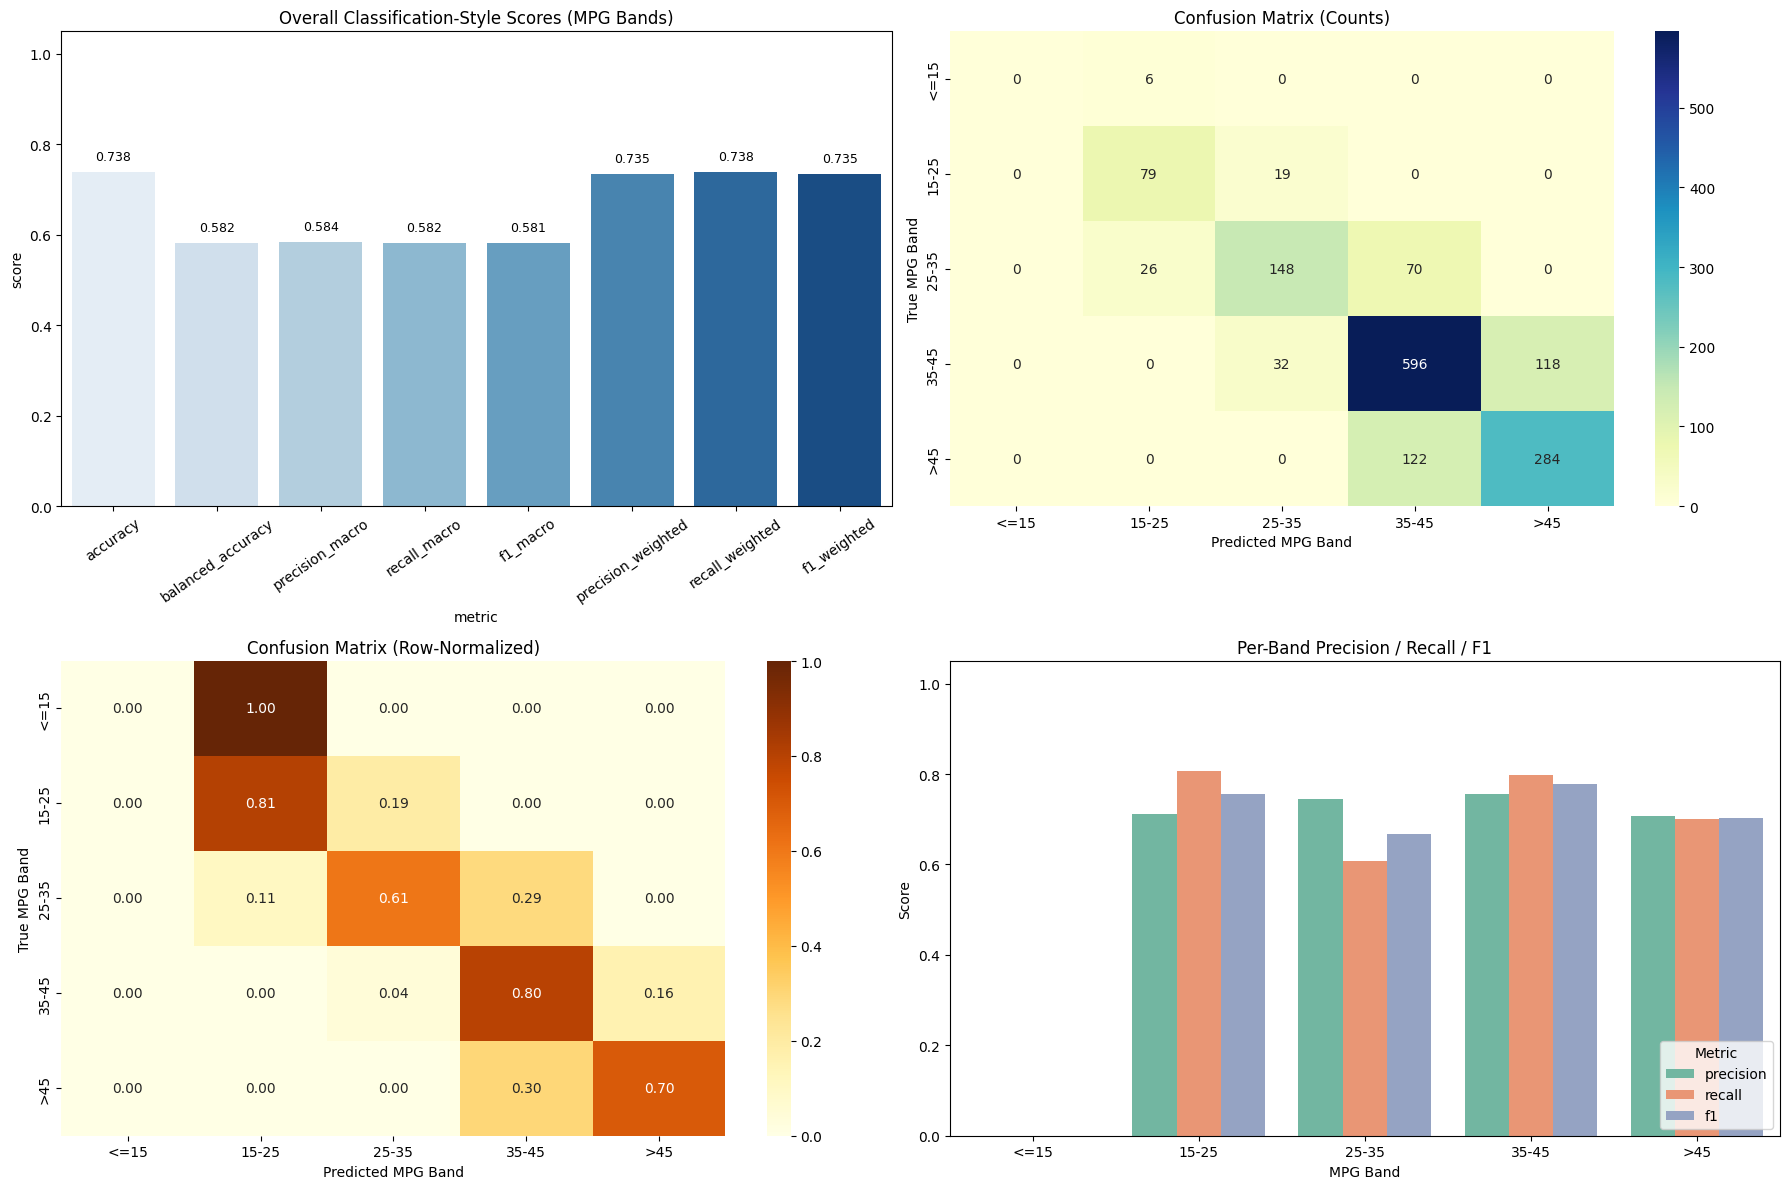

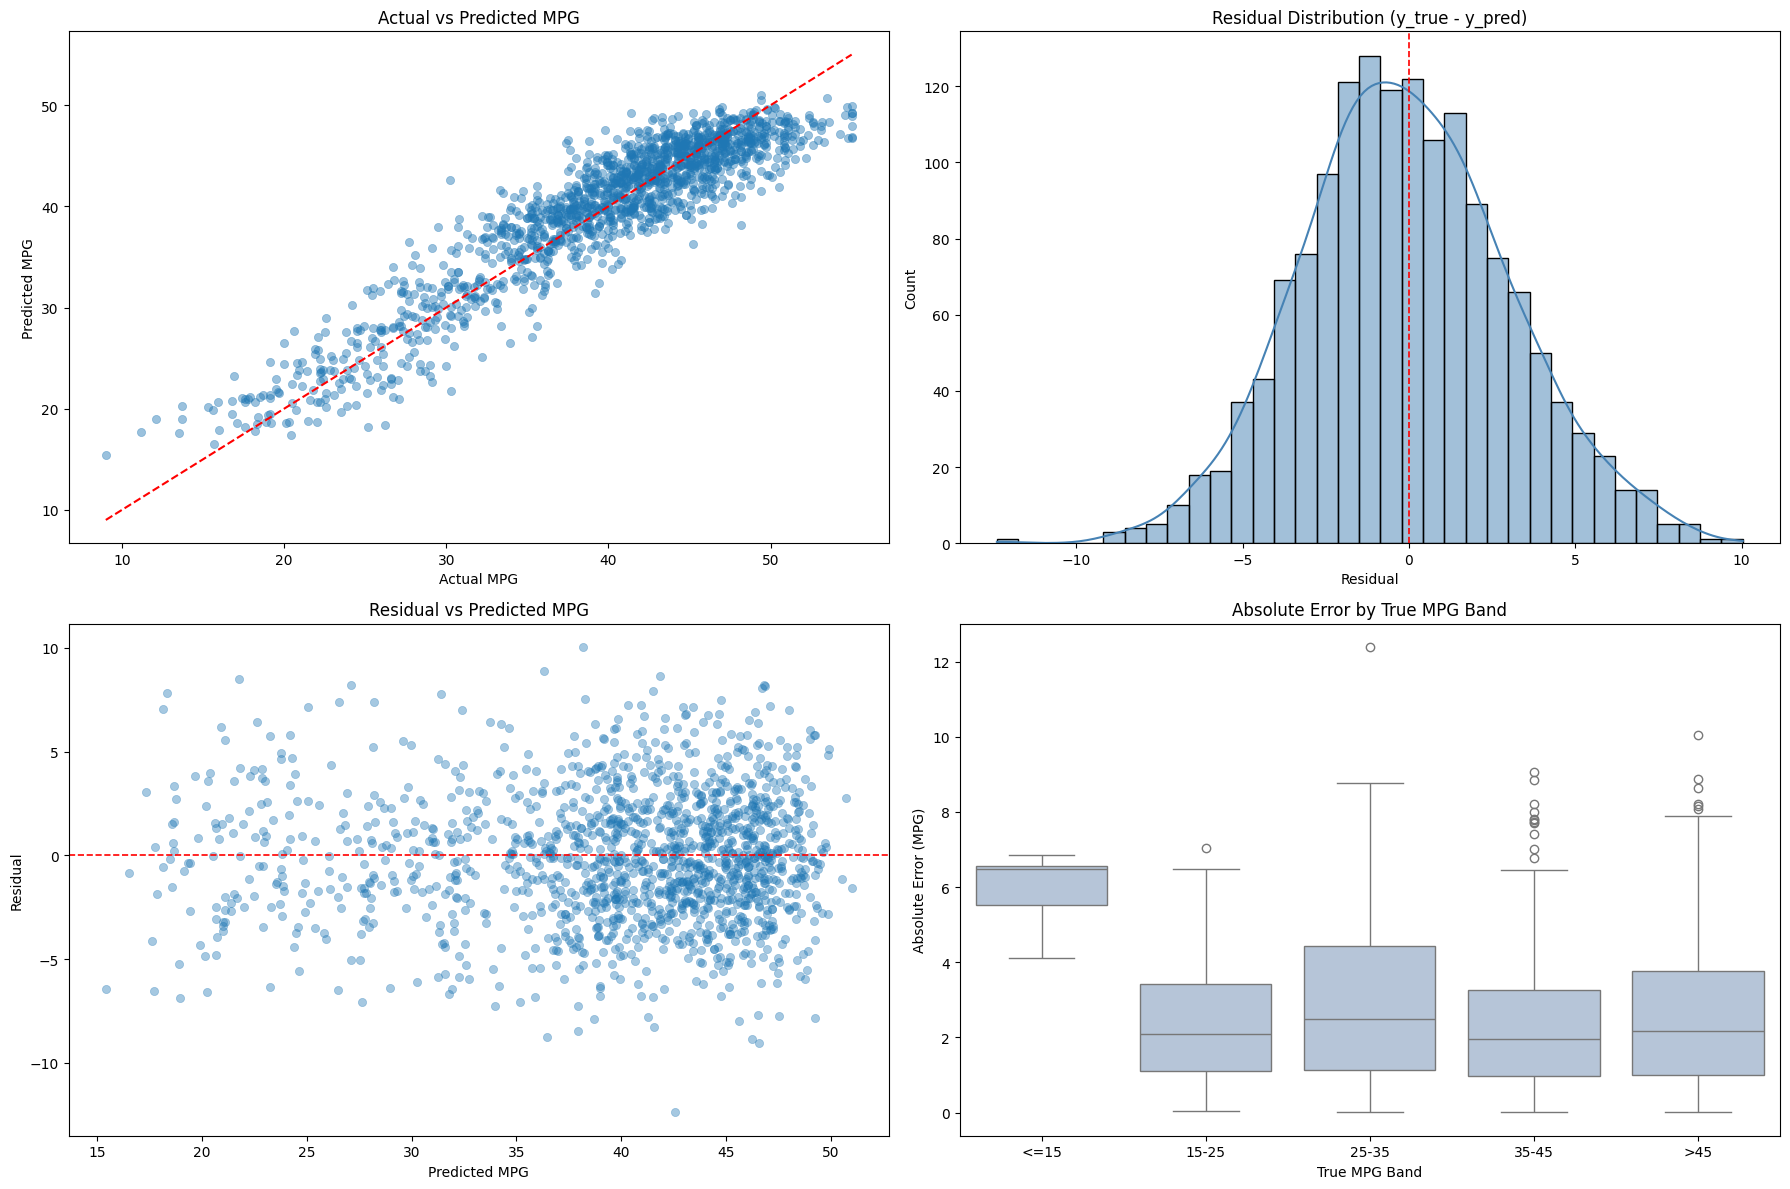

,metric,score
0,accuracy,0.738000
1,balanced_accuracy,0.582223
2,precision_macro,0.583649
3,recall_macro,0.582223
4,f1_macro,0.580835
5,precision_weighted,0.734850
6,recall_weighted,0.738000
7,f1_weighted,0.734805


In [533]:
# 11.10 Classification-Style Metrics + Visual Diagnostics
labels = ['<=15', '15-25', '25-35', '35-45', '>45']
bins = [-np.inf, 15, 25, 35, 45, np.inf]

# Map continuous MPG values into classification bands for confusion-matrix style analysis.
y_true_band = pd.cut(error_analysis_df['y_true'], bins=bins, labels=labels)
y_pred_band = pd.cut(error_analysis_df['y_pred'], bins=bins, labels=labels)

y_true_cls = y_true_band.astype(str)
y_pred_cls = y_pred_band.astype(str)

accuracy = accuracy_score(y_true_cls, y_pred_cls)
balanced_accuracy = balanced_accuracy_score(y_true_cls, y_pred_cls)

precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true_cls, y_pred_cls, labels=labels, average='macro', zero_division=0
)
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_true_cls, y_pred_cls, labels=labels, average='weighted', zero_division=0
)

p_cls, r_cls, f1_cls, support_cls = precision_recall_fscore_support(
    y_true_cls, y_pred_cls, labels=labels, average=None, zero_division=0
)

classification_overall_metrics = pd.DataFrame([
    {'metric': 'accuracy', 'score': accuracy},
    {'metric': 'balanced_accuracy', 'score': balanced_accuracy},
    {'metric': 'precision_macro', 'score': precision_macro},
    {'metric': 'recall_macro', 'score': recall_macro},
    {'metric': 'f1_macro', 'score': f1_macro},
    {'metric': 'precision_weighted', 'score': precision_weighted},
    {'metric': 'recall_weighted', 'score': recall_weighted},
    {'metric': 'f1_weighted', 'score': f1_weighted},
])

per_class_metrics = pd.DataFrame({
    'mpg_band': labels,
    'precision': p_cls,
    'recall': r_cls,
    'f1': f1_cls,
    'support': support_cls,
})

cm_counts = confusion_matrix(y_true_cls, y_pred_cls, labels=labels)
cm_counts_df = pd.DataFrame(cm_counts, index=labels, columns=labels)
row_sums = cm_counts.sum(axis=1, keepdims=True)
cm_norm = np.divide(cm_counts, row_sums, out=np.zeros_like(cm_counts, dtype=float), where=row_sums != 0)
cm_norm_df = pd.DataFrame(cm_norm, index=labels, columns=labels)

print('classification_overall_metrics')
print(classification_overall_metrics)
print('per_class_metrics')
print(per_class_metrics)
print('confusion_matrix_counts')
print(cm_counts_df)

# Figure 1: score summary + confusion matrices + per-class bars
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

sns.barplot(
    data=classification_overall_metrics,
    x='metric',
    y='score',
    hue='metric',
    palette='Blues',
    dodge=False,
    legend=False,
    ax=axes[0, 0],
)
axes[0, 0].set_title('Overall Classification-Style Scores (MPG Bands)')
axes[0, 0].set_ylim(0, 1.05)
axes[0, 0].tick_params(axis='x', rotation=35)
for i, v in enumerate(classification_overall_metrics['score']):
    axes[0, 0].text(i, min(v + 0.02, 1.02), f'{v:.3f}', ha='center', va='bottom', fontsize=9)

sns.heatmap(
    cm_counts_df,
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    cbar=True,
    ax=axes[0, 1],
)
axes[0, 1].set_title('Confusion Matrix (Counts)')
axes[0, 1].set_xlabel('Predicted MPG Band')
axes[0, 1].set_ylabel('True MPG Band')

sns.heatmap(
    cm_norm_df,
    annot=True,
    fmt='.2f',
    cmap='YlOrBr',
    cbar=True,
    vmin=0,
    vmax=1,
    ax=axes[1, 0],
)
axes[1, 0].set_title('Confusion Matrix (Row-Normalized)')
axes[1, 0].set_xlabel('Predicted MPG Band')
axes[1, 0].set_ylabel('True MPG Band')

per_class_long = per_class_metrics.melt(
    id_vars=['mpg_band', 'support'],
    value_vars=['precision', 'recall', 'f1'],
    var_name='metric',
    value_name='score',
)
sns.barplot(
    data=per_class_long,
    x='mpg_band',
    y='score',
    hue='metric',
    palette='Set2',
    ax=axes[1, 1],
)
axes[1, 1].set_title('Per-Band Precision / Recall / F1')
axes[1, 1].set_ylim(0, 1.05)
axes[1, 1].set_xlabel('MPG Band')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend(title='Metric', loc='lower right')

fig.tight_layout()
plt.show()

# Figure 2: regression diagnostics for model behavior
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

sns.scatterplot(
    data=error_analysis_df,
    x='y_true',
    y='y_pred',
    alpha=0.45,
    s=35,
    edgecolor=None,
    ax=axes[0, 0],
)
min_v = float(min(error_analysis_df['y_true'].min(), error_analysis_df['y_pred'].min()))
max_v = float(max(error_analysis_df['y_true'].max(), error_analysis_df['y_pred'].max()))
axes[0, 0].plot([min_v, max_v], [min_v, max_v], color='red', linestyle='--', linewidth=1.5)
axes[0, 0].set_title('Actual vs Predicted MPG')
axes[0, 0].set_xlabel('Actual MPG')
axes[0, 0].set_ylabel('Predicted MPG')

sns.histplot(error_analysis_df['residual'], kde=True, bins=35, color='steelblue', ax=axes[0, 1])
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=1.2)
axes[0, 1].set_title('Residual Distribution (y_true - y_pred)')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Count')

sns.scatterplot(
    data=error_analysis_df,
    x='y_pred',
    y='residual',
    alpha=0.4,
    s=35,
    edgecolor=None,
    ax=axes[1, 0],
)
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=1.2)
axes[1, 0].set_title('Residual vs Predicted MPG')
axes[1, 0].set_xlabel('Predicted MPG')
axes[1, 0].set_ylabel('Residual')

sns.boxplot(
    data=error_analysis_df,
    x='mpg_band',
    y='abs_error',
    order=labels,
    color='lightsteelblue',
    ax=axes[1, 1],
)
axes[1, 1].set_title('Absolute Error by True MPG Band')
axes[1, 1].set_xlabel('True MPG Band')
axes[1, 1].set_ylabel('Absolute Error (MPG)')

fig.tight_layout()
plt.show()

classification_overall_metrics


# 12. Model Deployment & Usage (JSON + Flask API)
**Method:** Export tuned XGBoost model to JSON and validate inference through Flask endpoints.
**Reason:** Provide a production-ready deployment path aligned with document Section 12.
        


# 12.1 Model Serialization (XGBoost JSON)


In [535]:
from pathlib import Path
import json
import sys

import numpy as np
import pandas as pd

# Resolve project root robustly so imports work whether notebook runs from repo root or src/train.
cwd = Path.cwd().resolve()
project_root = next(
    (
        p for p in [cwd, *cwd.parents]
        if (p / 'src' / 'train' / 'export_xgboost_json.py').exists()
        and (p / 'src' / 'api' / 'app.py').exists()
    ),
    None,
)
if project_root is None:
    raise FileNotFoundError('Could not locate project root containing src/train and src/api.')

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.train.export_xgboost_json import train_and_export

candidate_data_paths = [
    project_root / 'data' / 'raw' / 'automobile_data.csv',
    Path('../../data/raw/automobile_data.csv').resolve(),
    Path('data/raw/automobile_data.csv').resolve(),
]
data_path = next((p for p in candidate_data_paths if p.exists()), None)
if data_path is None:
    raise FileNotFoundError('automobile_data.csv not found in expected locations.')

candidate_model_dirs = [
    project_root / 'models',
    Path('../../models').resolve(),
    Path('models').resolve(),
]
model_dir = next((p for p in candidate_model_dirs if p.exists()), candidate_model_dirs[0])
model_dir.mkdir(parents=True, exist_ok=True)

section12_model_version = 'v1.0.0-notebook'
section12_model_path, section12_metadata_path = train_and_export(
    data_path=data_path,
    model_dir=model_dir,
    model_version=section12_model_version,
)

section12_metadata = json.loads(section12_metadata_path.read_text(encoding='utf-8'))

section12_serialization_summary = pd.DataFrame([
    {
        'project_root': str(project_root),
        'model_path': str(section12_model_path),
        'metadata_path': str(section12_metadata_path),
        'model_size_bytes': int(section12_model_path.stat().st_size),
        'feature_count': int(len(section12_metadata.get('feature_columns', []))),
        'test_rmse': float(section12_metadata.get('metrics_test', {}).get('rmse', np.nan)),
        'test_r2': float(section12_metadata.get('metrics_test', {}).get('r2', np.nan)),
    }
])

print('section12_serialization_summary')
print(section12_serialization_summary)
section12_serialization_summary


section12_serialization_summary
               project_root                                        model_path  \
0  D:\project\mpg-predictor  D:\project\mpg-predictor\models\xgboost_mpg.json   

                                       metadata_path  model_size_bytes  \
0  D:\project\mpg-predictor\models\model_metadata...            906279   

   feature_count  test_rmse   test_r2  
0             41   3.072815  0.854529  


,project_root,model_path,metadata_path,model_size_bytes,feature_count,test_rmse,test_r2
0,D:\project\mpg-predictor,D:\project\mpg-predictor\models\xgboost_mpg.json,D:\project\mpg-predictor\models\model_metadata...,906279,41,3.072815,0.854529


# 12.2 Creating Prediction Pipeline (Flask API Smoke Test)


In [536]:
from pathlib import Path
import sys

# Ensure imports work even if this cell is run directly.
if 'project_root' not in globals():
    cwd = Path.cwd().resolve()
    project_root = next(
        (
            p for p in [cwd, *cwd.parents]
            if (p / 'src' / 'api' / 'app.py').exists()
        ),
        None,
    )
    if project_root is None:
        raise FileNotFoundError('Could not locate project root for Flask app import.')

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.api.app import create_app

app_section12 = create_app()
section12_default_payload = dict(section12_metadata.get('default_payload', {}))

with app_section12.test_client() as client:
    health_resp = client.get('/api/health')
    predict_resp = client.post('/api/predict', json=section12_default_payload)

section12_health_body = health_resp.get_json(silent=True)
section12_predict_body = predict_resp.get_json(silent=True)

section12_api_smoke_test = pd.DataFrame([
    {
        'health_status_code': int(health_resp.status_code),
        'predict_status_code': int(predict_resp.status_code),
        'model_ready': bool(section12_health_body.get('model_ready')) if isinstance(section12_health_body, dict) else False,
        'predicted_mpg': float(section12_predict_body.get('predicted_mpg', np.nan)) if isinstance(section12_predict_body, dict) else np.nan,
    }
])

print('section12_api_smoke_test')
print(section12_api_smoke_test)
print('section12_predict_body', section12_predict_body)
section12_api_smoke_test


section12_api_smoke_test
   health_status_code  predict_status_code  model_ready  predicted_mpg
0                 200                  200         True          41.81
section12_predict_body {'model_name': 'xgboost_mpg_regressor', 'model_version': 'v1.0.0-notebook', 'predicted_mpg': 41.81}


,health_status_code,predict_status_code,model_ready,predicted_mpg
0,200,200,True,41.81
